In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import re
%matplotlib inline
import json;
import os;
with open("./secrets/secrets.json") as json_file:  
            secrets = json.load(json_file);
os.environ["WEB3_INFURA_PROJECT_ID"] = secrets["WEB3_INFURA_PROJECT_ID"];
from web3.auto.infura import w3 as web3;

## Get addresses from etherscan

In [142]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3"}
reg_url = "https://etherscan.io/accounts/label/exchange/1?ps=100"
req = Request(url=reg_url, headers=headers) 
html = urlopen(req).read().decode('utf-8')

In [143]:
res1 = re.findall("address/0x.{40}", html)
res1 = re.findall("0x.{40}", str(res1))

In [144]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
elements = soup.find_all("tr")
elements = list(elements)[1:-1]
exchangeNames = [e.contents[1].get_text() for e in elements]
exchangeAddresses = [e.contents[0].get_text().strip(" ") for e in elements]
display(len(exchangeNames))
display(len(exchangeAddresses))
# for i in e:
#     print(i.contents[1].get_text())
#     print(i.children[1])

100

100

In [145]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3"}
reg_url = "https://etherscan.io/accounts/label/exchange/2?ps=100"
req = Request(url=reg_url, headers=headers) 
html = urlopen(req).read().decode('utf-8')

In [146]:
soup = BeautifulSoup(html, 'html.parser')
elements = soup.find_all("tr")
elements = list(elements)[1:-1]
exchangeNames.extend([e.contents[1].get_text() for e in elements])
exchangeAddresses.extend([e.contents[0].get_text().strip(" ") for e in elements])
import json
with open('exchangeAddresses.json', 'w') as json_file:
    json.dump(exchangeAddresses, json_file)

In [147]:
exchangeAddresses = [web3.toChecksumAddress(addr) for addr in exchangeAddresses] # format 

In [148]:
exchangeData = pd.DataFrame(zip(exchangeAddresses, exchangeNames), columns=["address", "name"])

# Get hack events

In [149]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3"}
reg_url = "https://cryptosec.info/exchange-hacks/"
req = Request(url=reg_url, headers=headers) 
html = urlopen(req).read().decode('utf-8')

In [150]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(html, 'html.parser')
elements = soup.find_all("div", class_='image-position-column')
dates = soup.find_all("div", class_='eae-tl-item-meta')
# display(len(dates))
namesOfExchanges = soup.find_all("h3", class_='eae-tl-item-title')
namesOfExchanges = [n.text for n in namesOfExchanges]
# display(len(namesOfExchanges))
# namesOfExchanges
# hackedAmounts = soup.find_all("span", attrs={'style':'color: #ff0000;'})
# numbers = []
# for s in hackedAmounts:
#     if s.text.startswith("$"):
# #         display(s.text)
#         numbers.append(s.text)
        
# numbers = [s.replace(",","") for s in numbers]
# numbers = [s.replace("$","") for s in numbers]
# display(namesOfExchanges)
# numbers

nur die größten hack events eintragen

In [151]:
d = [d.text for d in dates]

dates = []
for i in d:
    s = re.findall(" .* ",i)
    s = str(s[0])
    s = s.replace(",", "")
#     print(s)
    s = s.strip(" ")
    dates.append(s)
    

In [152]:
import datetime

for i, d in enumerate(dates):
    if len(d.split(" ")) == 3:
        dates[i] = datetime.datetime.strptime(d, '%B %d %Y');
    else:
        dates[i] = datetime.datetime.strptime(d, '%B %Y');

In [153]:
hack_events = pd.DataFrame(zip(namesOfExchanges, dates), columns=["hacked_exchange", "datetime"])

## Save addresses locally

In [154]:
import json
with open('exchangeData.json', 'w') as json_file:
    json.dump(exchangeData.to_json(), json_file)

## Get balances for each address

In [157]:
balances = [web3.eth.getBalance(addr) for addr in exchangeData["address"]]
exchangeData["balance"] = balances
exchangeData["balance"] = pd.to_numeric(exchangeData["balance"])
exchangeData

,address,name,balance
0,0x05f51AAb068CAa6Ab7eeb672f88c180f67F17eC7,ABCC,1.993777e+20
1,0xf0c80FB9FB22BEF8269CB6fEB9a51130288a671f,Artis Turba Exchange 1,6.407144e+18
2,0x94597850916a49b3B152EE374E97260B99249f5B,Artis Turba Exchange 2,3.808458e+18
3,0x4dF5f3610e2471095a130D7d934D551f3ddE01ED,ATAIX,6.734004e+19
4,0xAdb72986EAd16bDbc99208086BD431C1Aa38938e,Beaxy,1.853639e+17
...,...,...,...
181,0xF5bEC430576fF1b82e44DDB5a1C93F6F9d0884f3,Yobit.net,4.720809e+22
182,0xd94c9ff168dc6aEbf9b6CC86dEfF54f3fb0AFC33,Yunbi 1,3.906756e+19
183,0x42dA8a05CB7eD9A43572b5BA1B8F82A0a6E263DC,Yunbi 2,7.880665e+17
184,0x700f6912e5753e91ea3Fae877A2374A2db1245D7,Yunbi 3,1.617125e+20


In [160]:
address, name, balance = exchangeData.loc[exchangeData["balance"].idxmax()]
display(exchangeData.describe())
print("The address {address} has the highest balance: {balance}.".format(address = address, balance = balance))

,balance
count,1.860000e+02
mean,5.471927e+22
std,2.807930e+23
min,0.000000e+00
25%,2.449790e+18
50%,5.956917e+19
75%,1.599556e+21
max,2.201523e+24


The address 0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8 has the highest balance: 2.2015228557509146e+24.


In [161]:
exchangeData = exchangeData.sort_values(by="balance", ascending=False);
exchangeData = exchangeData.reset_index(drop=True);

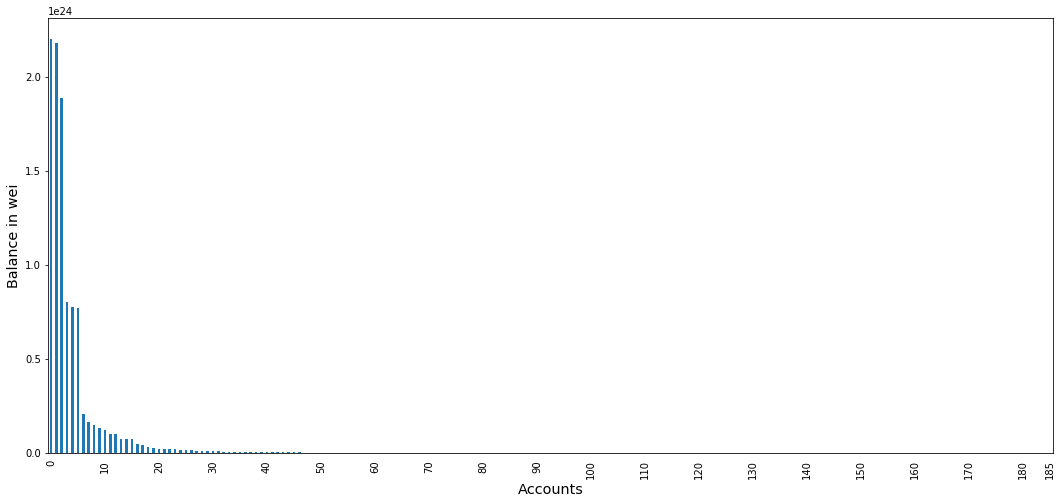

In [162]:
axes = exchangeData.plot.bar(figsize=(18,8))

axes.tick_params(
    axis='x',          
    bottom=False,      
    top=False,         
    labelbottom=True)

axes.set_xlabel("Accounts", fontsize="x-large");
axes.set_ylabel("Balance in wei", fontsize="x-large");

legend = axes.get_legend();
legend.set_visible(False);


ticketlabels = axes.xaxis.get_ticklabels();
for index, ticklabel in enumerate(ticketlabels):
    if (index % 10 == 0 or index == len(ticketlabels) - 1) :
        ticklabel.set_visible(True)
    else:
        ticklabel.set_visible(False)

In [191]:
total_balance = exchangeData.sum()["balance"];
sum_tmp = 0;
exchangeData_compressed = [];
quantile = 0.8

for index, row in exchangeData.iterrows():
    sum_tmp = sum_tmp + row["balance"]
    if (sum_tmp / total_balance > quantile):
        break;
    exchangeData_compressed.append(row)
    
exchangeData_compressed = pd.DataFrame(exchangeData_compressed, columns=["address", "balance", "name"])

print("The following {} accounts have more than {} % of the total balance.".format(len(exchangeData_compressed), int(quantile * 100)))
display(exchangeData_compressed)

The following 5 accounts have more than 80 % of the total balance.


,address,balance,name
0,0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8,2.201523e+24,Binance 7
1,0x742d35Cc6634C0532925a3b844Bc454e4438f44e,2.176401e+24,Bitfinex 5
2,0xDc76CD25977E0a5Ae17155770273aD58648900D3,1.885861e+24,Huobi 6
3,0xE853c56864A2ebe4576a807D26Fdc4A0adA51919,8.010528e+23,Kraken 3
4,0x66f820a414680B5bcda5eECA5dea238543F42054,7.750006e+23,Bittrex 3


In [164]:
duration = int((30*24*60*60)/12); # one month
# duration = int((24*60*60)/12); # one day

latestBlockNumber = web3.eth.getBlock('latest').number;
time_in_blocks = range(0,latestBlockNumber,duration);

In [165]:
import time;
from datetime import datetime;

start = time.time();

balances = [];
sum_of_balances_tmp = [];
unixtimestamps = [];
addresses = exchangeData_compressed["address"];

for block in time_in_blocks:
    b = [web3.eth.getBalance(web3.toChecksumAddress(addr), block_identifier=block) for addr in addresses];
    balances.append(tuple(b))
    sum_of_balances_tmp.append(sum(b));
    unixtimestamps.append(web3.eth.getBlock(block).timestamp);
    
# sum_of_balances = pd.DataFrame(zip(sum_of_balances_tmp, unixtimestamps), columns=["total_balance_in_wei","timestamp_unix"]);

end = time.time();

print("Time elapsed: {seconds}".format(seconds=end-start));

Time elapsed: 49.37639141082764


Anmerkungen: Die balances täglich abzufragen dauert 27,4 min.

In [166]:
sum_of_balances = pd.DataFrame(list(zip(*balances))).transpose();
sum_of_balances.columns = [c for c in addresses];
sum_of_balances["timestamp_unix"] = unixtimestamps;
sum_of_balances["total_balance_in_wei"] = sum_of_balances_tmp;
for colName in sum_of_balances:
    if (colName != "timestamp_unix"):
        sum_of_balances.loc[: , colName] = sum_of_balances.loc[: , colName].astype("float")
sum_of_balances

,0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8,0x742d35Cc6634C0532925a3b844Bc454e4438f44e,0xDc76CD25977E0a5Ae17155770273aD58648900D3,0xE853c56864A2ebe4576a807D26Fdc4A0adA51919,0x66f820a414680B5bcda5eECA5dea238543F42054,timestamp_unix,total_balance_in_wei
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1441938565,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1445682932,0.000000e+00
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1449372180,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1453066054,0.000000e+00
5,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1456783758,0.000000e+00
6,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1460075883,0.000000e+00
7,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1463174778,0.000000e+00
8,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1466275351,0.000000e+00
9,0.000000e+00,0.000000e+00,0.000000e+00,7.791350e+24,0.000000e+00,1469365781,7.791350e+24


In [209]:
with open("sum_of_balances_from_etherscan_exchange_accounts_daily.json", "r") as file:
    data = file.read()
obj = json.loads(data)
sum_of_balances = pd.DataFrame(obj)

In [210]:
def genfunc():
    x = 0.7
    minus = False
    while(True):
        if (x < 0.3):
            minus = False
        if (x > 0.7):
            minus = True
            
        if (minus == True):
            x -= 0.08
        else:
            x += 0.08
        yield x
        
gen = genfunc()

Time elapsed: 19.23437523841858


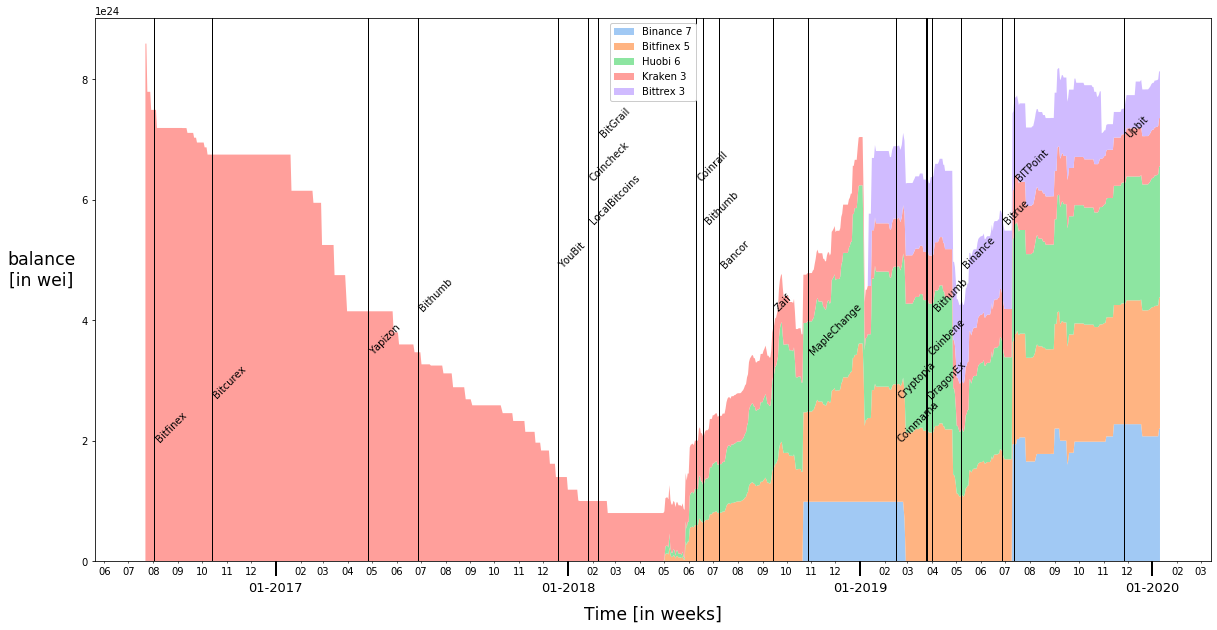

In [211]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.transforms as transforms

start = time.time();

data_to_plot = sum_of_balances[sum_of_balances["total_balance_in_wei"] > 0].copy(deep=True);
data_to_plot.loc[: , "timestamp_unix"] = pd.to_datetime(data_to_plot.loc[: , "timestamp_unix"], unit='s')

# data_to_plot.loc[: , "timestamp_unix"] = [datetime.utcfromtimestamp(ts).strftime('%Y-%m') for ts in data_to_plot.loc[:,"timestamp_unix"]]
data_to_plot = data_to_plot.reset_index(drop=True);
data_to_plot = data_to_plot.drop(index=0)

# labels = ["0xBE0eB53F46cd790Cd13851d5EFf43D12404d33E8","0x742d35Cc6634C0532925a3b844Bc454e4438f44e",
#           "0xDc76CD25977E0a5Ae17155770273aD58648900D3","0xE853c56864A2ebe4576a807D26Fdc4A0adA51919",
#           "0x66f820a414680B5bcda5eECA5dea238543F42054"]

labels = exchangeData_compressed["name"]

fig, ax = plt.subplots(figsize= (20,10))
pal = sns.color_palette("pastel")

ax.stackplot(data_to_plot["timestamp_unix"], data_to_plot.iloc[:,0], data_to_plot.iloc[:,1], 
             data_to_plot.iloc[:,1], data_to_plot.iloc[:,3], data_to_plot.iloc[:,4], labels=labels, colors=pal)

ax.legend(loc='upper center')
plt.rcParams["legend.framealpha"] = 1

# plt.plot(sum_of_balances["timestamp_unix"], sum_of_balances["total_balance_in_wei"],color="black")

ax.tick_params(
    which="major",
    axis='x', 
    bottom=True,      
    top=False,        
    labelbottom=True,
    labelsize= 13,
    pad = 5,
    length = 15,
    width = 2
    ) 


ax.set_xlabel( "Time [in weeks]", fontsize="xx-large");
ax.xaxis.set_label_coords(0.5, -0.08)
ax.set_ylabel("balance\n[in wei]", fontsize="xx-large", rotation=0, labelpad=40);

hack_events_to_plot = hack_events[hack_events["datetime"] > min(data_to_plot["timestamp_unix"])]

trans = transforms.blended_transform_factory(
    ax.transData, ax.transAxes)

height = 1
for i, ev in enumerate(hack_events_to_plot.iterrows()):
    ax.axvline(x=hack_events_to_plot["datetime"][i], color="black", lw=1)
    height -= 0.05
    plt.text(hack_events_to_plot["datetime"][i], next(gen) ,hack_events_to_plot["hacked_exchange"][i], transform=trans, rotation=45)

fig.savefig('kundeneinlagen.png', format='png', dpi=300)
    
end = time.time();

print("Time elapsed: {seconds}".format(seconds=end-start));

import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
years_fmt = mdates.DateFormatter('%m-%Y')
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%m')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmt)

# fig.autofmt_xdate()
# plt.locator_params(axis='x', nbins=10)

# from matplotlib.dates import DateFormatter
# myFmt = DateFormatter("%d")
# ax.xaxis.set_major_formatter(myFmt)
# data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABLwAAAJbCAYAAADuTo06AAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nOzdeVxV1fr48c8GHEBCwSmVDARFxnMQcChF1KsIJalZoFaKaUpaOVu/MrOrqWlazpXmnJhDDmmKY2lXRVCcB1RQwQkVREBk2r8/zmV/PcFB7JqIPe/Xi5ey9tp7PWvtjcjDWmsrqqoihBBCCCGEEEIIIcTTwqysAxBCCCGEEEIIIYQQ4lGShJcQQgghhBBCCCGEeKpIwksIIYQQQgghhBBCPFUk4SWEEEIIIYQQQgghniqS8BJCCCGEEEIIIYQQTxVJeAkhhBBCCCGEEEKIp4okvB4TRVF+UBTluqIox0pRd6iiKCcURTmiKMp2RVGe/9NxG0VRkhRFmfn3RSyEEEIIIYQQQghRPknC6/FZCHQsZd1DgK+qql7AKuDLPx3/N/D7owtNCCGEEEIIIYQQ4ukhCa/HRFXV34Fb95cpiuKkKMpmRVFiFUXZrShK4//W3amqatZ/q+0D7O87xweoDUQ9ptCFEEIIIYQQQgghyhVJeJWt74D3VFX1AYYDs4up8zbwK4CiKGbAV/+tK4QQQgghhBBCCCGKYVHWAfxTKYpiDbwArFQUpbC40p/qvAH4Aq3/W/QusElV1aT7zhFCCCGEEEIIIYQQ95GEV9kxA9JUVdUXd1BRlH8BHwOtVVW999/iFkArRVHeBayBioqiZKiq+uFjiVgIIYQQQgghhBCiHJAljWVEVdV0IEFRlNcAFAPdf//uDXwLhKiqev2+c3qqqlpfVVUHDMsaF0uySwghhBBCCCGEEMKYJLweE0VRlgN7ARdFUZIURXkb6Am8rSjKYeA48Mp/q0/GMINrpaIocYqirC+ToIUQQgghhBBCCCHKIUVV1bKOQQghhBBCCCGEEEKIR0ZmeAkhhBBCCCGEEEKIp4psWv8Y1KhRQ3VwcCjrMJ5asbGx+Pj4lHUYQhh52p7Lp60/ouyV9TP1MO2XdayiZCXdn0dx7/4J9/9J7OOTGNM/QVmOe2xsLECx7ZdVXOXtOXzYeMtb/8SD/RPvaWxs7A1VVWsWd0yWND4Gvr6+akxMTFmH8dRSFAV5jsWT5ml7Lp+2/oiyV9bP1MO0X9axipKVdH8exb37J9z/J7GPT2JM/wRlOe6KogAU235ZxVXensOHjbe89U882D/xniqKEquqqm9xx2RJoxBCCCGEEEIIIYR4qkjCSwghhBBCCCGEEEI8VSThJYQQQgghhBBCCCGeKrKH12Mge3j9vf6J65TFk+9pey6ftv6UVzk5OZw7d46srKyyDkUIIf4SKysrnJycqFixYon15PtO2ZA9vJ6Mdv8q2cNL/BPvaUl7eMlbGoUQQohy4ty5c1SrVg0XFxfMzGSSthCifCkoKODatWucO3cOV1fXsg5HCCHEU07+tyyEEEKUE1lZWdSuXVuSXUKIcsnMzIzatWvLLFUhhBCPhfyPWQghhChHJNklhCjP5N8wIYQQj4t8xxFCCCGEEEIIIYQQTxVJeAkhhBDl1OLozEf6UVqbN2/GxcUFZ2dnJk6cWGJdBwcHPD090ev1eHp6sm7dOu2Yubk5er1e+yi8VkJCAs2aNcPZ2ZnQ0FBycnJKbGPhwoXUrFkTvV6Pu7s73bp105ZM3X9Mr9czb948AC5cuECTJk20c+bOnVtszHq9nv/85z/asfT0dOzt7Rk0aJBWlpOTwzvvvEOjRo1o3Lgxq1evLuVIwmeffcaUKVMACA0N1dp0cHBAr9dr1w8PD8fT0xOdTseuXbu082NjY/H09MTZ2Zn333/faKPaKVOm0LhxY/R6PX5+fixevLhI+7t27eLll18G4NSpU7Ro0YJKlSppMQFkZ2fTtGlTdDod7u7ujBkzRju2fft2bRxbtmzJ2bNnSxx3gI4dO1KtWjWt3eLcH9euXbuoWrWqdq3PP/9cq2fqGQoICMDFxUUrX7VqFQDTp0/H1dWVnj17atc4cOAAFhYWWp3SPBuenp64ubnxySefkJ2d/cC+9ezZExcXFzw8POjTpw+5ublGx/8cA8CiRYto2LAhDRs2ZNGiRUXGKCQkBA8Pj2LHLzExUTsWHR2tjYNOp+Pnn38GSr6vfx6/bt26AXDx4kXatGmDt7c3Xl5ebNq0qdj2hRBCiCeBbFovhBBCiFLLz89n4MCBbN26FXt7e/z8/AgJCcHNzc3kOTt37qRGjRqcPn2aDh068MorrwBgaWlJXFxckfqjRo1iyJAhhIWFMWDAAObPn09ERESJcYWGhjJz5kwAevTowYoVKwgPDy9yrFCdOnXYu3cvlSpVIiMjAw8PD0JCQqhbt65RzH82evRo/P39jcrGjx9PrVq1OHPmDAUFBdy6davEWE1ZsWKF9vdhw4ZRtWpVAL7//nsAjh49yvXr1wkKCuLAgQOYmZkRERHB999/T7NmzQgODmbz5s0EBQUxd+5ctm7dSnR0NDY2NqSnp2uJDlPs7OyYPn06a9euNSqvVKkSO3bswNramtzcXFq2bElQUBDNmzcnIiKCdevW4erqyuzZsxk3bhwLFy4Eih93gBEjRpCVlcW3335b6rFp1aoVv/zyS5FyU88QwLJly/D1NX5p0+zZs9m2bRv29vaA4XkeNWoUHTp00OqU9tnIyMjgnXfeoX///lpCylTfevbsydKlSwHD8zlv3jztmS4uhlu3bjF27FhiYmJQFAUfHx9CQkKwtbUFYM2aNVhbW5dq7Dw8PIiJicHCwoIrV66g0+no1KlTiffV1PiNGzeO119/nYiICE6cOEFwcDCJiYmlikMIIYR43GSGlxBCCCFKLTo6GmdnZxo0aEDFihUJCwtj5cqVuLi4cPr0aQC6d++uJWnul56erv3AboqqquzYsUObUdKrVy8tAZOSksKrr76Kn58ffn5+/PHHH0XOz8vLIzMz84HtVKxYkUqVKgFw7949CgoKHtj32NhYrl27ZpSYAPjhhx/46KOPAMP+RIWJsmvXrtGlSxd0Oh06nU6bKTZ+/HgaNWpEy5YttTH78xj89NNPdO/eHYATJ07Qtm1bAGrVqkW1atWIiYnhypUrpKen07x5cxRF4a233tLG6osvvmDOnDnY2NgAYGNjQ69evQDDDL3GjRvTpEkT1qxZo7Vbq1Yt/Pz8qFChglE8iqJoyZXc3Fxyc3NRFEU7lp6eDsDt27e1pFBJ2rVrxzPPPFOk3FRcj8qAAQM4f/48QUFBTJs2DYAZM2bw6quvUqtWLa1eaZ8Na2tr5s6dy9q1a7Ukp6m+BQcHoygKiqLQtGlTkpKStGPFxbBlyxbat2+PnZ0dtra2tG/fns2bNwOQkZHB1KlT+eSTT4zaiI2N1Z61WbNmaeVWVlZYWBh+x52dnW1070zdV1P+yv0WQgghyookvIQQQghRasnJyTz33HPa5/b29qSkpDBz5kx69+5NZGQkqamp9OvXT6vTpk0bPDw8aN26NePGjdPK7969a7QcbcWKFdy8eZNq1appP6Db29uTnJwMwAcffMCQIUM4cOAAq1evpm/fvtq1VqxYgV6vp169ety6dYtOnTppx1avXo2XlxfdunXj0qVLWvmlS5fw8vLiueeeY9SoUUY/vLdp0wa9Xk+zZs0AKCgoYNiwYUZL/QDS0tIAw8yvJk2a8Nprr3Ht2jUA3n//fVq3bs3hw4c5ePAg7u7uxMbGEhkZSVxcHJs2beLAgQNFxnj37t3Url2bhg0bAqDT6Vi/fj15eXkkJCQQGxvLpUuXSE5O1mYq3T9W6enp3LlzhwYNGhS5dnZ2Nv369WPDhg3ExsZy9erVInWKk5+fj16vp1atWrRv314bl3nz5hEcHIy9vT1Llizhww8/fOC4F+dBce3duxedTkdQUBDHjx/Xyot7hgr17NlTK7958yZz586lbt267Ny5kyFDhpCcnMzPP/9c7OzBkp6N+9nY2ODo6Eh8fPyDBxFDYmnJkiV07NgRwGQMxX2dFX4djB49mmHDhmFlZWV0Tnh4ODNmzODw4cNF2t2/fz/u7u54enoyd+5c7evL1H0F4/EbMWIEYFiCu3TpUuzt7QkODmbGjBml6rcQQghRFiThJYQQQoj/Wfv27fH09GTgwIFG+zWBYQnYsWPHOHr0KIMGDSIjIwP4v+VohR+hoaEltrFt2zYGDRqEXq8nJCSE9PR07VqhoaHExcVx9epVPD09mTx5MgCdOnUiMTGRI0eO0L59e22WE8Bzzz3HkSNHOHv2LIsWLdISVYUxx8XFsX//fsCwFK4wsXO/vLw8kpKSeOGFFzh48CAtWrRg+PDhAOzYsUNLZJibm1O1alV2795Nly5dsLKywsbGhpCQkCL9XL58uTa7C6BPnz7Y29vj6+vL4MGDeeGFFzA3Ny9xrEw5deoUjo6ONGzYEEVReOONN0p1nrm5OXFxcSQlJREdHc2xY8cAmDZtGps2bSIpKYnw8HCGDh0KlDzuDxtXkyZNuHDhAocPH+a9996jc+fO2rGSnqFly5Zp5dWrVy/S5uDBg5k0aVKxbw0s6dn4s/v3TXuQd999F39/f1q1avXAGIoTFxfHuXPn6NKli1F5WloaaWlp2nLbN9980+h4s2bNOH78OAcOHGDChAnavmOm7isYj1/h19Py5cvp3bs3SUlJbNq0iTfffLNUsyOFEEKIsiAJLyGEEEKUWr169Yxm6yQlJVGvXj0KCgo4efIkVlZWpKamFnuuk5MTtWvX5sSJEyavX716ddLS0sjLyzO6PhhmWe3bt0/7ITw5ObnIPkaKotCpUyd+//137XqFy9P69u1LbGxskTbr1q2Lh4cHu3fvNhnX3r17mTlzJg4ODgwfPpzFixfz4YcfUr16daysrOjatSsAr732GgcPHjR5nQfJy8tjzZo1RokbCwsLpk2bRlxcHOvWrSMtLY1GjRpRr149o6VxhWNlY2ODtbU158+f/8txmFKtWjXatGnD5s2bSUlJ4fDhw9qsoNDQUG3ZZmnGvbQK+wOGpYG5ubncuHHjf+wJxMTEEBYWhoODA6tWreLdd98tsn/Zg56NO3fukJiYSKNGjR7Y3tixY0lJSWHq1KkPjMHU19nevXuJiYnBwcGBli1bcubMGQICAkrdZ1dXV6ytrY0SW2B8X0syf/58Xn/9dQBatGhBdnb2I7kXQgghxN9BEl5CCCGEKDU/Pz/i4+NJSEggJyeHyMhIQkJCmDZtGq6urvz444+Eh4cXeQsdwPXr10lISOD55583eX1FUWjTpo32trpFixZpm9x36NDBaAmVqc3K9+zZg5OTEwBXrlzRytevX4+rqytgSCDcvXsXgNTUVPbs2YOLi4vJuJYtW8bFixdJTExkypQpvPXWW0ycOFFLsBW+OXH79u3aBv7t2rVjzpw5gGHp2O3bt/H392ft2rXcvXuXO3fusGHDBqN2tm3bRuPGjY1mkmVlZZGZaXiL5tatW7GwsMDNzY06depgY2PDvn37UFWVxYsXa2P10UcfMXDgQG2/pYyMDBYvXkzjxo1JTEzk3LlzgGHGzoOkpKRoSzfv3r3L1q1bady4Mba2tty+fZszZ85osRWOr6lxN6WkuK5evarNooqOjqagoKDYGVsPKyEhgcTERBITE+nWrRuzZ8+mc+fOpX42MjIyePfdd+ncufMD94ybN28eW7ZsYfny5UazuUzFEBgYSFRUFKmpqaSmphIVFUVgYCARERFcvnyZxMRE9uzZQ6NGjdi1axfVqlWjWrVq7NmzBzA8r/e3UZhAvnDhAqdOncLBwcHkfS1J/fr12b59OwAnT54kOzubmjVrPmiohRBCiDIhb2kUQgghyqm3mlZ57G1aWFgwc+ZMAgMDyc/Pp0+fPlhYWDBv3jyio6N55pln8Pf3Z9y4cYwdOxYw7Idlbm5Obm4uEydOpHbt2sD/7b9UqGPHjkycOJFJkyYRFhbGJ598gre3N2+//TYA06dPZ+DAgXh5eZGXl4e/vz9z584FDHt47dmzh4KCAuzt7bU3BU6fPp3169djYWGBnZ2dVn7y5EmGDRuGoiioqsrw4cPx9PT8S2MyadIk3nzzTQYPHkzNmjVZsGABAN988w3vvPMO8+fPx9zcnDlz5tCiRQtCQ0PR6XTaJvH3i4yMNFrOCIZEYWBgIGZmZtSrV48lS5Zox2bPnk3v3r25e/cuQUFBBAUFARAREUFGRoa2CX2FChUYNmwYlStX5rvvvuOll17CysqKVq1acefOHcCQWPL19SU9PR0zMzO+/vprTpw4wZUrV+jVqxf5+fkUFBTw+uuv8/LLLwOGN0i++uqrmJmZYWtryw8//FDiuIPhjYunTp0iIyMDe3t75s+fT2BgoMm4Vq1axZw5c7CwsMDS0pLIyEhtc3VTz9D/4kHPRps2bVBVlYKCArp06cLo0aMf2LcBAwbw/PPP06JFCwC6du3Kp59+ajIGOzs7Ro8erT0fn376KXZ2diXGvWDBAvr06YOiKEYvVtizZw8TJ06kQoUKmJmZMXv2bGrUqMGRI0dM3lcw7OFlaWkJQI0aNdi2bRtfffUV/fr1Y9q0aSiKwsKFCx+40b0QQghRVpSH2XdA/DW+vr5qTExMWYfx1Cr8D6kQT5Kn7bl82vpTXsXGxuLj41PWYQghxP+kNP+WyfedslGW416YPC2u/bKKq7w9hw8bb3nrn3iwf+I9VRQlVlVV3+KOyZLGv0BRlCGKohxXFOWYoijLFUWpXNYxCSGEEEIIIYQQQggDSXg9JEVR6gHvA76qqnoA5kBY2UYlhBBCCCGEEEIIIQpJwuuvsQAsFUWxAKyAy2UcjxBCCCGEEEIIIYT4L0l4PSRVVZOBKcBF4ApwW1XVqD/XUxTlHUVRYhRFiUlJSXncYQohhBBCCCGEEEL8Y0nC6yEpimILvAI4AnWBKoqivPHneqqqfqeqqq+qqr7yumYhhBBCCCGEEEKIx0cSXg/vX0CCqqopqqrmAmuAF8o4JiGEEEIIIYQQQgjxX5LwengXgeaKolgphnfntgNOlnFMQggh/ok2/vvRfpTS5s2bcXFxwdnZmYkTJ5qsd+fOHfR6vfZRo0YNBg8ebFRn9erVKIpCTEwMAFu3bsXHxwdPT098fHzYsWNHsddeuHAhgwYNAmDu3Ll4enqi1+tp2bIlJ06cACAxMRFLS0ut/QEDBmjnZ2Rk0L9/f5ycnPDx8SEgIID9+/eX2O+ffvoJNzc33N3d6dGjh1Z+8eJFOnTogKurK25ubiQmJgLw9ttvo9Pp8PLyolu3bmRkZJTYd4Do6Gj8/f1xcXHB29ubvn37kpWVhaqqvP/++zg7O+Pl5cXBgwe1c8zNzbU+hoSEaOWm2p86dSpubm54eXnRrl07Lly4oJ0zatQoPDw88PDwYMWKFVp5z549cXFxwcPDgz59+pCbmwvArl27qFq1qtb+559/XuIYAnTs2BGdToe7uzsDBgwgPz8fgICAAKOxKHT79m06deqknbNgwQKj4+np6djb22vPw/1CQkLw8PDQPu/duzeOjo7o9XoaN27M2LFjHxgvGO6xtbU1U6ZM0cocHBy0587Xt+jb0L/66isUReHGjRt/uQ2A/Px8vL29efnll7UyU/f24sWLtGnTBm9vb7y8vNi0aZN2Tvfu3fHy8mLatGkPjPHAgQNYWFiwatWqUsUuhBBCPIksyjqA8kZV1f2KoqwCDgJ5wCHgu7KNSgghhHg88vPzGThwIFu3bsXe3h4/Pz9CQkJwc3MrUveZZ54hLi5O+9zHx4euXbtqn9+5c4dvvvmGZs2aaWU1atRgw4YN1K1bl2PHjhEYGEhycnKJMfXo0UNLZq1fv56hQ4eyefNmAJycnIxiKNS3b18cHR2Jj4/HzMyMhIQELVFWnPj4eCZMmMAff/yBra0t169f14699dZbfPzxx7Rv356MjAzMzAy/T5w2bRo2NjYADB06lJkzZ/Lhhx+a7Pu1a9d47bXXiIyMpEWLFgCsWrWKO3fusGvXLuLj44mPj2f//v1ERERoCTpLS8ti+2iqfW9vb2JiYrCysmLOnDmMHDmSFStWsHHjRg4ePEhcXBz37t0jICCAoKAgbGxs6NmzJ0uXLtXGe968eURERADQqlUrfvnllxLv0f1++uknbGxsUFWVbt26sXLlSsLCTL/wetasWbi5ubFhwwZSUlJwcXGhZ8+eVKxYEYDRo0fj7+9f5Lw1a9ZgbW1dpHzy5Ml069aN7Oxs3NzceOutt3B0dCwx5qFDhxIUFFSkfOfOndSoUaNI+aVLl4iKiqJ+/folXrc0bXzzzTe4urqSnp6ulZm6t+PGjeP1118nIiKCEydOEBwcTGJiIlevXuXAgQOcPXv2gTHm5+czatQoOnToUOrYhRCiPMvOhMw0qF6vrCMRj5rM8PoLVFUdo6pqY1VVPVRVfVNV1XtlHZMQQgjxOERHR+Ps7EyDBg2oWLEiYWFhrFy5EhcXF06fPg0YZpJ8//33RuedOXOG69ev06pVK61s9OjRjBo1isqVK2tl3t7e1K1bFwB3d3fu3r3LvXuGb7MLFiygUaNGNG3alD/++EM7p/AHf4DMzEwME7BNO3fuHPv372fcuHFacsrR0ZGXXnoJgMWLF+Pl5YVOp+PNN98E4Pvvv2fgwIHY2toCUKtWLQBOnDhBXl4e7du3B8Da2horKyujuFRV5e7du0ZxFdf3WbNm0atXLy3ZBdCtWzdq167NunXreOutt1AUhebNm5OWlsaVK1dK7Kep9tu0aaPF2Lx5c5KSkrS++Pv7Y2FhQZUqVfDy8tISh8HBwSiKgqIoNG3aVDunJJ07d8bHxwd3d3e+++7/fjdYGFdeXh45OTlG47JkyRL0ej0eHh5ER0cDoCgKd+7cQVVVMjIysLOzw8LC8Dvb2NhYrl27ViQ5k5GRwdSpU/nkk09MxpednQ1AlSpVAMOsphdeeAGdTkfTpk25c+cOAGvXrsXR0RF3d/cH9rnQkCFD+PLLL436lpmZSZ8+fWjatCne3t6sW7dOO2aqjaSkJDZu3Ejfvn2Nyk3dW0VRtMTY7du3ta+lDh06kJycjF6vZ/fu3SZjBJgxYwavvvqq9owXmjx5Mn5+fnh5eTFmzJhSj4UQQjzJCvLhwhG4chbycss6GvGoScJLCCGEEKWWnJzMc889p31ub29PSkoKM2fOpHfv3kRGRpKamkq/fv2MzouMjCQ0NFT74frgwYNcunRJSzIVZ/Xq1TRp0oRKlSpx5coVxowZwx9//MGePXuKzMaaNWsWTk5OjBw5kunTp2vlCQkJeHt707p1a+0H/ePHj6PX6zE3Ny/S5vHjxxk3bhw7duzg8OHDfPPNN4AhYXfmzBlefPFFmjdvriWCzpw5Q7Vq1ejatSve3t6MGDFCW6IHEB4ezrPPPsupU6d47733Suz7sWPH8PHxKfW4F858y87OxtfXl+bNm7N27Vqj84pr/37z58/XZhXpdDo2b95MVlYWN27cYOfOnVy6dMmofm5uLkuWLKFjx45a2d69e9HpdAQFBXH8+HGt/IcffiA2NpaYmBimT5/OzZs3tWOBgYHUqlWLZ555hm7dumnlWVlZxMXFMXv2bPr06QPAoEGDOHnyJHXr1sXT05NvvvkGMzMzCgoKGDZsWJElgGBIKA4bNkxL7N1vxIgR6PV67O3tCQsLo1atWuTk5BAaGso333zD4cOH2bZtG5aWlmRkZDBp0qRiEzyKotChQwd8fHyMEnrr1q2jXr166HQ6o/rjx4+nbdu2REdHs3PnTkaMGEFmZmaJbQwePJgvv/xSS8zer7h7+9lnn7F06VLs7e0JDg5mxowZgGHmY+Fsx1atWpmMMTk5mZ9//lmbvVcoKiqK+Ph4oqOjiYuLIzY2lt9//71ITEIIUd4knzbM8MrPhWsJZR2NeNQk4SWEEEKI/1n79u3x9PRk4MCBzJs3r8jxyMhIunfvDkBBQQFDhw7lq6++Mnm948ePM2rUKL799lsA9u/fT0BAADVr1qRixYqEhoYa1R84cCDnzp1j0qRJjBs3DoA6depw8eJFDh06xNSpU+nRo4fRsrDi7Nixg9dee01bpmZnZwcYZiPFx8eza9culi9fTr9+/UhLSyMvL4/du3czZcoUDhw4wPnz51m4cKF2vQULFnD58mVcXV1ZsWJFqfr+sC5cuEBMTAw//vgjgwcP5ty5cybbv9/SpUuJiYlhxIgRgGEWUHBwMC+88ALdu3enRYsWRZKC7777Lv7+/tpMvSZNmnDhwgUOHz7Me++9R+fOnbW606dPR6fT0bx5cy5dukR8fLx2bMuWLVy5coV79+4Z7dNW+Iz4+/uTnp5OWloaW7ZsQa/Xc/nyZeLi4hg0aBDp6enMnj2b4OBg7O3tjWKMi4vj3LlzdOnSpdjxmjx5MnFxcVy9epXt27fzn//8h9OnT1OnTh38/PwAwwwqCwsLPvvsM4YMGVLs0sg9e/Zw8OBBfv31V2bNmsXvv/9OVlYWX3zxRbF7mUVFRTFx4kT0ej0BAQFkZ2dz8eJFk2388ssv1KpVy2QStLh7u3z5cnr37k1SUhKbNm3izTffpKCgwOi8kmIcPHgwkyZNKpJgi4qKIioqCm9vb5o0acKpU6eM7qcQQpRHqVfg1uX/+/zmJbiXVXbxiEdP9vASQgghRKnVq1fPaNZPUlIS9erVo6CggJMnT2JlZUVqaqpREuLw4cPk5eVpP7jfuXOHY8eOERAQAMDVq1cJCQlh/fr1+Pr6kpSURJcuXVi8eDFOTk4PFV9YWJg2O6VSpUpUqlQJMOwf5uTkxJkzZ3B3d+fw4cPk5+cXO8urOPb29jRr1owKFSrg6OhIo0aNiI+Px97eHr1eT4MGDQDDMr59+/bx9ttva+eam5sTFhbGl19+SdeuXU323d3dndjYWF555ZUi7Zsa98JjAA0aNCAgIIBDhw4Zjdv97YeHhwOwbds2xo8fz2+//aaNEcDHH3/Mxx9/DBj26mrUqJF2bOzYsaSkpGhJSL9y+EAAACAASURBVDBeThocHMy7777LjRs3OHbsGNu2bWPv3r1YWVlpCZ77Va5cmVdeeYV169ZpS0L/vLxOURQWLFjAhx9+iKIoODs74+joyKlTp9i7dy+7d+9m9uzZZGRkkJOTg7W1Nc8//zwxMTE4ODiQl5fH9evXCQgIYNeuXUbXtra2JiAggD179hS7dxYYEq2rVq1i5MiRpKWlYWZmRuXKlRk0aJA27rVq1aJLly5ER0dja2tLQkKCNnMqKSmJJk2aEB0djaqqrF69GhcXl1K1kZyczPr169m0aRPZ2dmkp6fzxhtvaHupFXdv58+fr80+bNGiBdnZ2UU2pD937pzJGGNiYrT91G7cuMGmTZuwsLBAVVU++ugj+vfvX+w4CSFEeZOdCUmnjMtUFS7Hg6Ou+HNE+SMzvIQQQghRan5+fsTHx5OQkEBOTg6RkZGEhIQwbdo0XF1d+fHHHwkPD9fe4geGWSeFM3cAqlatyo0bN0hMTCQxMZHmzZtrya60tDReeuklJk6cyIsvvqid06xZM3777Tdu3rxJbm4uK1eu1I7dP9Nk48aNNGzYEICUlBRteeH58+eJj4+nQYMGODk54evry5gxY1BVFTC80XHjxo20bduWlStXasvvbt26BRgSWYUJkxs3bnDmzBkaNGiAn58faWlppKSkAIYZYm5ubqiqqm0Qrqoq69evp3HjxiX2fdCgQSxatMjobZFr1qzh2rVrhISEsHjxYlRVZd++fVStWpU6deqQmpqq7XF248YN/vjjjxLbBzh06BD9+/dn/fr1Rvs05efna/0+cuQIR44c0fbGmjdvHlu2bGH58uVGs3+uXr2qjWF0dDQFBQVUr16d27dvY2tri5WVFadOnWLfvn2AYW+twr3H8vLy2LhxoxYXoM1U2rNnD1WrVqVq1arUr1+f7du3A4aN/U+fPk2DBg1YtmwZFy9eJDExkSlTpvDWW28xceJEIiIiuHz5MomJiezZs4dGjRoVSXYVtr9//36cnJxwcXHhypUrHDhwADAkZQtn7xXeq8GDB/P//t//Y9CgQWRmZmp7fGVmZhIVFYWHhweenp5cv35dO8fe3p6DBw/y7LPPEhgYyIwZM7TxOnToEIDJNiZMmEBSUhKJiYlERkbStm1bli5dWuK9vX+sTp48SXZ2NjVr1jTqd0kxJiQkaOXdunVj9uzZdO7cmcDAQH744QftbZDJyclGL24QQojypCAfLhw1/Pln6SmQkfr4YxJ/D5nhJYQQQpRXL41+7E1aWFgwc+ZMAgMDyc/Pp0+fPlhYWDBv3jyio6N55pln8Pf3Z9y4cYwdOxYwvJVv06ZNpbr+zJkzOXv2LJ9//rm25CoqKoo6derw2Wef0aJFC6pVq4Zerzc6Z9u2bVSoUAFbW1sWLVoEwO+//86nn35KhQoVMDMzY+7cudoSxXnz5jFs2DCcnZ2xtLSkRo0aTJ48GXd3dz7++GNat26Nubk53t7eLFy4kMDAQKKionBzc8Pc3JzJkydTvXp1AKZMmUK7du1QVRUfHx/69euHqqr06tWL9PR0VFVFp9MxZ86cEvteu3ZtIiMjGT58ONevX8fMzAx/f386duxIcHAwmzZtwtnZGSsrKxYsWAAYkhr9+/fX9rT68MMPcXNzo6CgwGT7I0aMICMjg9deew0wJEnWr19Pbm6utlTRxsaGpUuXapvDDxgwgOeff17bUL9r1658+umnrFq1ijlz5mBhYYGlpSWRkZEoikLHjh2ZO3curq6uuLi40Lx5c8CQHAoJCeHevXsUFBTQpk0b7Q2bYJj15e3tTW5uLj/88ANg2I+rd+/eeHp6oqoqkyZNKvbNiKU1YsQIxo0bR05ODu3ataNr164oisKKFSt47733uHv3LpaWlmzbtq3YpYxgSLwVLpnMy8ujR48eRvuaFWf06NEMHjwYLy8vCgoKcHR0fKi3WxYq6dn66quv6NevH9OmTUNRFBYuXPjAlziURocOHTh58qR2/62trVm6dGmRje2FEKI8SD4N2Rmmj18+Aw2bwiP451OUMaXwt0zi7+Pr66vGxMSUdRhPLUVRkOdYPGmetufyaetPeRUbG2tyPx8hhCgvSvNvmXzfKRtlOe6Fydni2i+ruMrbc/iw8Za3/j0KqVfg4vEH13vODezq/v3xPGr/xHuqKEqsqqq+xR2TJY1CCCGEEEIIIYR4qhW3b5cpV88Vv+RRlC+S8BJCCCGEEEIIIcRTq6R9u4qTew+uX/h7YxJ/P0l4CSGEEEIIIYQQ4qn1oH27ipOSaEh8ifJLEl5CCCGEEEIIIYR4KqVehVuXH/68ggK4cvbRxyMeH0l4CSGEEEIIIYQQ4qlzLxOSTv7181OvQFb6o4tHPF6S8BJCCCGEEEIIIcRTpSAfEh9i3y5TLsc/mnieFLk5kJ9X1lE8HpLwEkIIIcqpqZcXP9KP0tq8eTMuLi44OzszceLEEus6ODjg6emJp6cnbm5ufPLJJ2RnZ5d4TmhoKHq9Hr1ej4ODA3q9Xjt25MgRWrRogbu7O56entq1MjIy6N+/P05OTvj4+BAQEMD+/fsBMDc3R6/X4+7ujk6n46uvvqKgoACArVu34uPjg6enJz4+PuzYsUNrKyAgABcXFy2W69evA3DhwgXatWuHl5cXAQEBJCUlAbBz506trl6vp3LlyqxduxaAVq1aaeV169alc+fOACxcuJCaNWsanXfixAkAFi1aRMOGDWnYsCGLFi164H3p3bs3jo6O2nXi4uKMjnfu3JnmzZs/8DoAp06dokWLFlSqVIkpU6Zo5adPnzaK1cbGhq+//hqAlStX4u7ujpmZGTExMdo5iYmJWFpaaucMGDDggWM8ZMgQraxRo0ZUq1btgWOckJBAs2bNcHZ2JjQ0lJycHACmTp2Km5sbXl5etGvXjgsXLjzwWm+//TY6nQ4vLy+6detGRkbJG78U3kdvb28aNmxIYGAg//nPf7Tjn332GfXq1dPa2rRpEwC5ubn06tULT09PXF1dmTBhgnZOWloa3bp1o3Hjxri6urJ3716jNr/66isUReHGjRsA3L59m06dOqHT6XB3d2fBggVa3VGjRuHh4YGHhwcrVqzQyk2N2b179wgNDcXZ2ZlmzZqRmJgIwK5du6hatSre3t64uLjg7+/PL7/8ol1v7ty5eHp6otfradmypfYsCyFEWUg+8/D7dhUnMxVuX//fr/MkUAvgwpF/zhsoLco6ACGEEEKUH/n5+QwcOJCtW7dib2+Pn58fISEhuLm5mTxn586d1KhRg4yMDN555x369+9fYgLn/h/Ihw0bRtWqVQHIy8vjjTfeYMmSJeh0Om7evEmFChUA6Nu3L46OjsTHx2NmZkZCQoL2w7alpaWW/Ll+/To9evQgPT2dsWPHUqNGDTZs2EDdunU5duwYgYGBJCcna+0vW7YMX19fo/iGDx/OW2+9Ra9evdixYwcfffQRS5YsoU2bNlo7t27dwtnZmQ4dOgCwe/du7fxXX32VV155Rfs8NDSUmTNnGrVx69Ytxo4dS0xMDIqi4OPjQ0hICLa2tibHDWDy5Ml069atSHlaWhqxsbFYW1tz/vx5GjRoUOJ17OzsmD59upYAKuTi4qL1MT8/n3r16tGlSxcAPDw8WLNmDf379y9yPScnpyIJuELFjfG0adO0v8+YMYNDhw4BlDjGo0aNYsiQIYSFhTFgwADmz59PREQE3t7exMTEYGVlxZw5cxg5ciQrVqwo8VrTpk3DxsYGgKFDhzJz5kw+/PDDEsfs/vu4c+dOunbtys6dO3F1dQUMSbzhw4cbnbNy5Uru3bvH0aNHycrKws3Nje7du+Pg4MAHH3xAx44dWbVqFTk5OWRlZWnnXbp0iaioKOrXr6+VzZo1Czc3NzZs2EBKSgouLi707NmTrVu3cvDgQeLi4rh37x4BAQEEBQVhY2Njcszmz5+Pra0tZ8+eJTIyklGjRmlfl61atdKSXHFxcXTu3BlLS0vatWtHjx49tITm+vXrGTp0KJs3by5x3IQQ4u+QehVuJT+4XmldPgs2NUAp51OGkk5DZlpZR/H4lPPbJYQQQojHKTo6GmdnZxo0aEDFihUJCwtj5cqVuLi4cPr0aQC6d+/O999/X+Rca2tr5s6dy9q1a7l16xYAkyZNwtPTE51OVyShoKoqP/30E927dwcgKioKLy8vdDodANWrV8fc3Jxz586xf/9+xo0bh5mZ4b82jo6OvPTSS0ViqFWrFt999x0zZ85EVVW8vb2pW7cuAO7u7ty9e5d790p+JdOJEydo27YtYEjArFu3rkidVatWERQUhJWVlVF5eno6O3bs0GZ4mbJlyxbat2+PnZ0dtra2tG/fXkscRERE4Ovri7u7O2PGjCnxOoXWrFlDp06dCAsLIzIyUitPSUnh1Vdfxc/PDz8/P/744w/AME5+fn5aQrE427dvx8nJieeffx4AV1dXXFxcShXPw1i+fLn2DNzv/jFWVZUdO3Zoyb5evXppybo2bdpo96F58+bajDxT1wK0ZJeqqty9exdFUQDYsGEDzZo1w9vbm3/9619cu3at2JjbtGnDO++8w3fffVdi3xRFITMzk7y8PO7evUvFihWxsbHh9u3b/P7777z99tsAVKxYUZvlBobk2ZdffqnFVXitO3fuoKoqGRkZ2NnZYWFhwYkTJ/D398fCwoIqVarg5eXF5s2bSxyzdevW0atXLwC6devG9u3bUVW1SPx6vZ5PP/1US/QVjhtAZmamUXxCCPG4/K/7dhUnJwtuFP32Ua7cuPRok4DlgSS8hBBCCFFqycnJPPfcc9rn9vb2pKSkMHPmTHr37k1kZCSpqan069ev2PNtbGy0mVi//vor69atY//+/Rw+fJiRI0ca1d29eze1a9emYcOGAJw5cwZFUQgMDKRJkyZ8+eWXABw/fhy9Xo+5uXmp+tCgQQPy8/O15XOFVq9eTZMmTahUqZJWFh4ejl6v59///rf2A79Op2PNmjUA/Pzzz9y5c4ebN28aXSsyMrLYJM3atWtp166dUWJgxYoVRkvr7t69W+w4F848Gz9+PDExMRw5coTffvuNI0eOaPU+/vhjvLy8GDJkiFHirjBp1L17d5YvX66Vf/DBBwwZMoQDBw6wevVq+vbtW6oxLKmPxUlISMDb25vWrVsbzXaD4se40IULF0hISNASjKbav3nzJtWqVcPCwrB44f7xut/8+fMJCgoqVV/Cw8N59tlnOXXqFO+99x4ALVu2ZN++fRw6dIiwsDDtGSxOkyZNOHXqlPb5zJkz8fLyok+fPqSmpgKGZFKVKlWoU6cO9evXZ/jw4djZ2ZGQkEDNmjUJDw/H29ubvn37kpmZCRiSUfXq1dMSv4UGDRrEyZMnqVu3Lp6ennzzzTeYmZmh0+nYvHkzWVlZ3Lhxg507d3Lp0qUSx+z+58/CwoKqVasWecZN9XPWrFk4OTkxcuRIpk+fbnJ8hBDi7/Co9u0qzrXzkJf76K/7OGSkwuUzZR3F4ycJLyGEEEL8z9q3b4+npycDBw5k3rx5JdYtTGps27aN8PBwbVaNnZ2dUb0/z+zJy8tjz549LFu2jD179vDzzz+zffv2RxL/8ePHGTVqFN9++61WtmzZMo4ePcru3bvZvXs3S5YsAWDKlCn89ttveHt789tvv1GvXj2jZNuVK1c4evQogYGBRdopbrZSaGgocXFx2oelpWWJsf700080adIEb29vjh8/ri3dnDBhAqdOneLAgQPcunWLSZMmAXDt2jXi4+Np2bIljRo1okKFChw7dgww3INBgwah1+sJCQkhPT39gftVAeTk5LB+/Xpee+21B9atU6cOFy9e5NChQ0ydOlVbUgqmx7hQZGQk3bp1K5LMLGmMTVm6dCkxMTGMGDGiVNdasGABly9fxtXVVVvOl5SURGBgIJ6enkyePJnjx4+bbO/+5F1ERATnzp0jLi6OOnXqMGzYMMAwY9Lc3JzLly+TkJDAV199xfnz58nLy+PgwYNERERw6NAhqlSpwsSJE8nKyuKLL77g888/L9Leli1b0Ov1XL58mbi4OAYNGkR6ejodOnQgODiYF154ge7du9OiRYtSJ4dL489JyoEDB3Lu3DkmTZrEuHHjHlk7QghRGo9q367i5OcZkl7lTc5dSDwCxUzUfepJwksIIYQQpVavXj0uXbqkfZ6UlES9evUoKCjg5MmTWFlZabNXinPnzh0SExNp1KhRie3k5eWxZs0aQkNDtTJ7e3v8/f2pUaMGVlZWBAcHc/DgQdzd3Tl8+DD5+aX7de758+cxNzenVq1aWh+6dOnC4sWLcXJyMuorwDPPPEOPHj2Ijo4GoG7duqxZs4ZDhw4xfvx4AKPlZj/99BNdunQpshzwxo0bREdHF7vU8s9MjXNCQgJTpkxh+/btHDlyhJdeeknbuL9OnTooikKlSpUIDw/X4v3pp59ITU3F0dERBwcHEhMTtVleBQUF7Nu3T0u2JScnY21t/cD4fv31V5o0aULt2rUfWLdSpUpUr14dAB8fH5ycnDhz5ozWTyg6xoVMzSL78xhXr16dtLQ08vLyjMar0LZt2xg/fjzr1683msFX3LXuZ25uTlhYGKtXrwbgvffeY9CgQRw9epRvv/22xBcwHDp0SNu/q3bt2pibm2NmZka/fv20fv7444907NiRChUqUKtWLV588UViYmKwt7fH3t6eZs2aAYaZYAcPHuTcuXMkJCSg0+lwcHAgKSmJJk2acPXqVRYsWEDXrl1RFAVnZ2ccHR21mVcff/wxcXFxbN26FVVVadSoUYljdv/zl5eXx+3bt7V7WFI/7xcWFlZkDzghhPg7Pep9u4pzM8mwZLK8KMiHhMOQX05npv2vJOElhBBCiFLz8/MjPj6ehIQEcnJyiIyMJCQkhGnTpuHq6sqPP/5IeHg4ublF/2eVkZHBu+++S+fOnbV9qRYsWKBtxl24rxcYEhSNGzfG3t5eKwsMDNQ2987Ly+O3337Dzc0NJycnfH19GTNmjDbbJDExkY0bNxaJISUlhQEDBjBo0CAURSEtLY2XXnqJiRMn8uKLL2r18vLytLff5ebm8ssvv+Dh4QEYEleFb3mcMGECffr0MWqjpD2nXn75ZSpXrvzAcQ4MDCQqKorU1FRSU1OJiooiMDCQ9PR0qlSpQtWqVbl27Rq//vqrds6VK1cAw4ybtWvXavEuX76czZs3k5iYSGJiIrGxsdo+Xh06dGDGjBnaNUxtLP9npvpYnJSUFC0Zef78eeLj42nQoEGJYwyGN0WmpqbSokWLB7avKApt2rRh1apVgOENl4UvBjh06BD9+/dn/fr1WpKzpGupqsrZs2e1v69fv57GjRsDhjchFiaFSnrxwm+//cZ3332nLe0tvDdgWAZb2M/69etrbwbNzMxk3759NG7cmGeffZbnnntO2xdv+/btuLm54enpyfXr17V7aW9vz8GDB3n22WepX7++NuPx2rVrnD59Wlu+W7gc8ciRIxw5coQOHTqUOGYhISFa/1atWkXbtm2L3Y/ryJEj/Pvf/2bgwIEAxMfHa8c2btyoLUcWQoi/272sR79vV3FUFS7HP7jek+Li8b9vxlt5IG9pFEIIIcqpoXXfeuxtWlhYMHPmTAIDA8nPz6dPnz5YWFgwb948oqOjeeaZZ/D392fcuHGMHTsWMGzgraoqBQUFdOnShdGjRwPQsWNH4uLi8PX1pWLFigQHB/PFF18Axc/ssbW1ZejQofj5+aEoCsHBwdpsqXnz5jFs2DCcnZ2xtLSkRo0aTJ48GYC7d++i1+vJzc3FwsKCN998k6FDhwKGfZXOnj3L559/ri0Ti4qKokqVKgQGBpKbm0t+fj7/+te/tOTFrl27+Oijj1AUBX9/f2bNmqXFmJiYyKVLl2jdunWRsYuMjCz2TX8rVqxgz5492uezZ8/mhRdeYPTo0fj5+QHw6aefYmdnh52dHd7e3jRu3JjnnnvOKEnXs2dPUlJSUFUVvV7P3LlzSUxM5MKFCzRv3lyr5+joSNWqVdm/fz/Tp09n4MCBeHl5kZeXh7+/P3PnzuXq1av4+vqSnp6OmZkZX3/9NSdOnMDGxobMzEy2bt1qtPwTDImc9957j5SUFF566SX0ej1btmzh999/59NPP6VChQqYmZkxd+5c7OzsyMzMNDnGheMVFhZWJNFiaownTZpEWFgYn3zyCd7e3tqG7yNGjCAjI0Nbflm/fn3Wr19v8lqqqtKrVy/S09NRVRWdTsecOXMA+Oyzz3jttdewtbWlbdu2JCQkFLmPWVlZODo6snr1am3m08iRI4mLi0NRFBwcHLSxGzhwIOHh4bi7u6OqKuHh4Xh5eQGGt1P27NmTnJwcGjRowIIFC4o8O/cbPXo0vXv3xtPTE1VVmTRpEjVq1CA7O5tWrVoBhj30li5dqu3bZWrM3n77bd58802cnZ2xs7MzetHB7t278fb2Jisri1q1ajF9+nTatWsHGL6etm3bRoUKFbC1tS0xKSiEEI9KQb5hyd7fsW9XcdJvQMYtsLZ7cN2ydO083L7+4HpPM6W4N66IR8vX11eNiYkp6zCeWoqiFPvmICHK0tP2XD5t/SmvYmNj8fHxKeswhBDif1Kaf8vk+07ZKMtxL0xuF9d+WcVV3p7Dh423tPVvJoNtHTB7QteHJZ00xPg4WT4DDZvCk/Yy2sJ7ejsFEg+brufWCipUMn28PFEUJVZVVd/ijj2hj6wQQgghhBBCCCHKUu49Q0Lp9F5Iu1bW0RSVevXxJ7sA7t6B1CsPrlcWsjPg4rGyjuLJIAkvIYQQQgghhBBCFJF12/Bnzl24cBTiD0Dm7bKNqdDj2rfLlCtnoZTvy3msEg4/vuWdTzpJeAkhhBBCCCGEEKKIPye3sm7D2QOG5FfO3bKJCaCg4PHu21WcvBxISSy79v+scHVqWd6XJ40kvIQQQgghhBBCCFFEZlrx5WnX4NRewxsL8/Meb0wAl08/GW8fTLkAOdllHYVBeXp75OMiCS8hhBBCCCGEEEIYUQsMe1WVdDzlApz8A25cMnz+OJTVvl3FKSiAq2fLOgq4dRluXCzrKJ48kvASQgghhBBCCCGEkbt3SpfEys+F5NNweh/cTvl7YyrrfbuKk3oVstLLrv2s25B0quzaf5JJwksIIYQorxbOe7QfpbR582ZcXFxwdnZm4sSJJdZ1cHDA09MTvV6PXq/n/fffByAuLo7mzZuj1+vx9fUlOjoagF27dlG1alWt/ueffw5AdnY2TZs2RafT4e7uzpgxY0psNzExEUtLS+06AwYM0I7l5OTwzjvv0KhRIxo3bszq1asBuHjxIm3atMHb2xsvLy82bdqknXPkyBFatGiBu7s7np6eZGcbr18ICQnBw8PDqCwvL4+aNWvy4YcfGpX37NkTFxcXPDw86NOnD7m5uSX2ZeHChQwaNKjEOqb8Oa7PPvuMevXqaeNS2Mdly5ZpZXq9HjMzM+Li4gDT42XK7du36dSpk3avFixYoB1btGgRDRs2pGHDhixatAiAO3fuGLVdo0YNBg8eXCTehg0b0rVrV06cOKFdr6Sx3LVrF3q9Hnd3d1q3bq2Vm5ubG7WXmJhYpA8BAQHExMQ8cHwPHDiAhYUFq1atMir/+uuvqVy5MrdvG29+M2HCBJydnXFxcWHLli0PvP79insO9Ho9YWFhRmWm7vHNmzdp06YN1tbWRa6zYsUKvLy8cHd3Z9SoUVr577//TpMmTYrt46hRo/Dw8MDDw4MVK1Y8VF+EEOXDw25Ofy8LEg/D2di/JwH0JOzbZcrlM2XTbu49SDjy+GbXlTcWZR2AEEIIIcqP/Px8Bg4cyNatW7G3t8fPz4+QkBDc3NxMnrNz505q1KhhVDZy5EjGjBlDUFAQmzZtYuTIkezatQuAVq1a8csvvxjVr1SpEjt27MDa2prc3FxatmxJUFAQzZs3N9muk5OTlrS53/jx46lVqxZnzpyhoKCAW7duATBu3Dhef/11IiIiOHHiBMHBwSQmJpKXl8cbb7zBkiVL0Ol03Lx5kwoVKmjXW7NmDdbW1kXa2bp1K40aNWLlypVMmDABRVEAQ5Jm6dKlAPTo0YN58+YRERFhsh9/lam4hgwZwvDhw43KevbsSc+ePQE4evQonTt3Rq/XA6bHy5RZs2bh5ubGhg0bSElJwcXFhZ49e5KRkcHYsWOJiYlBURR8fHwICQnB1tbW6D75+PjQtWvXYuNdsWIFbdu25ejRo9SsWdPkWKalpfHuu++yefNm6tevz/Xr17XrWVpaFvtcPKz8/HxGjRpFhw4dihxbvnw5fn5+rFmzhvDwcABOnDhBZGQkx48f5/Lly/zrX//izJkzmJub/6X2T548SX5+Prt37yYzM5MqVapox4q7x5UrV+bf//43x44d49ix/3tf/c2bNxkxYgSxsbHUrFmTXr16sX37dtq1a0f9+vVZuHAhU6ZMMbrWxo0bOXjwIHFxcdy7d4+AgACCgoKwsbH5S30RQjyZ/urbGDNTIT4abOvAs05QsfKjiefymSdj367iZKYZ9jWrVvvxtVlQYEgw5t17fG2WNzLDSwghhBClFh0djbOzMw0aNKBixYqEhYWxcuVKXFxcOH36NADdu3fn+++/L/E6iqKQnm749e/t27epW7fuA+sXJm9yc3PJzc3VEkgHDhzghRdeQKfT0bRpU+7cKWHDEeCHH37go48+AsDMzExLxpmKKSoqCi8vL3Q6HQDVq1fXkhQZGRlMnTqVTz75pEg7y5cv54MPPqB+/frs3btXKw8ODkZRFBRFoWnTpiQlJQGQmZlJnz59aNq0Kd7e3qxbt04759KlSwQEBNCwYUPGjh2rlS9dupSmTZv+f/buOz6qOt//+OtMekLvoYZOqKEJWFhREcWVtazY1it6ZXdd9a5bdL33/lB317vqddX1il3XtYICC1iRYgOW1sDt8gAAIABJREFUDqGTBNILIQ3SJ1PO74+RkWA6k5yZyfv5eMxDmTlzzmfOOYHkk8/n8yUhIYFf/OIXuL5bH72huBqzZMmSWlVD9Z2vjz/+mGnTpjFx4kQuu+wy8vPzveexrKwM0zQpLy+nW7duhIaG8sUXXzB79my6detG165dmT17NmvWrKl17OTkZE6cOMFFF11UZ2w33ngjl19+Oe+//36D5/L999/nuuuuY+DAgQD06tWrwc9cVVXFTTfdRHx8PNdeey1VVd8vcbVmzRomTZrEhAkTuPTSS73PP//881x//fU/2PexY8coLy/nscceY8mSJd7nV69ezU033URERASDBw9m2LBh3srGa665hsmTJzNmzBheffVV73vefPNNRowYwXnnncfmzZtrHWfJkiXcdtttXH755bXulfrExMRw4YUXEhlZ+yfP1NRUhg8fTs+ePQG47LLLvFV8cXFxjB8/Hput9o8Mhw4dYubMmYSGhhITE8P48eN/cC1FJPBV1jOwvqlK8uDIvyDv2LkPtj+ZD0XZ57aP1pZ31JOEaivZh61tpQwESniJiIhIk+Xk5DBgwADvn/v3709BQQGLFy9mwYIFLF26lJKSEhYuXOjdZtasWd72qmeffRbwtHw98MADDBgwgN///vc8/vjj3u23bNnChAkTuPLKKzl48KD3eZfLRUJCAr169WL27NlMmzaNmpoabrzxRp577jn27t3L+vXriYqKAiAtLY2JEyfyox/9iI0bNwJw8qTnu/dFixYxadIkbrjhBm+i5tFHH+Xdd9+lf//+zJ07l+effx7wJGEMw2DOnDlMmjSJ//3f//XGtGjRIn73u98RHR1d6zxVV1ezfv16rr76am6++eZaiY/THA4H77zzDldccQXgqaS65JJL2L59O1999RUPPPAAFRUVgCfRuGLFCvbt28eyZcvYuXMnhw8f5oMPPmDz5s0kJiYSEhLCe++912BcAIsXL2b8+PHceeedlJSU/OD1Dz74gJtvvrnR83XhhReydetW9uzZw0033eQ9L/feey+HDx+mb9++jBs3jueeew6bzVbnvZOTU3vq8NKlS7nxxhu9ycy6TJo0iSNHag8rOftcJicnU1JSwsUXX8zkyZN5++23vdtWVVV578drr70WgJdeeono6GgOHz7MH//4R3bt2gVAQUEBCxcuZMWKFezdu5dly5YBnq+DlStX1lmZt3TpUm666SYuuugikpKSvOeroc//97//nV27drFz507+7//+j6KiIvLy8njkkUfYvHkzmzZtqtXKefo63XTTTXXeX41d4zMNGzaMpKQkbzXjqlWryMrKavA9EyZMYM2aNVRWVlJYWMhXX33V6HtEJLDUVHva5c6V6YYTaZ7EV1EOmGbz92GvhKxDjW9ntZoqz/D+tlCQ4UkoSsOU8BIREZFzNnv2bMaNG8c999zD66/Xngf21VdfkZiYSGJiIr/5zW8AT4Lh2WefJSsri2effZZ///d/BzzJjIyMDPbu3ct9993HNddc491PSEgIiYmJZGdns337dg4cOEBSUhKxsbFMnToVgE6dOhEaGkpsbCyZmZns2bOHZ555hltuuYXS0lKcTifZ2dmcf/757N69mxkzZnhbv5YsWcKCBQvIzs7ms88+47bbbsPtduN0Otm0aRPvvfcemzZtYuXKlWzYsIHExESOHTvmTZqc6ZNPPmHWrFlERUVx/fXXs2rVKm/11Wm/+tWvmDlzpreaae3atTzxxBMkJCRw8cUXU11dTWZmpvf8du/enaioKK677jo2bdrEhg0b2LVrF1OnTiUhIYENGzaQmpraYFx33303x44dIzExkdjYWH73u9/Ven3btm1ER0d75341dL6ys7OZM2cO48aN46mnnvImJ7/44gsSEhLIzc0lMTGRe++911s515ilS5d6k231Mev4aensc+l0Otm1axeffvopX3zxBX/+859JTvYMWDnd0piYmMjKlSsBz6yqn/3sZwCMHz+e8ePHA7B161ZmzpzJ4MGDAejWrRsA999/P08++eQPKp/g+wo5m83G9ddf702SNeT//u//mDBhAtOnTycrK4uUlBS2bdvGxRdfTM+ePQkPD+fGG2/0br9z50569OjBwIEDufTSS9mzZ4+31bSxa3y2rl278tJLL3HjjTdy0UUXERcX12ib5eWXX87cuXM5//zzufnmm5kxY0aLWzNFxD9VtrCdsT7OGk9FUvJWKC1q+vvcbsjY759zu+pyIs3zWVtTWRHk+sHKkIFACS8RERFpsn79+tWq5MjOzqZfv3643W4OHz5MdHR0oxUl4BlefnpO0w033OBt7erUqZO3dXHu3Lk4HA4KCwtrvbdLly7MmjWrwRaqiIgIunfvDnhmQg0dOpTk5GS6d+9OdHR0rWPv3r0bgDfeeIP58+cDMGPGDKqrqyksLKR///7MnDmTHj16EB0dzdy5c9m9ezdbtmxh586dxMXFceGFF5KcnMzFF18MeJIe69evJy4ujsmTJ1NUVMSXX37pje+Pf/wjBQUFPPPMM97nTNNkxYoV3mRMZmYm8fHxAD+oeDIMA9M0uf32273bJyUl8eijjzYYV+/evQkJCcFms7Fw4ULveT/t7IRTQ+frvvvu495772X//v288sor3kH+b775Jtdddx2GYTBs2DAGDx7MkSNH6r13Ttu7dy9Op5PJkyfXe10B9uzZ4z0v9Z3L/v37M2fOHGJiYujRowczZ85k7969De63OXbu3MlNN91EXFwcy5cv51e/+hWrVq1i//79pKSkMHv2bOLi4li6dKm3+qq+z//111+zfv16tmzZwt69e5k4ceIPFkU425IlSzhy5AhxcXEMHTqU0tJSbxtiY9e4LldffTXbtm1jy5YtjBw5khEjRjT6nv/+7/8mMTGRdevWYZpmk94jIoGj4hzbGetTXQFpeyB1D1Q1YR5XbrJntchA4XLC8dTW27+90pMApAWVcu2REl4iIiLSZFOnTiUlJYW0tDRqampYunQp8+bN49lnnyU+Pp7333+fO+64o9GVB/v27cs333wDwJdffsnw4cMBOH78uLeCZ/v27bjdbrp3705BQYG3va6qqop169YxatQoRo4cSV5eHjt27AA8K/45nU4KCgq8FVWpqamkpKQwZMgQDMPg6quv9g7I37Bhg3fg/sCBA9mwYQPgGQheXV1Nz549mTNnDvv376eyshKn08k333zD6NGjufvuu8nNzSU9PZ1NmzYxYsQIvv76a0pLS9m4cSOZmZmkp6eTnp7OCy+84E18vP7663zxxRcsWbKkVoXQnDlzeP75572ff8+ePd7X1q1bR3FxMVVVVaxatYoLLriASy+9lOXLl3sHshcXF5ORkVFvXAB5ed/3P6xcubLWCo5ut5sPP/yw1vyuhs7XqVOnvAmr0ysunn0e8/PzSUpKYsiQIcyZM4e1a9dSUlJCSUkJa9euZc6cOd73LVmypNHqrhUrVrB27VrvdvWdy5/85Cds2rQJp9NJZWUl27Ztq5UkO9vMmTO9c8EOHDjAvn37AJg+fTrffvstaWlp3nMMnnbZ09f2pz/9KS+++CLXXHMNS5Ys4dFHH/W+lpubS25uLhkZGcybN4+lS5dit9tJS0sjJSWF8847j1OnTtG1a1eio6M5cuQIW7duBWDatGl88803FBUV4XA4vJVip6/T/v37vcdZvXq19/5q6BrX5/Q9VFJSwosvvshdd93V4PYul4uiIk+Jxr59+9i3b1+dw/tFJHD5usLrbGVFkLwNsg7X3zoZCHO76lKU40ns+ZrLCWl7z30eWnuiVRpFREQC1YKGfyhtDaGhoSxevJg5c+bgcrm48847CQ0N5fXXX2f79u107NiRmTNn8thjj3mHq8+aNcvb7jR+/HjefvttXnvtNX7961/jdDqJjIz0Dupevnw5L730EqGhoURFRbF06VIMwyAvL4/bb78dl8uF2+1m/vz5/PjHPwY8s4zuu+8+qqqqiIqKYv369Xz77bc8/PDDhIWFYbPZePnll73taE8++SS33XYb999/Pz179uTNN98E4Omnn2bhwoU8++yzGIbBP/7xDwzDoGvXrvz2t79l6tSpGIbB3Llzueqqq+o9RytXruSSSy4hIiLC+9xPfvITHnzwQex2O7/85S8ZNGgQM2bMAOC6667j4YcfZtGiRdx///2MHz8et9vN4MGDvatVnnfeeVx//fVkZ2fzs5/9jClTpgCelSUvv/xy3G43YWFhvPDCCwwaNKje2B588EESExMxDIO4uDheeeUV72vffvstAwYMYMiQIbXeU9/5evTRR7nhhhvo2rUrl1xyiTcptGjRIhYsWMC4ceMwTZMnn3zSO+h+0aJF3vbThx9+2HtNAD788EM+++yzH8T87LPP8u6771JRUcHYsWP58ssvvQPW6zuX8fHxXHHFFd6B63fddVeDiZ+7776bO+64g/j4eOLj471VZj179uTVV1/luuuuw+1206tXL9atW1fvfpYuXfqDz3DttdeydOlS/vCHPzB//nxGjx5NaGgoL7zwAiEhIVxxxRW8/PLLxMfHM3LkSO/Ko7GxsTz66KPMmDGDLl26eFfN3LhxI/369au10MPMmTM5dOgQeXl5DV7juLg4SktLqampYdWqVaxdu5bRo0fz61//2lsB9/DDD3urtXbs2MG1115LSUkJH3/8MY888ggHDx7E4XB420c7derEu+++S2iofqwQCRZudxtVVZlQnAMnj0OvQdBzENi+644OlLlddTIhLwUGJ/hwlyZkHgB7KyTSgplR1xwE8a0pU6aYO3futDqMoHW6rUPEnwTbfRlsnydQ7dq1q9F2LxERf9eUv8v07441rDzvp1u36zq+VXEF2n3Y3Hjr277iJBy14MfXsAjoMxS69PYcP5BaGesyZCJ07O6bfeUd88wHa0zCbIPEdY3fA6Mv8pzvYGAYxi7TNKfU9ZpaGkVEREREREQEgIpWbmesj8Puqeo6tCnwk10AuSktW5XybCfzm5bskh9SwktEREREREREAKhspYH1TeVqeAxowKguh+Lcc9tHVVkAt3b6ASW8RERERERERASwrsIrGB0/1vIh884aSN8LbpdvY2pPlPASEREREREREWqqPIkW8Q1nDZxIb/77TDek74Oaap+H1K4o4SUiIiIiIiIiqu5qBQWZzU9c5SR7Fg+Qc6OEl4iIiIiIiIgoydIKTDfkHW369kXZnoecOyW8REREAtTe9b59NNWaNWsYOXIkw4YN44knnmhw25qaGn7+858zYsQIRo0axYoVK7yvffjhh4wePZoxY8Zwyy23eJ9/4IEHGDNmDA888ACZmZnMmjWLiRMnMn78eD777DMA1q1bx+TJkxk3bhyTJ0/myy+/9L5/165djBs3jmHDhvEf//EfTV6ifcWKFRiGwc6dnrXYi4qKmDVrFh06dODee++t8z3z5s1j7NixtZ57/vnnGTVqFGPGjOHBBx8EwOFwcPvttzNu3Dji4+N5/PHHvdvXdz4vvvhiRo4cSUJCAvHx8bz66qt1vpaQkMCJEycAWLBgAcuXL2/S5z3b119/zY9//OMGt0lPTycqKsp73F/+8peN7vfsWH/60596X3v77bcZO3Ys48aNY+LEifz1r3/1vuZ0OunZsycPPfRQrf0tWLCAwYMHe/eXmJhY53Hj4uIoLCxsNL663HrrrYwcOZKxY8dy55134nB4JiivXr2a8ePHk5CQwJQpU9i0aZP3PQ8++CBjxowhPj6+1n1X37U67ez7bvv27d5tJ0yYwMqVK73bhoSEeF9LSEggPT3d+1pmZiYdOnTwnsOsrCxmzZrl/Rp77rnnvNsWFxcze/Zshg8fzuzZsykpKQE890Dnzp29+//Tn/5UK1aXy8XEiRMbvU9EJHBVqsKrVZw83rRzW34ScpJaP572ItTqAERERCRwuFwu7rnnHtatW0f//v2ZOnUq8+bNY/To0XVu/z//8z/06tWL5ORk3G43xcXFAKSkpPD444+zefNmunbtWisJ8Oqrr1JcXExISAg///nPmT9/PnfffTeHDh1i7ty5pKen06NHDz7++GP69u3LgQMHmDNnDjk5OQDcfffdvPbaa0ybNo25c+eyZs0arrzyygY/V1lZGc899xzTpk3zPhcZGcmf//xnDhw4wIEDB37wnn/+85906NCh1nNfffUVq1evZu/evURERHg/17Jly7Db7ezfv5/KykpGjx7NzTffzIABAxo8n++99x5TpkyhuLiYoUOHsmDBAsLDw2u91taGDh1ab5KpPnXF+vnnn/O3v/2NtWvX0rdvX+x2O2+//bb39XXr1jFixAiWLVvG448/jmEY3teeeuqpWokzX7v11lt59913Abjlllt4/fXXufvuu7n00kuZN28ehmGwb98+5s+fz5EjR/jXv/7F5s2b2bdvHwAXXngh33zzDRdffHG9nx/qvu/Gjh3Lzp07CQ0NJS8vjwkTJnD11VcTGhpKVFRUvef+t7/9ba37PDQ0lKeffppJkyZRVlbG5MmTmT17NqNHj+aJJ57g0ksv5aGHHuKJJ57giSee4MknnwTgoosu4pNPPqnzGM899xzx8fGUlpY2/6SKiN9zu6Cq3OoogldOMgyfWv/rNdWQsQ+a+Hs6aQJVeImIiEiTbd++nWHDhjFkyBDCw8O56aabWLZsGSNHjiQpyfMryZtvvpnXXnsNgL///e/853/+JwA2m40ePXoA8Nprr3HPPffQtWtXAHr16gV4KqbKy8uZPHkyH3zwAYZheH+4PnXqFH379gVg4sSJ3v8fM2YMVVVV2O128vLyKC0tZfr06RiGwb/927+xatUq7zGnTp3KhAkTuP7666msrPR+rkWLFvGHP/yByMhI73MxMTFceOGFtZ47rby8nGeeeYb/9//+X63nX3rpJR566CEiIiJqfS7DMKioqMDpdFJVVUV4eDidOnWq83yuXr26zuPFxMQQEhLS6DVav349U6ZMYcSIEd7Ehcvl4ve//z1jx45l/PjxPP/884CnumzUqFFMmjSJf/7zn959bN++nRkzZjBx4kTOP/9877VtyNq1a5kxYwaTJk3ihhtuoLy84Z+aHn/8cf761796r2NERAQLFy70vr5kyRJ+/etfM3DgQLZs2dLo8YuKirj88ssZM2YMd911V63KvnfffZfzzjuPhIQEfvGLX+ByeZa8uvvuu5kyZQpjxozhkUce8W4/d+5cDMPAMAzOO+88srM9vSUdOnTwJt4qKiq8/28YBtXV1dTU1GC323E4HPTu3bvRmOu676KjowkN9fxOurq6ulairz6rVq1i8ODBjBkzxvtcbGwskyZNAqBjx47Ex8d7k8KrV6/m9ttvB+D222/3fo00JDs7m08//ZS77rqr0W1FJDBVlgJKtrSaylNwMr/u19wuz4qMWjDAt5TwEhERkSbLyclhwIAB3j/379+fgoICFi9ezIIFC1i6dCklJSUsXLiQkyc9g0AWLVrkTYLk53u+00tOTiY5OZkLLriA6dOns2bNGgA++ugjbxXLjTfeyKOPPsq7775L//79mTt3rjdRc6YVK1YwadIkIiIiyMnJoX///rXiO/1D/nXXXceOHTvYu3cv8fHxvPHGGwDs3r2brKwsrrrqqiafh0WLFvG73/2O6OjoWs8nJyezceNGpk2bxo9+9CN27NgBwE9/+lNiYmKIjY1l4MCB/P73v6dbt251ns/T8YKn0mj8+PGMHDmSRYsW1Up43XHHHSQkJPDnP/+5VnInPT2d7du38+mnn/LLX/6S6upqXn31VdLT00lMTGTfvn3ceuutVFdXs3DhQj7++GN27drF8ePHvfsYNWoUGzduZM+ePfzpT3/iv/7rv7yvpaWlMXHiRH70ox+xceNGAAoLC3nsscdYv349u3fvZsqUKTzzzDO1PsfpNrkHHngAgAMHDjB58uQ6z291dTXr16/n6quv5uabb2bJkiW1Xv/v//5vxo8fz29+8xvsdjsAf/zjH7nwwgs5ePAg1157LZmZmQAcPnyYDz74gM2bN5OYmEhISAjvvfce4KlA3LlzJ/v27eObb77xVmid5nA4eOedd7jiiiu8z61cuZJRo0Zx1VVX8fe//x2AGTNmMGvWLGJjY4mNjWXOnDnEx8c3eK0auu+2bdvGmDFjGDduHC+//LI3AVZVVeU9j9deey3gSYY++eSTtRJ2Z0tPT2fPnj3eSrL8/HxiY2MB6NOnj/frEmDLli1MmDCBK6+8koMHD3qfv//++/nf//1fbDb9+CASrDS/q/XlHQW3+4fPZx2CqrK2jyfY6V8sEREROWezZ89m3Lhx3HPPPbz++uuAZwZTdnY2559/Prt372bGjBn8/ve/976WkpLC119/zZIlS2olyM60ZMkSFixYQHZ2Np999hm33XYb7jO+Uzx48CB/+MMfeOWVVxqN8cCBA1x00UWMGzeO9957j4MHD+J2u/ntb3/L008/3eTPmpiYyLFjx7wJhzM5nU6Ki4vZunUrTz31FPPnz8c0TbZv305ISAi5ubmkpaXx9NNPk5qa2uix3nvvPfbt20dmZiZ//etfycjI8D6/f/9+Nm7cyMaNG3nnnXe875k/fz42m43hw4czZMgQjhw5wvr16/nFL37hTZx069aNI0eOMHjwYIYPH45hGPzsZz/z7uPUqVPccMMNjB07lt/85jfexEdsbCyZmZns2bOHZ555hltuuYXS0lK2bt3KoUOHuOCCC0hISOCtt97yxno63sTERBITE3nqqaca/dyffPIJs2bNIioqiuuvv55Vq1Z5q7Ief/xxjhw5wo4dOyguLva24n377bfez3DVVVd5qwc3bNjArl27mDp1KgkJCWzYsMF77j/88EMmTZrExIkTOXjwIIcOHaoVx69+9StmzpzJRRdd5H3u2muv5ciRI6xatYpFixYBcPToUQ4fPkx2djY5OTl8+eWX3mRgXdeqsftu2rRpHDx4kB07dvD4449TXe1Z3ut0MjgxMdE72+vRRx/lN7/5zQ/aa08rLy/n+uuv529/+xudOnX6weunK9kAJk2aREZGBnv37uW+++7jmmuu8V6PXr161ZugFJHgoPldra+mCgozaz+Xn15/5ZecGyW8pOmSjkDyEaujEBERC/Xr14+srCzvn7Ozs+nXrx9ut5vDhw8THR3tHYDdvXt3oqOjue666wC44YYb2L17N+CpZJo3bx5hYWEMHjyYESNGkJKS8oPjvfHGG8yfPx/wVNFUV1d7B5FnZ2dz7bXX8vbbbzN06FBvfKfbz86MDzzDzhcvXsz+/ft55JFHqK6upqysjAMHDnDxxRcTFxfH1q1bmTdvnneAeF22bNnCzp07iYuL48ILLyQ5Odk7q6l///5cd9113lY4m81GYWEh77//PldccQVhYWH06tWLCy64gJ07d9Z7Ps/Ws2dPJk2axLZt27yfEzytarfccgvbt2/3bnt2C1xTWuLOtmjRImbNmsWBAwf4+OOPvQmXiIgIunfvDsDkyZMZOnQoycnJmKbJ7NmzvcmYQ4cOeSvo6jNmzBh27dpV52tLlixh/fr1xMXFMXnyZIqKirwLE8TGxmIYBhEREdxxxx21PntdTNPk9ttv98aWlJTEo48+SlpaGn/961/ZsGED+/bt46qrrvJ+TvBUjBUUFNSqVDvTzJkzSU1NpbCwkJUrVzJ9+nQ6dOhAhw4duPLKK71tmHVdq6bed/Hx8XTo0KHOGXKnbdu2jQcffJC4uDj+9re/8Ze//IXFixcDngq166+/nltvvdX7dQjQu3dv8vLyAMjLy/O23nbq1MmbOJs7dy4Oh4PCwkI2b97MRx99RFxcHDfddBNffvllrQSpiASHCiW82kR++veti6WFcLwZKzj6QlSUgxC3vW0PahElvKTpHDXwr02wYS1UVVkdjYiIWGDq1KmkpKSQlpZGTU0NS5cuZd68eTz77LPEx8fz/vvvc8cdd+BwODAMg6uvvpqvv/4a8FTanB7Gfs0113ifLywsJDk5mSFDhvzgeAMHDmTDhg2ApzWturqanj17cvLkSa666iqeeOIJLrjgAu/2sbGxdOrUia1bt2KaJm+//TY/+clPAM+A8NjYWBwOh7elrXPnzhQWFpKenk56ejrTp0/no48+anAY/N13301ubi7p6els2rSJESNGeD/LNddcw1dffQV42htramro0aMHAwcO9CZsKioq2Lp1K6NGjar3fJ6tsrKSPXv2MHToUJxOpzfp53A4+OSTT2qtFLls2TLcbjfHjh0jNTWVkSNHMnv2bF555RWcTifgWaVv1KhRpKenc+zYMYBabYOnTp3yJmr+8Y9/eJ8vKCjwVlqlpqaSkpLCkCFDmD59Ops3b+bo0aPez5icnFzvOQT4z//8Tx544AFvK2VNTQ2vv/46paWlbNy4kczMTO91eeGFF7zxnU7UmKbJqlWrvJ995syZvP/++4BnIP7pxOull17K8uXLvQsIFBcXk5GRQWlpKTExMXTu3Jn8/Hw+//xzb2yvv/46X3zxBUuWLKnVwnf06NFaLYl2u53u3bszcOBAvvnmG5xOJw6Hg2+++Yb4+Ph6r1VD911aWpr3OmVkZHDkyBHi4uLqPY8bN2707uf+++/nv/7rv7j33nsxTZN///d/Jz4+nt/+9re13jNv3jzeeustAN566y3v18jx48e9n2/79u243W66d+/O448/TnZ2Nunp6SxdupRLLrnEO9RfRIKDvRJcDqujaB/cTjieCtUVkLG/bY8dHV3D0Ixl2ExX2x7YIlqlUZovKxNWr4AZF8KgOKujERFptyZc1vbHDA0NZfHixcyZMweXy8Wdd95JaGgor7/+Otu3b6djx47MnDmTxx57jD/+8Y88+eST3Hbbbdx///307NmTN998E4A5c+awdu1aRo8eTUhICE899ZS3cuiRsJezAAAgAElEQVRMTz/9NAsXLuTZZ5/FMAz+8Y9/YBgGixcv5ujRo/zpT3/iT3/6E+AZmt6rVy9efPFFFixYQFVVFVdeeaV35bo///nPTJs2jZ49ezJt2jTKyhoflhEXF0dpaSk1NTWsWrXKG3N97rzzTu68807Gjh1LeHg4b731FoZhcM8993DHHXcwZswYTNPkjjvuYPz48QA/OJ9nDh6/9dZbiYqKwm63s2DBAiZPnkxFRQVz5szB4XDgcrm47LLLag17HzhwIOeddx6lpaW8/PLLREZGctddd5GcnMz48eMJCwtj4cKF3Hvvvbz66qtcddVVREdHc9FFF3nPyYMPPsjtt9/OY489VmvG1LfffsvDDz9MWFgYNpuNl19+mW7dugGexNjNN9/snan12GOPMWLEiFqfA6BHjx6sX7+euXPnkp+fz2WXXYZpmhiGwZ133snKlSu55JJLvIP/AX7yk5/w4IMPYrfbufXWWykoKMA0TRISEnj55ZcBeOSRR7j55psZM2YM559/PgMHDgRg9OjRPPbYY1x++eW43W7CwsJ44YUXmD59OhMnTmTUqFEMGDCgVuL0l7/8JYMGDWLGjBmAZ/7bww8/zIoVK3j77bcJCwsjKirKu7DCT3/6U7788kvGjRuHYRhcccUVXH311Y1eq7ps2rSJJ554wnuOX3zxRe9iD82xefNm3nnnHcaNG0dCQgIAf/nLX5g7dy4PPfQQ8+fP54033mDQoEF8+OGHACxfvpyXXnrJuyLk0qVLW1QhKCKBR/O72lZRDpQVeobVt5UOMXbiUpcR4qhufOMgYZha87LVTZkyxWyoNSJgHNgHO89qGxg6HKbNgO+WSLeCYRjoPhZ/E2z3ZbB9nkC1a9cuzdARkYDXlL/L9O+ONaw876eTq3Ud36q4Au0+bG68Z26ffdiThJHAljDbIHHdD++BjjFVxB1dhs31XS/l/FvgrIV3ApVhGLtM06yzNF8tjXJujqXA6n/C8TyrIxEREREREZEW0Pyu4NUppoK4lA++T3a1I0p4ybmrKIc1n8KOreBqH73AIiIiIiIiwcDlhOpyq6OQ1tClQxlxyR9gczutDsUSSniJ7xw8AB+vgqIiqyMREQlabrfb6hBERFpMf4eJ+J9KVXcFpa4xpxiY9CGG2X7/3lXCS3zrZAl8uhr2JYK+oRER8ano6Gjy8/P1A6OIBCS3201+fj7RQTI3RiRYKOEVfLrHlDAgaRlGAM2gaw1apVF8z+2G3TshOxMuvBg6dbI6IhGRoDB06FCOHTtGbm6u1aGIiLRIdHQ0Q4cOtToMETmD5ncFlx4xhfRLWmV1GH5BCa9mMgxjJPDBGU8NAR42TfNvFoXkv06cgI/+CVOnw8hRVkcjIhLwwsPDiY+PtzoMn7B65avmHN/qWKVhDV0fX1y79nD928NnFJG6maYqvIKNkl3fU8KrmUzTTAISAAzDCAFygJWWBuXPnE7YsgmyMuD8i4Jm6VMREREREZFAZ6/0DK2XwNcnKsfqEPyOZnidm0uBY6ZpZlgdiN/LzoLV/4T0NKsjEREREREREaDipNURiC/ERmbQO+Vzq8PwO0p4nZubgCV1vWAYxs8Nw9hpGMbOgoKCNg7LT9mr4esN8O3XUFNjdTQiIiIiIiLtmtoZA51Jv4hj9Dq6zupA/JISXi1kGEY4MA9YVtfrpmm+aprmFNM0p/Ts2bNtg/N3qUdh9QrI09BlERERERERq2hgfSAz6R+WTI9jX1kdiN9SwqvlrgR2m6aZb3UgAamiAr74DLZv9cz5EhERERERkTZlr7A6AmkRw2RgyCG6p220OhK/poRXy91MPe2M0gyHDsAnq6Co0OpIRERERERERPyaYZgMMvbRNWOL1aH4PSW8WsAwjBhgNvBPq2MJCidPwqcfwd494HZbHY2IiIiIiIiI3zFsJnHmbrpk7rA6lICghFcLmKZZYZpmd9M01fHsK2437NkFn38CpTqtIiIiIiIiIqfZbCaDHdvplL3H6lAChhJe4l8KTsBHK+HIIasjERERERERCUqmaXUE0hy2EJPB9n/RMW+/1aEEFCW8xP84nbD1X7BuDVRWWh2NiIiIiIhIUKkutzoCaaqQUJOhld/SIf+w1aEEHCW8xH/lZMPqFZB2zOpIREREREREgkalpsgEhJBQk6FlXxFdkGJ1KAEp1OoARBpkt8M3X8G2rdAnFmL7QmwsdOpsdWQiIiIiIiIBqUIJL78XGmYy9NQ6IoszrQ4lYCnhJYGhugrSUz0PgJgO3yfAREREREREpMmU8PJvYeFuhhavIeJkrtWhBDQlvCQwVZTDsRTPA2DFh99Xf8X2hcgoa+MTERERERHxQ84aqNGoZL8VHuFmaMGnhJfmWx1KwFPCS4JDWannkXzE8+cuXb9LgPX1VIKFh1sbn4iIiIhIKzFNMAyro5BAoeou/xUR6WJI3seEVxRaHUpQUMJLgtPJEs/j8EHPv/7dun+f/OrdB8LCrI5QRERERMQn8lPBXgX9R0GIfsKTRmhgvX+KjHQyJGc1YVUlVocSNPTXoQQ/04SiQs/jwD6w2aBHz+8TYL16Q0iI1VGKiIiIiDRbVTmcSPd8y1tVCoPGQVRHq6MSf1Zx0uoI5GxRUU6GZK0gtLrM6lCCihJe0v643XAi3/PYu8eT7OrV+7sEWF/o0cOTFBMRERER8WOmCdmHPP8FsFdCyg7oOxx6DLA2NvFPptuTGBX/ER3tYEjGckLsFVaHEnSU8BJxuSAv1/MAT7tj7z6e6q8ePdvXQATD8CT/RERERMTvFWZC5VnJC9MNOUlQXgIDRqvFUWqrKvf8/l/8Q0y0ncHpywmpqbI6lKCkv/5EzuZwQHaW59EeXTIbBg6yOgoRERERaYC9Co4fq//1Uyc8lTwDx0FM57aLS/yb5nf5jw4x1Qw+tgyb0251KEFLCS8RqW3HVujXX3PNRERERPxY9uHGK3VqquHYTugzDHoObF+NC1I3rdDYAoaJzcZ3DxOb4cZmMzFwe/7fcGEzXdj47r+mE5vpxHA7PP/vdmBz1Zz1sBOWewKb22n1pwtqSniJSG1lZXBwP4xPsDoSEREREalDcS6UFzdtW9OEvBRPi+PA0RAa3rqxiX+r1MD6H7CFmAxy7SakptKTjHLav3tUYzjsSkoFMCW8ROSH9u2FYcMhOsbqSERERETkDA475CY3/31lhZC8DQaOhQ5dfR+X+D+H3VP1J7X1M5LolL3H6jCkFWgpOhH5IacDdu6wOgoREREROUtOErhaWHDisMOx3ZCf+v3KjsHCXgmnCqyOwr9pftcPdYypolv6JqvDkFaihJeI1C31KJzItzoKEREREfnOqROexzkx4XgqpO7xJMACnWlCQSYkbYWCDKuj8W+a31VbSKjJgOw1VochrUgJLxGp37YtwffrPxEREZEA5HJCdpLv9lde7GlxLCvy3T7bmr0Sju3ytHiabk8FU0ur39qDCs3vqqUvSYRVBPAXgDRKCS8RqV9RIRxtwZAIEREREfGp3BRw+rgiy1njqfTKOxpYv+M0TU81V9LW2kkc02z6MP/2xu2GqjKro/AfndTK2C5oaL2INGzXThg0GMK1pI+IiIiIFcqLoTin9fZ/It2zimMgsFdC5sH651GVFUHnXm0bUyCoKvNUwYmnlbF/1udWhyFtQBVeItKw6irYq1VLRERERKzgdkHW4dY/zukEkr8Ofj+zqquh4euB3KLZmjSw/nt9OUJYpUoB2wMlvESkcYcPwik1/YuIiIi0teOpUFPVdsdL3+tZCdLtZ9VAR3d62jobq1KqqYbqiraJKZBofpdHp5hKuqVvtjoMaSNKeIlI49xu2L7V6ihERERE2pXKUs8KhG2tMMuTYLJXtv2xz3S6qguaV6GkKq8fUoWXWhnbIyW8RKRpcrIhy4LvuERERETaIdMNWYcAi4bJV5V6VnE8mW/N8e0V31d1NZcSXrXVVIPDxwseBKJ+5mHCKgNkWJ34hBJeItJ0O7aCy2V1FCIiIiJB70QmVJdbG4PbBRn7Ifuw5//bgmnCiQxI2tbyqqTykraLNxCousvTytg1419WhyFtTAkvEWm60lLPPC8RERERaTX2CshPtTqK7xXlQMqOtpmNdXQn5DVhVldDTLdmVp2pvZ+LkFCT/plqZWyPlPASkebZuwcqLR7oICIiIhKkTNOzKuO5JHxaQ3U5pGyH4lzf79s8o23TV9VIpWpr9GrvFV79zEOEVamVsT1SwktEmsfhgN07rI5CREREJCgV5/hvRY7b5ZkrlnnQd1Muqr+b1eVrmuPl4XZBVZnVUVinc0wFXTO2WB2GWEQJLxFpvqMpUHDC6ihEREREgoqjumVD2ttaSR6kbDu3RMrpWV3J5zCrqyH2Cs+w9vauqqx2BV17EhJq0i/zM6vDEAsp4SUiLbNtS/v911NERESkFWQfCZxh6/ZKz1yvwuzmv/d0Vde5zupqjKq8/LdasC30cx8krKqd93O2c0p4iUjLFBbAsaNWRyEiIiISFE7mQ2mh1VE0j+mGnCOQvh9cziZsb8KJ9Nar6jpbWYCdz9bQXud3dY6poGvmVqvDEIsp4SUiLbdrh2eml4iIiIi0mNMBOUlWR9Fyp/K/S2KV1r+Nt6rraNsN5C8r8b/h/22toh0mvNTKKKcp4SUiLVdV6Vm1UURERERaLDcZnDVWR3Fuaqrg6A4oyKj9fFtXdZ3J7YSKBpJwwc5eFfj3VUv0dx9QK6MASniJyLk6dABK9Q+KiIiISEuUFXmGwAcD0/QM3U9L9FStWVHVdbb23NbYHtsZO3cop0vmNqvDED+hhJeInBu3G3boHxURERGR5nK5IPuw1VH4XmkhJG2xpqrrbO15cH17G1gfGmbSP+Nzq8Pwe2ZEBI4Qq6NoG0p4ici5y8qEnBYs0SMiIiLSjh0/CjXVVkfROpw1/jE/q6qsfbb1gfXJxrbWz3WAULUyNsgdFcWqadHYQ62OpG0o4SUivrF9i6faS0REREQaVXEKCrOsjqJ9aI9VXi4XVJVbHUXb6dKhTK2MjXDHRLN8agRpkRVWh9JmlPASEd84dQoOH7Q6ChERERG/53ZD9iGro2g/2mPCq+oUYFodRdsIDTPpl77G6jD8mqtDB5ZODSM7stLqUNqUEl4i4juJe6CqyuooRERERPzaiXTPQHdpG2XFnoH67UlFO+rs6+faR2h1O/rAzeTq1JH3pxgcD29/P6cp4SUivuOogd07rY5CRERExG9Vl8OJNKujaF+cNZ5ZXu1Je5nf1SWmjC6ZO6wOw285u3TmnckmBeF2q0OxhBJeIuJbR5OhqB2v/ywiIiJSD9OErMPtr9rIH7S3tkZfVngNCD1CRKTLdzv0kdAwk34Zn1kdht9ydOvCWxOdFIe101UbUMJLRHzNNGHbFqujEBEREfE7hVntp/LG37SnhJe9AlwO3+wrPMJFt/RNjDz2Fv3CUwkJ9Z9sbX/nXkKr21npXhPV9OjKPxJqOBXmoxshQCnhJSK+dyIfUo9aHYWIiIiI36ipguPHrI6i/ao4BS6n1VG0DV9Wd8WEepZ6NEw3PVK/JD53KT2jT2DYrE18delQRucsjVKpS3Wv7vx9QjVloe3khm+AEl4i0jp2bgdH+/6NgoiIiMhp2UfA7X9dYe2H6Rle3x74soowpqag1p9Dairom/wRo05+QpcYa6qrPKsyqpWxPm+Mr6AyRH/ZgBJeItJaKith/16roxARERGxXHFe+2qp81ft5Rr4ssIr+lTdKyyEl+YzKOkDhtm/JTq6bWdE9XckqpWxDhX9egJgt7ktjsR/KOElIq3n4H4o0z9GIiIi0n45ayA32eooBNpHwsvl9KwE6gu2EJPIkswGt4kpSGZ48tsMsu0nPKL1Ey1dY0rpnL2r1Y8TaEoH9OaN+FKrw/A7SniJSOtxuWDnNqujEBEREbFMTpLvBojLuXFUQ3WF1VG0Ll+2M0ZH2jGauKRol8xtjEx7m9jIjFYbbB8a5qZv+uetsu9AdnJQH/4+qgSnxXPV/JESXiLSujLSIS/X6ihERERE2lxpAZzMtzoKOVNZodURtC6fDqx3lzRre5vbSa+j6xh1/EN6xBRiGL5NwAxwJBJqV/fImYqG9OHvI4pwG1ZH4p+U8BKR1rdtC7jVSy4iIiLth8vpGVQv/qU0yNsafVrhVZnToveFVpfRL2kVI8s+p1OMb0rqusaU0il7t0/2FSxODIvlrWHFYCjbVR8lvESk9Z0sgaTDVkchIiIi0mbyjoLDbnUUcraKk8G9WqbvEl4mMYUp57SHiJO5DE5awlDnv4iKanlfb2i4m37pn55TLMEmd2Qs7w4J8uytDyjhJSJtY89uqK62OgoRERGRVldeAkXZVkchdTHdnusTrFxO3+wnItJNiN031Vkdjh9ieMpbDAw5RFh487s+BtTs8VkswSAzvi9LBynZ1RRKeIlI26ixwx6tqCIiIiLBze2GbBW2+7X2sFrjuYoJ8e2sLAPomvEvRmW8S5/IbGwhTZvv1TXmFJ2y9/g0lkCWOqYvywcE+SA6H1LCS0TaTvIRKNZ3GCIiIhK88lPBXml1FNIQJbwaF11zolX2a3PV0PvoGkadWE73mBJoYLB9WLibfmmftUocgcYEksbHsqqfkl3NoYSXiLQd0/QMsBcREREJQlVlcCLD6iikMfZKqKmyOgr/FnMyrVX3H1Z1iv5JKxhZsY6OMXVfjP723YTUqJXRNAwOJcTyaR9laptLCS8RaVv5xyE91eooRERERHzKNCHrEJ5SDPF7wVbl5Wz5TPgfCAk1iSjJ8t0OGxBZnMmQpPcY4t5OZNT3A8i6xZykU05im8Tgz0zDYO/EPnzRK8hu2DaihJeItL0d28Hpo4maIiIiIn6gINNT4SWBoTTI8ge+W50RoiOqMXy3uybpmLuPEUffon9YMtHRDvqmfd7GEfgf02Zj1+TefNkjyG7WNhRqdQAi0g5VlMOBfZAwyepIRERERM6ZvRKOH7M6CmmO8mLPio1GkJSA+DLhFeMu9t3OmsEwTbqnfUt3vrXk+P7EtIWwdUoPtnSx5loEiyD58m5bhmF0MQxjuWEYRwzDOGwYxgyrYxIJOPv3Qnm51VGIiIiInDN7UjrqZQwsbhdU+DBJZDVffpbo8mzf7UyazQwNZdN53dnSpcTqUAKeEl4t8xywxjTNUcAEQAsPizSXywU7t1kdhYiIiMi5KThBp73rGWrfREiokl6BJFjmeJmmLyu8TKKLjvpqZ9JMZmgoX03tyo5OJ60OJSgo4dVMhmF0BmYCbwCYplljmqbuRpGWSE+D43lWRyEiIiLScom7AYjJT2J4yWdERLosDkiaKlgSXtXlnoo1X4iMchGiJSwtYYaHs+68LiR2DKLSQ4sp4dV8g4EC4E3DMPYYhvG6YRgxZ29kGMbPDcPYaRjGzoKCgraPUiRQbNsCbrfVUYiIiIg034kTkPN9+1fEqTyGZS0nJtpuYVDSVFVl4AiCS+XLdsYYm1ZesIIZEcFn53XkQIdSq0MJKkp4NV8oMAl4yTTNiUAF8NDZG5mm+appmlNM05zSs2fPto5RJHCUFENyktVRiIiIiDTfd9VdZwq1lzHk6BK6xugH10BQFgQzwX26QqM933c7kyZxR0by0XkxJEUr2ehrSng1XzaQbZrm6eFDy/EkwESkpfbsBHsQ/HpNRERE2o8TJyC37uHeNreTgUkf0icqp42DkuYKhrbGCh8O2IkpSfXdzqRR7uhoVp4XxbEoLebVGpTwaibTNI8DWYZhjPzuqUuBQxaGJBL47HbISLc6ChEREZGmS9zV6Ca9Uz5nYMhBDJuG2fursiLP0PdA5awBX43cCg0ziTiV65udSaPcMTEsmxpGRmSF1aEErVCrAwhQ9wHvGYYRDqQCd1gcj0jgy8uFESMb305ERETEaifyIbdp1VtdM7YQ1vsk6VHn43IarRyYNJfLAVWlEN3Z6khaxpfzu6LDNay+OUxbCISGYIaGYIaE4A4NwQyx4fru4Q6x4QwxcIUYOEIMnCHgCAGHzcQRAns7V3BC57xVKeHVAqZpJgJTrI5DJKjk6bdJIiIiEiDqmN3VkA75hxne+RSpPeZQYw9ppaCkpcqKAjfh5dP5Xe4g6O9sAdMwyBkZS3WoJyFVYzNxhJjYbSY1IW6qbW5qbG6qbG7sNhdVNhfVNhdub/7a9d1D/I0SXiLiH6qroKQEuna1OhIRERGR+jWjuutMEadyGW5fTvrAa6moDG+FwKSlSoug9xCro2gZn87vKsvy3c4CSN6IPnw4sNDqMKQVaIaXiPiPPA12FRERET+3p/HZXfUJrS5jyNH3tYKjn6ks9bQ2BhrT7WnH9AnDJLrwmI92FjicnTvxzwFBsFSn1EkJLxHxH2prFBEREX+Wf/ycv185vYJj7yh93+M3TCgLwJxHVTm43b7ZV1SkE5uzfa2abhoG68aGUaNFJYKWEl4i4j+OH/fdv9oiIiIivtbM2V0N6ZPyGQNDDmMY+mHbH5QF4Pgqn87vsrW/qsPcEbEcjimzOgxpRUp4iYj/cNRAkfrnRURExA/5oLrrbF0zNjPEsYWQUCW9rBaICS+fzu+qPu67nQUATytjAF50aRYlvETEv6itUURERPyRD6u7ztTh+CGGn1xDeIRWebOSww7V5VZH0Ty+rPCKKUn13c78nGkYrB0XhkOtjEFPCS8R8S9KeImIiIi/aYXqrjNFnMxheM5yYqJrWu0Y0rjSACr4cdihpto3+woNcxNemu+bnQWAnJGxHIlWK2N7oISXiPiXE/ng0m84RURExI+cw8qMTeVZwXEJXTroB3GrBFJbY4Uvq7vCq3y3Mz/n7NKJlf0D6ELLOVHCS0T8i8vlSXqJiIiI+IPjeZ5HG7C5HQw68gG9o9rmeFJbxUlwB8jvXX06sN7VPmbomobBF2PVytieKOElIv5HbY0iIiLiL1ppdldD+qR8yoDQI1rBsY2ZbigvsTqKpvHpwPqyLN/tzI9lj4olSa2M7YoSXiLif5TwEhEREX/QhtVdZ+uWvokhzq1awbGNBUJbo9sNVT7K2xiGSVTBMd/szI85u3ZmZb8AuLjiU0p4iYj/KSwAh4a2ioiIiMXaYHZXQzrkHWTYyTWER7gtjaM9CYTB9VVlnmo0X4iKcmJzO3yzMz9l2mysGROCU62M7Y4SXiLif0wTjh+3OgoRERFpz/JyPaszWizyZA7Dc1YQrRUc20RNJdj9fIZ7pQ/bGaMNHw4D81NZI/uQHF1udRhiASW8RMQ/qa1RRERErGTB7K76hFafYujRJXSJ0fyhtuDvbY0+XaGxKrgXSHB07cwqtTK2W0p4iYh/ysuxOgIRERFpr/ykuutMNreDgUkf0Cvav+IKRmV+vmihL1dojCk66rud+RnTZuMLtTK2a0p4iYh/KimBaj+vJxcREZHg5EfVXWcygNjkTxgQmqQVHFtReYnvZmT5Wk01OOy+219YRfBWP6mVUZTwEhH/pbZGERERaWt+WN11tm7pGxns3K4VHFuJ2wUVPpyT5UvlJVZHEBgcXbuwsp+fl+pJq1PCS0T8lxJeIiIi0tb8tLrrbB3z9jPs1Fqt4NhK/HG1RnsV5CZbHYX/M202Ph9jw6VsR7unW0BE/JcSXiIiItKWcnP8vrrrTJElWQzP1QqOrcHfBte7nJCeCC6H1ZH4v8xRfTiqVkZBCS8R8WdlZVCu1YhERESkjQRIddeZQqtOMfTYUrrHqNfNl6r9KF9impB5AKorfLdPI0gHuTu6dWFVX7UyiocSXiLi31TlJSIiIm0hNwdO5FsdRYvYXDX0T1rBINt+bCHBmchoz/KOQqmPczjRkcFXKmbabHymVkY5g24FEfFvSniJiIhIWwjA6q6zdcncxoiTnxEVFXzJjPaqOBcKMny/32jDT6fyn4OMUX04FuVHpXliOSW8RMS/KeElIiIirS03O2Cru84WcSqPYcfeo0eM2rp8wbSwYK7iJGQfbp19x1QG1/fYjm5dWKVVGeUsSniJiH+rqoKTmkkhIiIirSgIqrvOZHM76Ze0ijj2EBKqFsdzUVlqzXFrqiB9b+sl3KILj7XOji1g2kL4dIyB27A6EvE3SniJiP9TlZeIiIi0lpxsOHHC6ihaRefsXYwo/EirOJ4DK1ZrdDkhbS84W6kzNTzCTVhV8PxCOT2+N6lRPpzoL0FDCS8R8X+5SniJiIhIKwmy6q6zhZcXMCzlXXpF5wOq9mqutk54eVdkbMVRVNGhwZMcquneldValVHqoYSXiPi/43ngdlsdhYiIiASbnGwoCM7qrjMZppvY5I8Z4t5JaJiSXs1RWdp6lVZ1aY0VGc8W4yho1vZFQ2IxQ0JaKZqW87QyolZGqZcSXiLi/xw1UGxBPbmIiIgEtyCv7jpbx9y9jMj/Jx1i7FaHEjhMKC9um0MV57XOioxniz6V3uRt3VFRvDWsiA8uiuHUwN5+VSOYNro3aZHBU60mvqeEl4gEBrU1ioiIiC9lZ7WL6q6zhVWWMCT5XfpE5YDhT+kL/9XaFVfQuisynslmM4kqTm/y9pXdOwKQG17NG6NKWHtBD+w9u7VSdE1X070rH8WqlVEapoSXiASGvByrIxAREZFg0s6qu85kmCa9Uz5nqGMLYeEaG9GY1q7wqqmG9H1gtsGliIqswWjGgfK7hNb688GYUl6YWM6OKX1wdezg6/CaxAxRK6M0jRJeIhIYTuSDy2V1FCIiIhIMsrOgsHlzjIJRh+OHGJG7go4xVVaH4tccdqhqpSHyLhekJYKzjRbSjKF5qzOmdaw7sI3dinlxmoOj4/pihof7IrQmS41XK6M0jRJeIhIYXC5P0ktERETkXLXj6q6zhVafYnDSe8RGtsHwqABW1grdc6YJWa28IuPZYiqbPibEtNk4ElNW7+sOm8lHsYW8cWEY+cNjMW2tn7ONmS8AACAASURBVF6o6aFWRmk6JbxEJHDkaY6XiIiInCNVd/2AAfQ6ug6A8Ai1ONalrBXWTzp+DE618a0YXZjS5G0dXTtTY2t8zltpqIP3Bhex7MJOlPXvdS7hNcgMCeHj0SamWhmliZTwEpHAoYSXiIiInCtVdzVoRPYHdI5Ru9jZKk76drpGyXE4ke67/TVFRKSL0Or6K7bOVtItsln7z46s5LXRJ9lwfk9qundtbniNSo3vTUZkpc/3K8FLCS8RCRyFBeBoowEHIiIiEnyyMlXd1YgQewVxSUvoF34MownVPf4gPMJN34h0ekUfb7VjmCZU+Gh4feUpyDrkm301R3RI83onszu37Prv7XCKxZPK2TO5D+6Y6Bbt42z2Ht3UyijNpoSXiAQO04TjrfeNjIiIiAQ5VXc1WY/Urxhe8RXhEf67aFBMtJ04I5FRqW/S89h6uhTub9XjlfqgrbGmGtL2ts2KjGeLcZxo1vaHO5xDNZVh8FX3Yl6c7iZtTF/MsLAW78rTyuhWK6M0W2jjm4iI+JG8XBgw0OooREREJNBkZUKRKkSaI6oolRGleWQPmcfJio5WhwOAYZh0iS6lR+EuorNTa70WVZxBaBc3zprWqes41zlebhek7227FRnPFn0yvcnbuqOjORFefc7HrAlxs7JfIV17R/DjjB70SD2OYTavcuzY6N5kRuprV5pPCS8RCSya4yUiIiItoequFglxVDEo6QM6xF1ErnsEbrc1ZTahYSbdQ4/TPftfhFWV1Ltdx7AySmo6t0oMNVVgr4SIFnTpmSZkHoSqpo/Q8ilbiElkSWaTty/v3hGo/zw3V0loDe8MLWJwvy5cfjSUmNymtRbbe3bj4z5KdknLqKVRRAJLSTFUV1kdhYiIiASSrAxVd52j7ukbGV62lshIZ5seNzLKc7z4jLfpk/Jpg8kugI5VTU/qtERLq7zyU+FU8zoKfSo60t6syqr8LiGtEkdaZAWvjD3F19N74ejacGLSDA3lo3i1MkrLKeElIoEnL8/qCERERCSQqLrLJyJLshie9j7dYk628pFMOsVUMtS1lZEp/wDA5nY06Z0dTxwCo/WG7bck4VVyHPLTfB9Lc8S4m1etldqpdfsud3c6yeIpVeyfGIs7KqrObY7G9yJLqzLKOVDCS0QCj9oaRUREpKkyM6DIB9PGBQCbq4YBScsZGHIQW4jvE0v/n707D277PvM8//4C4IWDJEiRIiXZlmzJtmzHseM7zul00p3EcZLuHDOdPqt6srM727X7x+zU9uxsbe3dU7Vb07M1O53p7mwfObunE1+yZVuWfMSybokiKVGiRB3Uwfu+SQDf/QNUQtM6ABD4fX8APq8qlUTyBzyPbJLi78HzfZ51kWHunXqVLad/TLSvM+vHh+anCNdkVhzLxfQYpLIYOO9qI+Nq4ZkrGV9rg0FO1xT+7KU1sKtphO89Db3bN2BDv5q4lD7KqI2qsjYqeIlI8VHBS0RERDKl7q6CiF/cx93jO6mpWfsRx8qqX1WQNp5+gaqJtXXzx2zhjq+mkjCTYYPbksONjB9kiYycyfjqxYY6EoHCdcmtNh9I8o+3DfPDT9QwuqUFW1HBi9tTYHSWUdZGBS8RKT5TkzA97ToLERER8bveizCq7q5CqZq4ytaeH7Iuktt/40h4gc2mjXvP/XVe84qNn83r862WybHGVBLOt7vbyLhSVXWK4MJMxtePxqsKmM2NDVUu8DfbRvmrT1ZyWUcZJQ9U8BKR4qQuLxEREbkZaz3r7lpsjHsSx48CqQQbTz/PZtNGMHTrriBjLPHIBNvm9rC1+wfUXTqc1TD1TISHz2SUS65uVfCyFnpPwtxkwVLISiSY3fHES3VuW9KmQoU7kirlRQUvESlOfZnPIRAREZEy5FF3VyoS5nsPz9L94AZsGR/Bqrt0mLtHXiYcvn5LU6jCsr6mj+3DP+f20/+Z8Mi5guVirCVWVbjTAPPTsLRw448PnIeJgYKFz1p4MbtkuqKZd4OJ+JkKXiJSnLSpUURERG7EWjh+zJNQp7al5x3taBlm32PNHxi8XW4qpwbZeuaHNIUHgXSHVXVNgttCp9h+8e9oOfMKFXPZbQvMVWyhsC+O3qjLa3wABgpXy8tJZDzzFZHJaISRCh+cwxTJg/L9biwixW1uFsbHoL58jxCIiIjIDXjW3RXhzXWjv3x7f/0Yo0/W8qWjcwRm5woe34+MTbGh+yViGx7E2BTRM9lvWsyH2OBJaLi3YM8/OQINGz74vtlJ6D1RsJA5CYYsVWOXM75+uiEKeFOUFCk0dXiJSPHSHC8RERFZzcPZXV3baj+0za47PM2PH69gKV7nSQ5+FbvaTrTPTbELoGJ2lOo8bJC8kenR9KfaNUsLcMEXGxk/KFw1TzYHbfvrgwXLRcRrKniJSPFSwUtERERW670AY6O3vGytUpEIu9ddP85g5Tzf/9giMxuaCp6H3FjMFO7zILkEsxPpP6eScP74zed6uRJJZfffoKfWh38JkRyp4CUixau//4MvrYmIiEh5sxbavJnddb3urpVmg0n+8v4Jhra2epKPfFjtVGGHaV2b43XJRxsZVwtPZ36c0YZCdNdkt9FRxM9U8BKR4rW4ACPDrrMQERERv7h4wZvurmiEN9fdekZYysAP7hwp+w2OrkQGuggEC/fi6NRIekD9uI82Mn6AsYRHzmZ8+UJDHSl9mkoJUcFLRIqbjjWKiIgIeDq76+TWWpJZ3EntaBnmwKPlvcHRBZNKEq0u3PKA2Uno99lGxpWqq5MEFzP/+4/EqwqYjYj3VPASkeKmgpeIiIgAnO1Ob3AusGQ0wu4MurtWez8+xs4n60jV1BQgK7mR2FKf6xSciQSyO2fZW5csUCYibqjgJSLFbXAAkvrHWUREpKwlEnDsiCehurLs7lrpVHiKnzxRQaK+vDc4eik23OU6BWfCC9mdtTwZnSlQJiJuqOAlIsUtkYChQddZiIiIiEud7TA7W/AwyWg0p+6ulQYq5/n+I0vMtmqDoxeqJvuprCrPF0cjY+czvjYZizERWixgNiLeU8FLRIqfjjWKiIiUr7lZ6OzwJNTJrbGcu7tWmgkm+IsHJhi6SxscvRALjbtOwXOhCkvVROY/I082RgqYjYgbKnjlwBhzwRjTYYxpM8Ycdp2PSNnru+I6AxEREXHl2FFILBU8TDIaZc8au7tWShn4wV0jnP2INjgWWu3MBdcpeC5cmd2w/r46fQ5K6VHBK3eftdY+ZK191HUiImVveBiWCv+DroiIiPjM+BicOe1JqJPb8tPdtdpLrcMcfHS9NjgWULT/JCZgXafhqXAyu+Ls2dhCgTIRcUcFLxEpfqkUDPS7zkJERES8dvgg2MIXMpKxtc/uupm98VFee7JeGxwLJJBYIFJTXgWdyPSljK+1FRX01EwXMBsRN1Twyo0F3jDGHDHGfPd6FxhjvmuMOWyMOTw0NORxeiJlSMcaRUREysvVK3A585v6tTixNUaqwCe+usKT/PSJChL1tYUNVKZiyew2FhY1YwkP92R8+XxDHVYnGqUEqeCVm09Yaz8GfBH4F8aYT62+wFr7F9baR621jzY1aQOLSMFd1eB6ERGRsmFturvLA8lYfmd33Ux/5TzffyTBXMs6T+KVk9hot+sUPFNTnSCQyLyjbbihsoDZiLijglcOrLVXln8fBJ4HHnebkYgwNgrz866zEBERES/0nIVRb4pQnR50d62U3uA4yfCdLd4FLQM1oxepqEy5TsMTkcBkVtdfrE0UKBMRt1TwypIxJmKMiV37M/AFoNNtViICQL+6vEREREpeIgHHvFmUnozFeMuj7q4PxA3A320dpecBbXDMp1hFdoWgYhWez3y2rQW6IjOFS0bEIRW8srceeM8Ycxw4CLxirX3NcU4iAjrWKCIiUg5OdsKMNzfonduinnZ3rfbihmEOaYNj3sTmvJn55lpk9FzG1ybrapkKadu5lCZ958yStfYc8FHXeYjIdajDS0REpLTNzUHHcU9CJWMx3mr0vrtrtffio4w8UcevH50hMKfxDWsRG+iE5gco5QntoYoUlVOZD+ifbAgD+ryS0qQOLxEpHZOTMKOVyiIiIiWr7SgsedON0rEt4rS7a6WuyBQ/faKKRJ02OK5FcGGGcE1pdzNFKueyuv5qvU8+yUUKQAUvESktOtYoIiJSmsbHofuUJ6GStTHebhz1JFam+ivn+P6j2uC4VrV2yHUKBRVODmd1/ZmYurukdKngJSKlpU8FLxERkZJ05CBY60mojq1uZ3fdyLUNjiPa4Jiz2PhZ1ykUVGSqN6vrz1fpdISULhW8RKS0aI6XiIhI6envg0vZ3cjnKlnrj9ldN5IMwN9uHaXn/g14U/4rLTXDZwmGSve/XM1Q5gPrAdAWUClhKniJSGmZnU0feRAREZHSYC0cOuBZuPZtkaKYaf7ixmGOPNqCDQZdp1JUjLXESrirKZAq7RllItlQwUtESo+ONYqIiJSOcz0wkt1colwlamO83eCv2V03827DKG88GSdVXe06laISW7jsOgUR8YAKXiJSevquuM5ARERE8iGRgKOHPQvXUSTdXSudiEzyD09WstRQ7zqVohEbOAllfiDU6iijlAEVvESk9PT3ezbUVkRERAqo6wTMeHP8LFFXW1TdXStdrZznex+bY2Brq+tUikLF3BjVNUnXaTiVrK91nYJIwangJSKlZ3EBRvw7bFZEREQyMD8P7cc9C9e+NVx03V0rLQUsP7pzhAOPr8dWVrpOx/dqTWn9rFhRmcrq+vF4TYEyEfEPFbxEpDTpWKOIiEhxazsKS4uehErU1fJOkXZ3rba3foyffLyahXUNrlPxtdhkj+sU8ipSOZPV9Vfqiri6K5IhFbxEpDRpcL2IiEhx6z7lWajjRd7dtVp/5Tzfe2iaK/dsKPNJVTcWGTxNIFg6/3XCS9ktduiOzRUoExH/UMFLRErT4AAky3s2g4iISFFLZXdEK1eJulreLZHurpWSAfj7O4Z574lmrLY4fohJJYlWl07RJzLZm/G1tqqKS9WzBcxGxB9U8BKR0pRIwNCg6yxEREQkWwP9noYrte6u1Q7VjfODpyqYX9/oOhXfiS2WxokAE7DUjJzL+PrZdRpYL+VBBS8RKV061igiIlJcrIVDBzwLl57dVVrDy69nuGKBP39wiovbN2BNCVf3slQ70uU6hbwIVy9hUpmfbBisryhgNiL+oYKXiJQuFbxERESKy/lzMDzkWbi2bWEokwKQNfCz24Z568l1pMLa0AdQOTlAVXXxj8AIM57V9edrlwqUiYi/qOAlIqVreAiW9A+6iIhIUUgm4eghz8Il6mt5N1763V2rtcUm+NsnA8y2NrlOxRdiwTHXKaxZZC7zF3mtMZyKTBcwGxH/UMFLREpXKuX5HBARERHJUdcJmPbuRrxta/l0d602Flriew+M0/PABmygvG8JY9MXXKewZuHhnoyvTcTrmA8Uf1ebSCbK+7ubiJQ+HWsUERHxv4V5aD/uWbhEfV1Zdnd9gDG8uGGYN55sIBWJuM7GmWj/SUzAuk4jZ5VVKSrmMu9SG2vQcVYpHyp4iUhpU8FLRETE/463weKCZ+GOba0p2+6u1U5EJ/n+EzC1qdl1Kk4EkotEarz73Mu3cCi7rsgrdcVb3BPJ1i0LXsaYt40xf7WWIMaYC8aYf7OW5xARycnoCMzPu85CREREbmRyEk6d9CxcIl7HL8q9u2uVqdASf3lfevC5DQQdZ+O92kTxjsCIJLJb8nA6OlugTET8Rx1eIlL6+vtcZyAiIiI3cuRQeu6mR46qu+umXvl4HclYzHUanoqNnnadQs7C4xczvjZVU8PVKr0QLOVDBS8RKX19V1xnICIiItczOAAXz3sWbilex3v16u66me7wNH/5eIKJ29e7TiVj1himNjUzeVtuOVePXaKi0ruia74EApaa0QsZXz/TWF6FTJFMC14BY8yfGmOGjTGTxpi/MMZUAxhjPr987HHUGDNhjHnHGPP4zZ7MGPPbxpgDy9cPG2NeMcbcveLjm40x1hjzLWPMDmPMrDHmnDHmD1Y9T9QY82fGmEvGmIXlo5P/esXH1xtj/sYYM2SMmTLG7DXGfCrz/zwiUhL61OElIiLiS4cOeBpO3V2ZmQ0m+f69Y3Q+1IoNhVync0O2spK+u1v5yadr+cv7xjm8KfeiVaxiMo+ZeSNcs4ixmf+dB+v9+/9SpBAyLXh9A2gEPgl8B/ga8H8ufywK/EfgKeDjwBngNWNM402erwr434CPAZ8HksArxpjKVdf9KfB3wIPAT4G/ulYYM8YYYAfwHPDHwHbg94Ch5Y/XAG8BMeCLwMPAq8AuY8z2DP/eIlIKJidgZsZ1FiIiIrLShfMwNOhZuKV4HXvV3ZWVN5pHePGpGIm6WtepfEAyFuP0gxv43ieD/GTzCP2VcwB0RCawFRU5PWdsrjefKXoibDPfzghwLrZYoExE/CnTEu8o8M+ttUmga3kA/f9jjPk31trnV15ojPku8FvAbwA/ut6TWWv/etVj/gAYAR4D9q740H+w1v7D8jX/I+nC1meBbuAZ4NPAY9baw8vXnwPeXf7zt4Fa4NvW2sTy+/53Y8zngP8C+G8z/LuLSCnouwJb7771dSIiIlJ4qVR6dpeH0t1dc57GLAXnamb4T48F+Cc9LTSedzvcfW79Oo7dEWR/3SiYD29WTAZgpjlO9Er2hdRY/wlY/xGwxdMBGJnNfGyHDQQ4HZkqYDYi/pNph9fB5WLXNXtJd2ndZYzZYoz5gTHmrDFmEpgE6oA7bvRkxpiHjDHPG2POG2OmgGvl9NWPabv2h+X4g8C1g9mPAGMril2rPQa0AOPGmOlrv0h3qW3L5C8tIiWk76rrDEREROSarpMw5d0RsqV4HXvjo57FKzULgRR/u22UY4+05NxBlSsbTG+NfPGTDfz5RyfZXz9202Opvety2zIZXJwhUrOU02NdCQ+fzfjapXgdiwFbwGxE/Ccfh3h3AMPAvwAuAYvAe8Dq44kAGGPCwBvL1/whMLD8oRPXeczqnktLFnPHgC7g69f5mHaxipQbFbxERET8YWEB2o95GvLotmpA3V1r9VbjKGefivC1DqgYGy9orFRNDb1b4uxuSRdGe2qmM3pce3yG+3KMGbODzLApx0d7q6o6SWg+846tsYZqQCM+pLxkWvB6zBgTXNHl9XFggfQxxPuAL1lrXwcwxmwCmm/yXNuBJuB/sNZ2LT/m40C2vaNHgLgx5tEbdHkdJj3Ta9Ja691wABHxp9lZmBiHunrXmYiIiJS39rZ00csjS/F69tZnN+tIbuxS9Szfe8Tw7QutNJ/N/2KgxYZ6Tm6u4d2GURKB4awff7VynmRtjOBk9sf3YmNn6K8ujoJXOJhZAfCaS3Xq7pLyk2m3VCPw/xpjthtjvgz8r8B/AvpID4n/Z8aYu40xTwE/4eYvn1wkXSz7Y2PMXcsztf496e6tbOwBfgH8vTHmq8tHK582xvzR8sd/BJwnPQz/C8ubH58wxvyJMeZrWcYSkVKgLi8RERG3pqbSxxk9dGRrlafxysFSwPLDO0c48FgLtvK6B3uyYlccUfwPj86yZ90IiTUcvxtpjub0uJrhHkIVxVEYiixl19NxKqpDTlJ+Mi14/SMwRfoY4k9JH2P87621KeCbwF1AO/A3wJ+RLoRdl7V2GPgd0tsZTwD/F/Avgax2yFprLfBl0psXvwecBn4IrFv++DzpofaHgb8mPej+58DjpItuIlJuVPASERFx68ghSCVvfV2eLDXU835c3V2Fsjc+yk8+XsPiunhOj7eVlfTd3cpPPp3fLZDdjbl9jhkgWlkcg93D4xcyvjYVDjNYOV+4ZER86pZHGq21n1nx5n93nY+/A3x01bt/tuqazave/kfSRbTr5mKtvcB1jjhaa7euenuK9ObGP75B7iPAf7n8S0TKXX8fWHvTQaciIiJSIEODcOGcpyEPb61C43sLq79yjj9/CL7Z20prd19Gc2qStTHObI7yVtM4c8GRvOfUFp3k6WAQk8y+8FU7f5nxnKeAeSMQtFSP9d76wmXTjVGgsDPXRPwoH0PrRUSKw8ICjI5A4zrXmYiIiJSfwwc9DbfUUM8+ze7yRDIAP908whPxZj7eNoG5wYy2ufXrOHpHkAN1o2AKN8dtMZhirilOuD/7GWCxwRPQuJ3sR0x7J1y9gLGZH70cqNdtv5QnfeaLSHnpu6qCl4iIiNcuXoCBfk9DHlJ3l+cO1I1z7qkqvnkySvVgunPLBoOM3t7Ee5sW6amZXL6y8MWkq02VbM3hUy40N0FNTZK5Of/eKkdS2RVye2q9WxIh4if+/SoWESmEvqvwwIOusxARESkfqRQc8ba7a7Ghnv3q7nJiqHKBP//oAr95ZQMW2N0yyURo1PM8OuJzbL31ZdcVM8PM0ZLXfPIpPHMl42ttMEh3TXYbHUVKhQpeIlJeBvrTP3gHMt3ZISIiImtyugsmJ299XR5pdpdb1sDPNmV/nDCfzlfPkIqECcxk/3kQm+hhsMKvBS9LZPhMxlcvNtSRCKjgJeUpozs+Y8zbxhi7/OvZFe+/YIz5N4VLLzfGmD8wxiRWvP3AivzPusxNRBxLJNJDc0VERKTwFheh7Zi3IRvj6u4SAMbW57b9MTJ4mkAw8xlZXqquThFcnMn4+tF4VQGzEfG3bFocfgy0ArtWvO8x4N/lNaP8+Htg44q3T5HO/f92k46I+MrVzNvARUREZA3a22Bh3tOQh+6q9DSe+FdPY26PMzZFrNqfHYK1gaGsru+t82fhTsQL2RS85qy1/dbaX068s9YOWWszLy97xFo7Z60dWPF2wlrbD6iXU0Sgv891BiIiIqVvehq6TngacrExzgF1d8myY7WTWJPbgPzY0tU8Z7N20cg8LWdezeoxp6K6BZYPqguEqUyWRyF0TUNsVh9pXH77fzHG/HtjzKgxZsAY8++MMTecFWaM+YEx5kcr3v7D5aOHf7TifT8yxvxkxduPGGPeMMZMG2OGjDE/N8bcseLjHzjSKCLyAUODsLTkOgsREZHSdvQQJJOehjy0tcLTeOJvM8EEi+viOT02NtiV52zWpqo6yeYLz2NsKuPHJKMRRioWC5iVFJvNpp7vdF6gMpX551ExK8TU5j8G+oAnlv/8XwO/f5Pr3wI+u+LtZ4Ch5d+v+SywB8AYcx/wDrAPeHT5uiSwyxhTnZ+/goiUtFTK89XoIiIiZWV4GM71eBpyfn0jB+rGPY0p/tfXlNstYuW0f2a+BkOWLcNvEFzI7nDVVEO0QBlJMXpisY6vH22nemHOdSqeKUTB6xfW2j+11p6x1v4D8Cbwaze5fg/QulzIgnRx698u/44xZjvp+Vt7lj/+r4Ad1tr/yVp7ylrbAfwOsAn4jfz/dUSkJPX5r01dRESkZBza72k4C+ze5mlIKRInGxZufZGfGcsdCwepGs9+Bm1/fbAACUmxqTIVfHUkxNMn2jGUx1HGawpR8Gpb9fZVYP2NLrbWXgAuAM8YY+4B6oH/CISXi2DPAL3W2msvET0GfH35OOO0MWYaGAGqAf0zJyKZ6VfBS0REpCB6znjeST1xx3pOh6c8jSnF4VTNJLa6eA8Cbaw4T6yvI6fH9tQWebFP1qwxEOW3z41xV6+3Hbd+ccPZWmuw+pCw5daFtT3A50gfTXzPWjtnjHmXdLHrl8cZlwWAHwB/ep3nGckpYxEpP6Oj6a1RVcX7A5CIiIjvLCzAoQOehrTBIK9uKZ8jOpIlY5hYX0f9xdy2hZqAxaZyG3y/Vo2RMdad3nPrC6/DhkKcqVERuJzdQ5wvHD9JRaJ857gVosMrF28BnyZ99HH38vuuFcE+wwcLXoeBB4Eea+3ZVb+0kkVEMmMt9Glbo4iISF4dOQTzuRUWctW3dT39ld7GlOJyoTH3295ojZvPrWhkgY3dz+f8+IWGOhzV6cSxAIZPz8X48rG2si52gX8KXnuAOPAcvypu7QGeBRr4YMHr/wC2Az80xjxujNlijPns8mbIO71MWkSKnOZ4iYiI5M/gIHSf8jSkrari5U0aVC83d6x+KufJRbGE94uOKquS3HHxhaw2Mq42Eq/MY0ZSTH6r3/LIqU7XafiCLwpe1tqrQDcwBRxbfnc7MA50W2uvrLi2C/g4EAVeB04CfwnULF8vIpIZFbxERETyI5WCfe95Hrb7nkZmggnP40pxGQstkmioz+mxsZHTec7m5gJBy5bRXYTm13Yc8WJd7sUyKU4tphaA2/ouOs7EP9Y0w8tau/lmby+/748yfK57Vr1tgaYbXNsBfPUmz/U3wN9kEldEytjkBMzMQCTiOhMREZHi1nUCxkY9DZmsjfFa87CnMaV4DTSH2TSafX9E9fhlKhtTLC540CtiLHcsHaF67PKan6orOpOHhKRYfCQZ55kTHXzHdSI+k81X7e8vb0X8jYJlUyDGmO3L2xz/tetcRMRn1OUlIiKyNjMzcOyo52EP3xMm6YvzKlIMTjXkPssoFprIYyY3tqHyArVX29b8PMlYlIlQec9uKhdBAnx+Kszn29sIJpOu0/GdTDu8vkP6yCBAMd4d9gAPLf9ZX/ki8it9V2HrNtdZiIiIFK+D+yCx5GnI+eYG9sa1r0oy1xmZ5HOVlZjF7G8HY7MXGSFegKx+pSEyRtPp3be+MAOTjVHA245L8V4sUMNXeidpGTrvOhXfyqjgtXKGVjGy1i4CZ13nISI+1HsRdr12/Y+ZNa62efP1Wz9XNAaPPQEBvUQtIiJF6FIvXLzgaUgLvLVN6+ckOykD0831xC4PZv3Y6MBJzPqPYm1hPu8i4QU2nXkhb8/XV6+vj1J3u6nnyyfPUjOno6s3s6YZXiIiRW9pEa6sfU7CdV2+lHkOT39q7QU2ERERLyUScGCf52Enb19PV0TdXZK93nVB7s/hf1d8WAAAIABJREFUx77g4izhmkVmZqvynlNlVYrNvS9gUvk7jnYmupC35xL/eXSpnk+caCdgc909Wj7UUiAi4trZM05uGERERNbk+DGYXtsmuWzZQJCdd855GlNKx/H63LthYqmhPGaSlq+NjCvZigrO1Uzn7fnEPypMiGfHKvlU53EVuzKkgpeIiB+cOglHDrnOQkREJDPjY3Ciw/Ow/VubuVo573lcKQ39lfMk6mpzemxsrDu/yRjLHYkjVI9leCIgQ/MNdRTo5KU4FA9E+O0Lk9x94YzrVIqKCl4iIn7RcRzaj7vOQkRE5Nb27YVUytOQtqqKHZu82ZYnpWukOZLT42pGzhGqyF9XzYbKi9ReWftGxtWGGyrz/pzi1l3E+e2OczSO5r/LsNSp4CUi4idHD0HXSddZiIiI3NjZbhjo9zzsmXsamQolPI8rpaW7IbdZWQaIVebn6GFDZJymnjfz8lyrXazN3ywwcctgeHq+lueOtVG1qM7WXKjgJSLiNwfeT8/1EhER8ZuFeTh80POwyViU15pHPI8rped4bAIbym13W2x+7ccP0xsZn1/z89xIV8TbuXpSGNWmkq8PGp7o6kAnVHOngleOjDFBY8wxY8wO17mISAna+y5cOO86CxERkQ86fAjmve80OHpPlERAQ5pl7RYDlrmm+pweGxs4CeT+eZjeyPhSXjcyrqYuyOLXHIjxnbPDbL6ie4G1UsErd/8N0OU6CREpUdbCu2/B5fwOMhUREcnZ4ACcOe152IV1DfyiYdTzuFK6LjflNucqND9BTU1uBaVA0LJl7E1C85pDJzd2n43z7bZT1E2OuU6lJKjglQNjzCbgy8Bfuc5FREpYKgVvvQn9fa4zERGRcpdKpQfVO/D23bplkfzqqJvN+bExk8vRWssdyaNUj/bmHFdKW4AAz8xE+Y22NiqS6tLLF/3rkZs/A/4VcMPVNMaY7xpjDhtjDg8NaZuCiOQomYTdb8Cwvo+IiIhDJzthzPsuq8nbmjkRnfQ8rpS2izWzpKK5bWusnTib9WNaq3upvXwsp3hS+iKmmm/1LfFQ9wnXqZQcFbyyZIx5Fhi01h652XXW2r+w1j5qrX20qanJo+xEpCQtLcGu15zcaIiIiDAzDW1HPQ9rAwF23rngeVwpD6PNsZweFx7sJhjKfI5XPDJB89ldOcXKhq3M7ZimuLXR1PE7p66yof+y61RKkgpe2XsaeM4YcwH4KfCMMeaHblMSkZK3sABv7IRJzX0QERGPHdgHCe+P2AzetZ4rVXOex5Xy0NOY2+OMTRGtyuxIZCS8WNCNjCvNNdZ5EkeyFyBAiCBVpoIaU0XEVFNrang4EecbxzqJzGqzZqHkto+1jFlr/wT4EwBjzGeAf2mt/R2nSYlIeZibg9d3wpeehUjUdTYiIlIOLl2E3otOQr98m44ySuG01U7yeCCASd1wSs0NxRavMMHdN72msirF5ksvEkh5Uyweild4EqcUVZkKnpitIZRKEUilCFpL4Nqva29f+1gqRcCmCCTTvweTyfTbqRSBVDL9dipFIJn45bXijgpeIiLFZGY6XfT64pehJuw6GxERKWWJBOzf5yz8ZGjJWWwpfTPBBAvr6qkezH5kRGzwJMRvXPAKBC2bx3YTmvOuM/98rQad56LaVPKN3mmah7OfzSb+pyONa2Ctfdta+6zrPESkzExOwBuvpY85ioiIFErb0fQLLR5L5jhMXCRbfU1VOT2ucmaY6urkDT5quT3ZRs2od52R1hhORXQsLls1popvXpykeVgb0UuVCl4iIsVobDQ9yH5Jr36LiEgBjI2lNzM60HZPbsPERbJ1Ip77i4exwPU7w1qrL1N3+ab7zfIuUV/LbPBGBTi5nrCp4psXxmkaGXCdihSQCl4iIsVqeAh2v+FkkLCIiJQwa2H/XshhttFaLTbGeadRW4nFG901U6RqqnN6bGzq/IfeF49M0nz29bWmlbWJBo25yEbEVPOtc6OsGx10nYoUmApeIiLFrL8P3t7t5KZERERK1NkzMNDvJPS79wSdxJUyZQyTzfU5PTQy0EUgYH/5dtjDjYyrXdGCxoxFTQ3f6hmmYXzYdSriARW8RESK3eVL8O5bKnqJiMjazc/D4YNOQk9taqY9qs2M4q3z63J7XCC1RKRmHoCKymsbGd2MmjgdnXMSt9jUmhq+1TNIfGLEdSriERW8RERKwYXz8P576WMoIiIiuTpyEBbmPQ9rAwFeu3PR87giR+umscbk9NhYoo9AwLJl4i0qPNzIuJKtquJy9ayT2MWkLhDmW2f6qZ/QkelyooKXiEipONsNB/e7zkJERIrVQD+c6XYSeujO9VzSTbs4MBFaZKkht2ONtSOnuN0ep2bkw/O8vDLTWOssdrGoD4T51umr1E6Nu05FPKaCl4hIKek6AUcPu85CRESKTSoF+/Y6CW0rKnj59iknsUUABptqcnpc1fhV6i65/blrKF7hNL7fxQMRvnXqCrFpNx144pYKXiIipaa9DTqOu85CRESKyYkOGB9zEvr83U1MhHScUdzpihfv59/5Wjdzw4pBYyDKt7p6ic5oNmC5UsFLRKQUHTkEp066zkJERIrF8WNOwqYiYV5t1QBpcetEdBJbWek6jaxZY+iKFL47ssUU37HJdYEo3zx5gcjstOtUxCEVvEREStX+96HnjOssRESkGCQSTsIev7eWxYAWrohbKQPT63Ob4+VSIl7HQqCwW7qrTAX/9Ggnz42GqA2ECxorX5oDMb554jzhuRnXqYhjKniJiJSy996FixdcZyEiIn7Ve9FZ6MWGet5qUHeX+MPFxqDrFLI21pDb7LFsrCeCwbL1Yg+/33aGJxfrCOLf/1brA7V8o7OHmnktwRAVvERESpu18M4euHLZdSYiIuI3S0twYJ+z8O/dUwHGOIsvslJbffF1A12uK3x3ZOvCr2JUJBN8/EQ7f9Azxl34ryOu1dTyjY4zVC/MuU5FfEIFLxGRUpdKwVtvptfNi4iIXHP8KMy4mW8zvbGJtpi2pol/DFbOk6grrllV3bHCdzG1Tn74e0Td5BhfPXacrw8HqQ9ECp5DJjaaOn6rs5uqxXnXqYiPqOAlIlIOEgl483UYHnadiYiI+MHYKJzodBLaGsPrd2mznPjP8Hp/FG8ykaqp4Wpl4Ys7rUM3fsF0y6Vz/H7baT4xX0uFCRU8lxvZZOr4zfZTVC4uOMtB/EkFLxGRcrG0BLtec7Z2XkREfMJa2Lc3/bsDw3e2cLFa83XEf7rjSdcpZGymMVbwGPWB8C1nYQWTSR7v6uAPuoe5m3jBc1rtdlPP19tPUZFY9Dy2+J8KXiIi5WRhHl7fCZOTrjMRERFXzpyGwQEnoW1FBTvumHISW+RW2mMT2JC7TqVsDNYXPs/WZFXG18amJ3j2WBvfGIDGQLSAWf3KZlPP146fULFLbkgFLxGRcjM3C2+8CjPFN5xVRETWaH4ejhxyFv7C3U2MhXRzKv60GLDMNnvfpZSLntrCfx21zmZ/9Pj2qxf53aNdfHouRmUBjzneST3PHe8klEwULIYUPxW8RETK0fQ0vP4qzGuLjYhIWTl8ABbczLlJhcO80jLqJLZIpi6v83+Hlw0E6A4XvlOydTS3r9eATfHIqU7+8NQg223+C4h3EecrbR2EksVzBFXcUMFLRKRcTU7AG685u/ERERGP9ffB2TPOwnfcU8diMOUsvkgmOur9/2LgUryOxUBhZ/CFCNI0srajz5HZKb7Y1sa3+1I0BfIzc+xu4nylrZ2g1fcSuTUVvEREytnoSHp745K2ZYmIlLRUCvbvdRZ+KV7H7nXaFCz+11s9SzLqzQyqXI01VBc8RrOJEMhTUWlj/yW+c/QEz8xEqTIVOT/PPTbOl9qO5y0vKX0qeImIlLuhQXhjZ3q2l4iIlKbODhgfdxZ+7z1VYIyz+CLZGF1f+A2Ia3GprvAbVlsX81sqCFjLQ90n+MOuPh5IZX/M8T4b54vHjxNwtF1WipMKXiIiki567XgRRvTqu4hIyZmagvZjzsLPbGjiaK27YptItnoa/N1BdCpa+BcpW6cLEyM8N8MXjrfxT68kWB+ozegxD6Ti/Hqbil2SPRW8REQkbWYGdu6A8+dcZyIiIvl04H1IuNlkZo3hja3aoibF5VjtJDbgz1vlVCTMYOV8weO0Dq9tftctn3/wCr99pIPPT4WpMZU3vO7BZJzPH2/DoGKXZM+fX8UiIuJGIgHv7IGjh0GvoomIFL+LF+DyJWfhR7e0cL56xll8kVzMBZMsrMv/dsF8mGjKrCtqLaKmmtj0ZMHjGOAjZ7v4wxOX+WgyjuGDx54fSsT5tfY2dBhacqWCl4iIfFh7G7z1pobZi4gUs6UlOLjPWXgbCrHjjiln8UXW4mpTlesUPiQZjfLzLYX/mmq1NQWPsVL1whyfa2/jO5fm2WDqAHgkEeeZjjZP85DSE3KdgIiI+FTvRXj1JXjmC64zERGRXLQdTR9Xd6R3WzMjFZoNKcWpM174Y4PZsBUVvPSxCiYqCv813Trn5hhy83A//2S4n8utt7OpT8UuWTt1eImIyI2NjaWH2YuISHEZHYGTnc7Cp8I1vLJxzFl8kbU6G552ncIvWWN4/2Nxz44Ht45PeBLnRjb19TqNL6VDBS8REbm5heVXOE93uc1DREQyYy3s3+t0FuOJu+uZDySdxRcpJT0PtHKgzptNpwECNA/1eRJLpNBU8BIRkczs25v+lfL3qm4RkbJ35jQMDjoLv7guzq4mHWUUyYfRLS281Ord11NTIEJFUptVpTSo4CUiIpk73QVv7IR5f821EBGRZfPzcOSQs/DWGF6714DRXjUpDdbh5/JCUwM/vMvbo8EtSxrzLaVDBS8REclOfx+88mJ6vpeIiPjL4QOwsOAs/MDWFl/NPhJZq6WGeidxU9EIP/7IAomAt0eTW2fmPI0nUkgqeImISPamptIbHHsvus5ERESu6e+Ds2echU+Fw7xwuzdzhkS8MtBU7XlMW1HByw9XMRZa8jx267COI0vpUMFLRERys7QEe3bB8WOuMxERkVQqPajeocP3x5gNalC9lJaTDd4Wnawx7Hu4gZ4a7zslq00l8YkRz+OKFIoKXiIisjbHjsA7eyChAaciIs50dsC4u+6qmQ1NvBfXUXcpPScjk9jKSs/inbu/lf31br6WWm3YSVyRQlHBS0RE1u78Odi5A2ZmXGciIlJ+pqag3V23rQ2FePlud3PDRArJGpha780cr7EtLby4wd2RwtYFbeKW0qKCl4iI5MfIMOx4AQYHXWciIlJeDrzvtMv2wj1NXK3U9l4pXRcbgwWP4WIj42qtE1NO44vkmwpeIiKSP3Nz8NorcLbbdSYiIuXh4gW4fMlZ+ERdLS+3jjqLL+KFtvrCztNKRSL8+COLLHm8kXElg6FlqN9ZfJFCUMFLRETyK5WE996Fg/vTQ5RFRKQwlpbg4D5n4S3wzn1VJBzepIt4YahygUR9XUGe24ZC7Hi4irHQYkGeP1MNgQhVi+rUlNKigpeIiBTGyU7Y/QYsuv0BTkSkZLUddTo7cXxzC8djE87ii3hpqDn/A92tMRx4uJGzYe83Mq7WkqhwnYJI3qngJSIihXPlMux4ESZ0QyQikldjo+kXFhyxVVW8cKfm/Uj5ON2QzPtznr+/lfd9st20dUaLJ6T0qOAlIiKFNTkBr7yYLn6JiMjaWQv79qZ/d+TE9gbGQkvO4ot4rSM6gQ2F8vZ8Y5tbeMHhRsbVWsc0i09KjwpeIiJSeIuL8Obr0NnuOhMRkeJ3phsGB5yFX1jXwBtN/rlRF/HCUsAy2xzPy3Mtrovzo63+6OwCqDAh1o1oy7aUHhW8RETEG9bC4YPw3juQzP+xABGRsjA/D0cOOgtvjeG17YAxznIQceXSurV3eKUiYX78kSUWfbTsoYUIBv/kI5IvKniJiIi3zp6B116B2VnXmYiIFJ/DB2HB3ayd/m0t9NS4H7At4kJ7fG0/u6Q3MlYzWuGvhT6tiypgS2lSwUtERLw3NJgeZj+sIzEiIhkb6Iez3c7CpyJhXrht3Fl8EdcuV82RjEVzeqwFDj68zhcbGVdrnfRfTiL5oIKXiIi4MTsDO1+G8z2uMxER8b9UKj2o3qFD98WYC+pIupS30eZYTo+7cP8G9sb9ORi+dcjdTECRQlLBS0RE3Ekm4Z234Oghp9vGRER870QHjLsbcj29oYm9cf8M2RZx5UxjKuvHjN+xnuc3+rOrvS4QJjynDi8pTSp4iYiIe+3HYc+bsKQV9yIiHzI9BcePOQtvQyFeuttfM4dEXGmrncQGghlfv9gY54fb/HsUuCVZ5ToFkYJRwUtERPzh0kV45SWYmnKdiYiIvxzYB4mEs/Dn72mmv3LOWXwRP5kPJJlvqs/o2lQ4zE8e9NdGxtVa5/Rio5QuFbxERMQ/xsdgxwvQd9V1JiIi/tB7ES71OgufqKvl5VZ/HsUSceVq0627omwoxKsfq2bEZxsZV2sd82/3mchaqeAlIiL+srAAb+yEUyddZyIi4tbSUrq7yxELvH1/JUndMYh8QGd8/qYft8Chh9fR7cONjKs1j/S7TkGkYPTPl4iI+I+1sP99eP8XTo/xiIg4dfwYzLi7YR7b0kJ7dNJZ/GJiMK5TEA/11EyTCodv+PHe+zbwnk83Mq4WTGrzqpQuFbxERMS/uk/DS8/D8JDrTEREvDU2mt7M6IitquL5zZqpmImNpo5/fmqIX5+soTkQc52OeGS8ufa675+4fT0/26RjwCJ+oIKXiIj42+QEvPpyutMhlf0qcBGRomMt7Nub/t2Rzu0NTFRomPWtbDR1fL3jNDVzM9zfc4rfOdLJt/uS3E2cgLq+Stq5dR9+32JjnB9sm/A+GRG5rpDrBERERG4plYJjR+DyJfjkZ6D2+q+qioiUhLPdMDjgLPxCUwO7moZBBZub2mjq+M32U1QkPjiUfGP/ZTb2X2YqWsvxOzbTUTXHnPX34HLJ3rHaKR4xBrNcmE6Fw/z0wQSLQb04J+IX6vASEZHiMTSYPuLYfdp1JiIihTE/D4cPOgtvAwF23mvBqNh1M5tuUOxaKTY9ySdOtPPPjp/nCzruWHKmQkssNdYD6Y2Mr32shuGKBcdZZS5iql2nIFJwKnhlyRhTbYw5aIw5bow5YYz5n13nJCJSVhJL6WH2u3fB/JzrbERE8uvIwfS2Wkf6tq7nXM2Ms/jFYJOp4+u3KHatFEomeOCXxx1TOu5YQvqbarDAkYfWcSpcXDPvWmyN6xRECk5HGrO3ADxjrZ02xlQA7xljdlpr97tOTESkrFy6CC8Mwic+BZtuc52NiMjaDfTDmW5n4VORCC/cPu4sfjHItti12sb+S2zsv8RUtI7jmzfTUTmr445F7GTDAmzfwLsNxTekvnVOW7Cl9KnglSVrrQWu7YeuWP7lbqKoiEg5m5+DN1+Hu++Fx5+EkP5ZE5EilUrB/r1OU9h/f5T5wJjTHPzsNlPH19ZQ7FopNj3BJzqP82QwxKktWzlWF2IoVVwdQgInw5OcjBRnt17rxKTrFEQKTkcac2CMCRpj2oBBYJe19sB1rvmuMeawMebw0NCQ90mKiJST7lPw0s/TM75ERIrRyU4Yc1dsmt7YzP56FbtuJJ/FrpVCyQQPnD3F7x7p5Fv9lm3EMTruWDyKdNadwdAy1O86DZGCU8ErB9bapLX2IWAT8Lgx5oHrXPMX1tpHrbWPNjU1eZ+kiEi5mZyEV1+GtqPpTgkRkWIxPZ3+3uXQS9vmncb3s9tMHV87fjLvxa7VNvX18pVjbfzRmTEeW6qn2lQWNJ6Ur3WBaME/n0X8QAWvNbDWjgNvAb/hOhcREQGsTd80vvoyTE64zkZEJDMH9kHC7Tyd/koVvK7ndlOfLnYlvfv/E5ue4JOdx/nu8fN8fipMk7Y7Sp61LmkEhJQHFbyyZIxpMsbUL/+5Bvg8cMptViIi8gHDQ/DS83Ba355FxOcuXUz/ciRRX+cstt/dbur56vETnha7VgolE3zkbBe/e6STb/Zbtuq4o+RJ64wK3FIeVNrNXivwt8aYIOmC4T9Ya3c4zklERFZLJGDfe3C5Fz7+SajR+m0R8ZlEAvbvcxbeAnvuq3AW38/uMPU857DYtdptfb3c1tfLZKyetjvuoLNylnltd5QctY4U31ZJkVyo4JUla2078LDrPEREJEOXeuHFn8HTn4Tb7nCdjYjIr7QdhZnpW19XIKNbWuiMjjqL71d3LHd2hXxS7FqpdmqcT3WO81QwxKkt2zhWF2A45e5zSIpPlakgPq6Cl5QHFbxERKT0zc/D7l1w9z3w2JNQoY4GEXFsbCy9mdERW1XF81umnMX3Kz8Xu1aqWD7u+BHgUusdHG2J04O2bMqttRDRwVgpG5rhJSIi5aP7dHq21+Cg60xEpJxZC/v3Ot0o23FfA5OhJWfx/ahYil2r3dZ3ka8ea+PBZNx1KlIEWhes6xREPKOCl4iIlJepSdj5Mhw74vRmU0TK2NkzMNDvLPx8cyNvNo04i+9HxVrsWumzHe1sNFpCIDfXOqHOTikfKniJiEj5sRaOH4NXX4aJCdfZiEg5WZiHwwedhbeBADvvVbF/pc2mnq8e7yzqYhdA0KZ49tQ5oqbadSriY61D7ortIl5TwUtERMrX8BC8/Dyc6nKdiYiUi8OH0kUvR65ua+F89Yyz+H6z2dTz3PFOQsmk61TyIjI7zXOXpwnqNk+uIx6IUL0w5zoNEc/oO6GIiJS3RCI9S+fN12Fu1nU2IlLKBgfgzGln4VPRCC/cpq2M12wpsWLXNS2DV/i1ySrXaYgPtSYrXacg4ikVvERERAAuX4IXfw69F11nIiKlKJWCfe85TWHffVEWAjrOCLCFer5SgsWua+7vOcVDCQ2xlw9qnVl0nYKIp1TwEhERuWZ+Hvbsgr3vwpK2l4lIHp3shLExZ+GnNjVzoN5dfD/ZQj3PtZduseuaz3S2s0lD7GWF1jF1eEp5UcFLRERktTPd8NLP08ePRETWamYa2o46C28rKnhxq7u5YX5y53KxK1jixS6AgE3xla4eak2N61TEB0IEWTein2ukvKjgJSIicj1TU7BzBxw9nD6KJCKSqwP70vMCHem5t4nBShW87iTOV8qk2HVNzdwMz/VOECLoOhVxbL2JErDWdRoinlLBS0RE5EashfY2eOUlGB93nY2IFKOuE05nAy7F69jRMuwsvl+ki10dZVXsuqZ5uI/PT1S4TkMca100rlMQ8ZwKXiIiIrcyMgwvPw9dJ11nIiLFpO8qHNzvLLw1hj3bK0iV+X3uXdSXbbHrmu3nTvPIUr3rNMSh1qkZ1ymIeE4FLxERkUwkk3Dgfdj1GszOus5GRPxuahLe3p3uFHVkZMt6TkQnncX3g7uo59kyO8Z4I5880c4dRkWvctU6rPldUn5U8BIREcnGlcvw4s/g4nnXmYiIXy0twu5dsLDgLAVbXc3zm6ecxfeDu4jzbFt5d3atFLCWL508Q10g7DoV8VjM1BCdKe/vB1KeVPASERHJ1sICvLUb3nsnfWMrInKNtfDu2zA+5jSN9vviTIWWnObgUrrY1U7QaunISjXzs3z1wggVJuQ6FfFQq612nYKIEyp4iYiI5OrsGXjxeRjod52JiPjFsSNwqddpCvPNjexeN+I0B5e2qth1U+tGBvn1Ud0GlpPWOXdbYkVc0nc6ERGRtZiegtdegSOHIKWbK5Gydv5cerOrQzYQYOe95fu9aCtxvqxi1y3dfeEMjy/WuU5DPNI6pk3TUp5U8BIREVkra6HjOLzyovNjTCLiyMgw7H3XdRZcvbuF89XluY0tYqr5Ununil0ZevpEB1vQEPtSFyRA87A60aU8qeAlIiKSLyMj8PIL0HXC6WY2EfHY3Bzs2QUJt8eGUtEIL2wadZqDS4/PhAgldXQrUwbLl06cJh6IuE5FCmhdIKqvCylbKniJiIjkUzIJB/bBrtdgtjy7LETKSjIJb70JM+6/3vfdF2UhUJ7dTVFTzUfOnnKdRtGpWpznqz2DVJoK16lIgbQuBl2nIOKMCl4iIiKFcPUKvPhzuHDOdSYiUkj734fBAddZMLWpmQP15Xuk+vHpEKFk0nUaRalhfJgvDqsruVS1zsy6TkHEGRW8RERECmVhAd7eA++/l+4CEZHS0nUCzpx2nQU2FOLFrfOu03AmZmr4SI+6u9birt4enlrQEPtS1Do85DoFEWdU8BIRESm07lPw6kswNek6ExHJl76rcHC/6ywA6NnezGBl+Ra8Hp8KENSLCmv25Ml21ylInoVNFfWT5dv5KaKCl4iIiBeuDbTvveg6ExFZq6lJeHu3L5ZTLMXr2NEy7DoNZ2pNDQ9odldemOXfGwNRp3lI/rTYGtcpiDilgpeIiIhXFhfTm9wOHYBUeQ6WFil6S4uwe1f6yLJjFnhrewUpc8tLS9bjk4ag1ffTfHqup58qDbEvCa3z+tqQ8qaCl4iIiNdOdMDrr2qLo0ixsRbefRvG/XFEaPTOFjqj5XtUui4Q5v4e9zPUSk18fIQvDaUwlHEltUS0TpTv9wcRUMFLRETEjYF+eOn59BwgESkOx47ApV7XWQBgq6p4fvOU6zScemICdXcVyJZL53h6PuY6DVkDg6FluN91GiJOqeAlIiLiyvw8vLETjh/zxSwgEbmJ8+egvc11Fr/UcV8Dk6El12k4UxcIc5+6uwrq8a4O7ibuOg3JUUMgQuWi+6PXIi6p4CUiIuKStemukd1vwEL5blkT8bWRYdj7russfmm+uZE3m0Zcp+HUk+OWgLq7Cu7XO06yTkPsi1JrQnPYRFTwEhER8YPLl+ClF2Bo0HUmIrLanjchkXCdBQA2EGDnveVd6KkPRNh+Tt1dXqhILPLVM1epNpWuU5Estc6ou0tEBS8RERG/mJmGnTug64TrTEQEIJlM/z5oQx6EAAAgAElEQVQz7TaPFfq2tXC+urwXXjw5niSgY+CeqZsc49n+JQ2xLzKto8OuUxBxTgUvERERP0ml4MA+eHs3LC26zkakvO1/33UGH5CKRnj+tlHXaTgVD0S491y36zTKzu1XL/CpOR1tLBZVpoLG0SHXaYg4p4KXiIiIH104Dy+/CGPlfXMr4kzXCTjjr2Nz+++LshAo7+OMT46pu8uVR051st1qiH0xWE9E/XgiqOAlIiLiX5MT8MpL0HPGdSYi5aXvKhzc7zqLD5je2Mz++jHXaTjVoO4u5z7f0cn6QMx1GnILrQsqCouACl4iIiL+lkjAL96B93/xq3lCIlI4U5PpI8U+6iKyoRAvbtMW16dGExj88/+lHIWSCZ47fYmwqXKditxE66R/5g6KuKSCl4iISDHoPp3u9pqadJ2JSOlaWoLdu2DBX9vNzt3bzEBleRe8GgNR7j6vblc/iE1P8GzfPAEdmvOt1qF+1ymI+IIKXiIiIsVidARefgF6L7rORKT0WAvvvg3j/jo2mKivY0eLtq09NbKo7i4f2dTXy6dnIq7TkOuoD4SpmZ91nYaIL6jgJSIiUkwWF2HPLjh0IL3RUUTy49gRuOSvYrIF3tpeQbLMf2JfF4iy7YK6u/zm4e4T3J/SEHu/aUnquKnINWX+z6eIiEiROtEBr70CszOuMxEpfufPQXub6yw+ZHRLCx0xHWNOd3eJH32us4MWU+s6DVmhdXbJdQoivqGCl4iISLEaHICXnk9vlBOR3IwMw953XWfxIbaqihc2T7lOw7mmQIyt6u7yrVAyyXOnLxLREHvfaB3z17FsEZdU8BIRESlm8/Pwxk44fsxXW+VEisLcHOx5M70N1Wc672tgokKdGk8Nz6m7y+eiM5N85eosQYe3lpWmgttNHRtMnbMc/KJpWAPrRa4JuU5ARERE1sja9PyhwQH45Gegutp1RiL+l0zCW2/CzLTrTD5koamBXU0jrtNwrjkQY+vFTtdpSAY29F/ms9HtvBkr/LB0g6EhEKE1UUHrzAKto8M0jg5jsMyEY/x/9zazZP1XxPZK0Gq+p9zcUmwDmEoqXCfiARW8RERESsWVy+ktjp95BpqaXWcj4m8H3k8XiX3GBgLsvFfdmgBPDc25TkGy8ODZLgYffIj2YH6P1NUsH5d8er6W1okp1g/3U7U4f91rI7NTPDa/mferNPtOZDUbquZ806fYu3Q/v2UqVPASERGRIjMzDTt3wGNPwPb7XWcj4k9dJ6D7tOssrqtv23rO1ai7C+Cu3h7XKUiWPtvRzsjDD3DFTuT8HOsDtbQuBWidnqd1ZIj6iYv8V8ATXR0ZPf6R0120f3Qr01YFU5FrphofYE/wE0wkwpTTOXEVvEREREpNKgUH9sFAPzz9SaiodJ2RiH/0XYWD+11ncV2pSIQXbht3nYZIzoI2xbOnzvGjezcyba/fhbVS1FTTamtonfvVEcTvHMmssHUjFckEn5iwvKblkSIkI+s4Uvs5TiU2Qhk2D6vgJSIiUqounIfRUfjs5yDe4DobEfemJuHt3b5d8HDg/ijzAW1YazWqVBSzyOw0z12e5u83VpEk+cv3hwiy3kRpWTS0Ts/SOjxAbLowRw+395zm2CMPMJAqn02nUaP5nfIrNljBlaaP807yIZKJoOt0nFHBS0REpJRNTsArL8GTT8PWba6zEXFnaQl274KFBdeZXNf0xmb21avYBfDUoP8WCUh2Wgav8IXoPVyoraV1donW0VGaRgYIeDRQ3QCfvjrJP7SUz9mtVlvjOgXxidmGbbxd8RmGkzHXqTingpeIiEipSyTgvXfSRxyfeApC+udfyoy18O7bMO7PgpINhXhp262Pf5WDDaaWzZfXdqRN/GH7udNsdxh/U18vd7U8RA/+/LrPt9a55K0vkpKWqq4D4B+DXwEt6wQg4DoBERER8ciZ0/Dqy+ljXSLlpPcCXLroOosbOndvM/2VKngBPDVQPkfQpPA+df4SgTK55W0Z1/y/cmVNgMH1T/Kfa3/PdSq+Ux5f/SIiIpI2OgIvvwCXL7nORMQ7Pt3ICJCor2VHy7DrNHxho6njjisXXKchJSQ+PsJHE3Wu0yi4AIb1Q32u0xAHFupuZ8/63+O11MdZsBWu0/EdFbxERETKzeJi+njXnFa2SxmYmYGrV1xncV0WePu+SpL6iRyAp/onXKcgJejJ/7+9O4+O87rPPP/8qgprYQcIAhRJiZIoLpIsUSQlkdoXO5JiWd6SSLYVK4nHmZ5JTzLdOSdJ9+lMT8+4J8lkOpPT3afPcduJc8ZrLMuJ5X2VtZCUSEsE9wUgAa4gABIAARBbVd35o4oSBAEklrfqvlX1/ZxTB0DVW/d9qi5Q9dYP99736GGVWWEXApoiVSpJJq6+IQqGK43rcOsT+kbpx3U6yYmJZsPbKwAAxWhiXNq5w3cKIPvaj4T2rIz9q1q0p4opxpK03Gq18kx4p50if1WMjeruS4V9BsPWSdbmLBZOpv4lG/RC3af1emKt7zihR8ELAIBidaxDOnPKdwogu44e8Z1gRq6sTN9exdkIL9tyltFdyJ7bDx9QXaTSd4ysaR1hxHYxSFS16LXWT+hFPaQRV9hF3KBQ8AIAoJht35Y+iyNQqIbDuQj6vnUNGoxN+I4RCiusVivOMroL2RN1Kd3XN+k7Rta09rEOYCFzsTJ1tjyqr5U/o2OJpb7j5BUKXgAAFLOhi9Ket3ynAIrK+JIG/WQJH1Av23qm33cEFIHVXe26xgpvAftyK1X94HnfMZAlQ43r9WLj7+jl5PvkzHzHyTsUvAAAKHb79koDfOBEgRkf951gRi4S0Q/XSuKDiyRppdXpmm7OGovceOBk4RWaW132p2q6ksKdDhpWycpG7Wr9TX078pgGUjz/C0XBa57MbIWZ/cLMDpjZfjP7Q9+ZAABYlFRK2vZqaBf2BhbkWIfvBDPqvnGpOipYu+uyrWcYmYLcaek9o3Wu3neMQLWOp7LavovE9K3631Hv0rvkjPJBtrlITGda7tM34p/SgcRy33HyHr+x85eQ9K+dc+sl3S3pfzaz9Z4zAQCwOD3npKOHfacAghPC3+dUvFLfXjngO0ZoXGt1WtbNiTOQW/e2H1dMUd8xAtM6mN0CeiK+VJdcmX6Qukcvt3xKk9WtWd1fMRutv0E/an5OP01uVqKAfkd9ouA1T865s865NzPfD0k6KOkav6kAAAjArp3SKGd6QgE43yddCN/IoZ03V2sskvQdIzS2ni686WUIv+rhQW2cqPIdIzAtvWez2v5QxTsFrq5Ek75e9rS6Wh+Ri5Zmdb/FJFVWo32tT+mbsafUk6zxHaegUPBaBDO7TtIGSa/PcNtnzWyXme3q7e3NdTQAAOZvYlzaucN3CmDxQji6a3jZEr1Wx1p5l62yOrWeO+07BorU5iOHFbcy3zEWrSESV9nEWFb3cS767rMCOjP9MnGbvr/kOV1qWJ3VfRc6ZxH1Nt+pb9Z+Wm8mbvAdpyDFfAfIV2ZWJelbkv7IOXdx+u3Ouc9L+rwkbdq0iUVRAAD54ViHdONqaRnrRiBPJRKhW7/LxWL6zk0TvmOEypZTjO6CP6WT49pyMaqfVvtOsjitieyPsjrpWma8/nyySs9Hn9QdrR1af+Fniozn79qEo/U36Ez5jXLK7clETrqlOplszOk+iw0FrwUwsxKli11fcc694DsPAACB2r5NeuqjUozDBOShrk5pIlzFpeNrmtVdSoHnsutVp5aeNt8xUORubT+k3RvXqy+Vv4Wa1pHsno3WlVSoO1l7xW3eTNygg7XL9ajbrrret2TKj7EeziIablynXbGNOplsSq/UjYLDlMZ5MjOT9EVJB51z/8l3HgAAAjd0Udrzlu8UwMKEbDrjWHOjXmyl2DXVlpM9viMAMjk90H3Jd4xFae2/kNX2x6vmtkD9qCvTi3pQ21ueUSLenNVMi+WiJTrfvEk/aP49fdt+LV3sQsGi4DV/90h6VtLDZrY7c3nCdygAAAK1b680wHpDyDNDF6Xu7C7gPB+pqri+csu4khxxv+0G1WtpX3j6CMXt2tPHdZ3V+Y6xICUWU9P57BaPB0rnd0bG9mSLvlH5jE633C8XCdcocVdSqTMt9+rbjZ/R99z96kvl+XxWzEm4fgvzgHPuVSnHk3sBAMi1VEra9qr0+Acl420PeeLoEd8J3uZiMX339jINxvJ3ulQ2bDnZ7TsC8C4PdJ5R17VxuTyZindZi+JZnz7YHWmRUvO7T1JR/Sy5SS3Nq/XA2M9UNtCZlWxzlaqoU1fdZr2eXKuJZInXLMg9/t8EAABm1nMudNPDgFmlUlJ7OApeTtIbG5rUXkmxa6obVa/mPgpeCJfGC726NZl/o7xaJ7L/z6jjqYVPT+xO1uobJR/V4dZflyupDDDV3CSqWnSw9Ul9Nf6cXkncqglHsasYMcILAADMbtdOacW1UkWF7yTAlZ05LV0Kx3o8J9ct02v1rNs13ZYTTGVEOG092q5D61o04SZ9R5mz1ovZLainKuo1lFr8e//riTU60LBSjyRfUU3fvgCSXdl43XXaV7FZ+xMr0gvRM0i9qDHCCwAAzG5iXNq5w3cK4OpCMhpxaHmznl/e6ztG6KxWvZacP+c7BjCjytFh3TmaX//Yae3N7t/Tpcr5rd91JUOpCv2TfUC7Wn9TyYqGwNq9zJlpuHGdXm55Vt8o+Wi62AWIghcAALiaYx3SmVO+UwCzGx2VTp7wnUKJ+lp9ec0Q695NYzJt6TrjOwZwRXccOagay4+iV22kUpWj2R3hdaGkJfA2DySW6x+rPqVzS7fI2eJLES4SU/+SO/Sjpb+rFyKPqzO5JICUKCQUvAAAwNVt3yYlEr5TADPrOJpew8sjV1am529zGo0mveYIo5tUp6YL2T2bHLBYsWRC9w74fR2Zq5ZkWdb3cUrBF7wkaVIx/Si1RS8tfVYTNcsX1IYrqdC5pVv1nabP6EU9qJ5kbcApUSgoeAEAgKsbuijtect3CmBmns/O6CIR/fyOGp0pHfOaI4xMprs7T/uOAczJmmNH1GI1vmNcVetodv8B5SyirmRTVvdxMtmor5f+ho63vl8uNrcCXqq8RidaHtY/1n9GP0rdrUGX+8XwkV9YtB4AAMzNvr3S9TdKdfW+kwDvNjjgdfcH37dUbdXnvWYIqzWuTo39nb5jAHNikh4806+vt0Z9R7mi1oH+rLafiDdrMhelAjO9krhV+xqv18OTv1T8wqEZN0vGl6i95k7tTKxWKsmYHcwdvy0AAGBuUilp26uSc76TAKHRe0OrfthMsWsm6dFdrP+H/LKs+5RWK7z/2Ikqoua+7qzuY7hiWVbbn64/Fde3ok+orfUjSpW9M8JuomaFdrd+TF+pfFavJ9YoRfkC88QILwAAMHc959Jnw7tpre8kgDQ56XX3Y82N+uoqil2zWevq1DDQ6TsGMG/3HTuhY9eHc12oZqtSNJndtQJ7Yy2Sh2U72xKrdLjmt3VvdI+O2wp1JJZ6yYHCQYkUAADMz66d6bPiAb51HvO261RVXF+5ZVzMrplZenTXSd8xgAWpG7yg2yfDt5ZXTaRSW88NZX0/J11z1vcxmzGV6qfJTeliF7BIvEUDAID5mRiXdu7wnQJIjzb0wMVi+u7tZRqMTXjZfz5Yl6pT/QCj35C/7jri92QYU0UV0V0Ttfr07qO69nRnVvflYmU6nQjvlE5gPpjSCAAA5u9Yh3TjamnZwk4pDizawIDU05Pz3TpJb2xoUnvlhZzvO180Rqp0z1F/o++AIJRPhGMk83VWp4c6Tql+8HhO9jcRb5XMcrIvINsY4QUAABZm+zYpweIa8MTT6K6T65bptXqKXbO5UfV6Zk+7qocv+o4CBKI+Evey3xqr0JMXSvTRN9tUP5i70ZKD5a052xeQbRS8AADAwgxdlPa85TsFilEqJXUczfluh5Y36/nlvTnfb77YMl6rJ9/ardLJcd9RgMDc35vb3+eoIrpzolaf3nNMq7vac7pvSeqOsHYWCgcFLwAAsHD79koD/b5ToNic7JLGxnK6y0R9rb68ZoipPjMosZg+dKFEWw7sEc8OCs0NJzq0wnJzxsZrrU6/ffyi7t2/RyUJP2sEdqZavOwXyAYKXgAAYOFSKWnbq5JzvpOgmBzN7WLSrqxMz9/mNBpN5nS/+aA2UqlnuoZ0o4eRKECuPHCiR5bFcm51pEJP9pfqY2+2eT3ZQ6qsRgOpSm/7B4JGwQsAACxOzzlv6ymhCI2MSKdP5XSXP7+jRmdKczuiLB9ca3X65L5ONZ3P/ckDgFxq7uvW+lRd4O1GFdGdk3V6ru2YVnfmfpr2dKPxZb4jAIGi4AUAABZv105pNBxntEKBaz+S8xGFbdWDOd1fPrgjUaePvLVH5eP83aM43NN+TCUWC6y9t6cv7mvzNn1xugulTGdEYaHgBQAAFm9iXNq5w3cKFDrn0gWvHOm9gbOVTRdVVI9drNCDe9sUYSozikjVyEVtHF/8GRurrUIfDMH0xZmcNRasR2Gh4AUAAIJxrEM6k9upZigy3WeloaGc7GqsuVFfXRWuD6O+xa1cv3l6XOs7DvmOAnix+fAhxa18QfeNKKLNk3V6bs8x3RSC6YvTOTMdTzb7jgEEioIXAAAIzvZtUiLhOwUKVY7WiktVxfWVW8aV5Ej5ba1Wo08ePqPWntO+owDelCQmdM/g/BevX2l1+u3jQ7ovRNMXp0tWLtG4K/EdAwgUb+MAACA4QxelPW/5ToFCND4udXVmfTcuFtN3by/TYCycH0p9uDlVr99oO6CqkdyMrgPC7OaOw1oSqZ7TtlVWrl8fKNXH32xTw0BflpMtzkgFU7hReCh4AQCAYO3bKw30+06BQnO8Q0oms7oLJ2nnhia1Vw5ndT/5IiLTQyNV+rW23Ypl+bkH8oXJ6YGzVy7+RhTRpsk6Pbe3U2uOh2/64kx6S1iwHoWHghcAAAhWKiVtezXnZ9JDgcvBdMaT65bp1foLWd9PPii3Un30nNOGI/t9RwFCZ+WZLl2v+hlvW2G1erZzWPfva1Pp5HiOky3cKceC9Sg8wZ1XFQAA4LKec+kCxU1rfSdBITh/Pn3JoqHlzXp+ea+k+a/PU2iaIlV66ugZ1V5kpCYwm/uPn1LnqiqllP7nTtzK9UC/09rjezwnmz8XLdGpRAMvfyg4FLwAAEB27NoprbhWqqjwnQT5LsujuxL1tfrymiHJ+LS3WvV6rO1AaBfWBsKiYaBP70su157ooDZM1mjL4UN5NaJrqsl4i1LG5C8UHgpeAAAgOybGpZ07pPsf8p0E+SyRkI51ZK15V1am529zGo2yRtXW8RrddWA3gzyAOdpy5Ihuq4yr8cJx31EWZbC8VWIVAhQgyrgAACB7jnVIp0/5ToF8dqIrXTzNAheJ6Od31OhM6VhW2s8nT52P6e4Deyl2AfNQMXZJjRd6fcdYtJ4oC9ajMFHwAgAA2bXjtfQoHWAhsjid8eD7lqqtejBr7eeDukhcknTDieyNogMQbp0pFqxHYaLgBQAAsmtoSGp7y3cK5KOhIensmaw03XtDq37YnN2F8MPuWqvTJ/bm91QsAIuTKq3S+VS17xhAVlDwAgAA2bd/r9TPGd8wT+1HstLsWHOjvrqquItdGyfr9JG39qh8YtR3FAAejVW1+o4AZA0FLwAAkH2plLT9VcmxKi7myLmsFLxSVXF95ZZxJYv0KDiqqB4fLNcD+9oU4e8RKHr9pRS8ULiK9K0eAADkXM856Uj21mNCgTl9ShoZCbRJF4vpu7eXaTA2EWi7+aLKKvT0qTGtO8bfIYC0s8b6XShcMd8BAABAEfnVTql1me8UyAcBL1bvJO3c0KT2yguBtpsvllmtnjx0TPFLw76jAAiR48lm3xGArKHgBQAAcmdiXPreP/tOgbAbG5VOngi0yZPrlunV+r5A28wXt6bq9fC+vYomk76jAAiZUVfmOwKQNUxpBAAAuTU+nv66b4/fHAivjvb0um8BmWis1/PLewNrL19EFNHDI1V6f9tuil0AgKJDwQsAAPix6w3plz+XEgnfSRA2AU9nPLyyXDILtM2wq7Ayfaw7pduP7PcdBQAAL5jSCAAA/Dl+TBoclB56VKqu9p0GYdDTIw0MBNacKynRqw3BtZcPlkSq9dSRU6oZKq7HDQDAVIzwAgAAfl04L333n6SzZ3wnQRgEPLrrwvJGjUaLZzrfTarX021HKHYBuCIXYewLCh8FLwAA4N/4uPTjH0j79/pOAp8mJ6XOY4E2uau1OKbMmkz3jNXog2/tVkliwnccACGXqFrqOwKQdZR1AQBAODgn7XxdOn9e2nqvFOMwpeh0Hk8XvQK0v+pioO2FUamV6Ik+p+tPUDAGMDcXy1t9RwCyjiNJAAAQLsfapcEB6eFHpXiV7zTIpYCnMxaDukhcH+7oUcNAn+8oAPJIT7TFdwQg65jSCAAAwud8n/TiP0ndZ30nQa4MDEg95wJrzkUK/zD3WqvTJ/Yep9gFYN66HFMaUfgK/0gAAADkp7Ex6Ufflw7u950EudAe7Oiu4WuaAm0vbDZO1ukjb+1R+cSo7ygA8owrqVRPstZ3DCDrmNIIAADCyznp9e3pEV9b7pWiUd+JkA2plNTeHmiTbcss0PbCIqqoPjBYonXH2nxHAZCnxqpYvwvFgYIXAAAIv/aj6SlvDz0qxeO+0yBoJ09IY8GNVErFK7Wzpj+w9sKiyir0oZMX1dIb7JksARSXgdIWKeU7BZB9TGkEAAD5oa83va7XuW7fSRC0gBerP72yTq7ABngtsxp98tAptfSe8R0FQJ7rjjDCC8WBghcAAMgfY6Ppdb0OHfCdBEG5NCKdPhVYc07Sa80jgbUXBrek6vUbbQcUvzTsOwqAAnA8ucR3BCAnmNIIAADySyol7dgmnT8v3b2Vdb3yXfvR9FptARlb2qgzZUOBtedTRKYHRuLacGS37ygACkSyol7DrsJ3DCAnKHgBAID8dPSwNNCfXterstJ3GiyEc9LRI4E2eXB5SaDt+VJhpfrg2QmtOMtZSgEE51Il0xlRPJjSCAAA8ldvT3pdr55zvpNgIc51S0MXA2vOlZZqW33+L1a/JFKtT7T3acXZLt9RABSYC6UUvFA8KHgBAID8NnpJ+uH3pCOHfCfBfB0JdrH63pWNmogENz3Sh9Wq19NtR1R7Mf8LdwDC57Rb6jsCkDNMaQQAAPkvlZK2vSqd75Pu2ipF+J9e6E1MSF3HA23yjZbxQNvLta3jNbrrwG4V2AkmAYSEs6g6k02+YwA5Q8ELAAAUjsOHpP5+6aFHpArW9Qq1Y+1SMhlYc5MNdTpSmZ9nMSy1mB7vk244sdd3FAAFLFHVrAQlABQR/v0JAAAKS8+59LpevT2+k+BKAl6svmNFfp51rC5SqWc6L+qGEx2+owAocMPlrN+F4kLBCwAAFJ5Ll6QffC/wogoCcuF8evppQFw0qlcaBwNrL1eutTp9Yl+nGi/0+o4CoAj0xlp8RwByioIXAAAoTKmk9NrL0o5t6TW+EB5Hg12sfnB5k4ZiiUDbzLaNiTp95K09Kh8f9R0FQJE4wYL1KDIUvBbAzP7OzHrMbJ/vLAAA4CoOHZB+9H1pjMJCKCST0rFgp++91Zo/Bc2oonrsYrke2NumiMvvM0oCyB8uVq4ziTrfMYCcouC1MF+S9JjvEAAAYI7OdafX9QpwGh0WqKtTGg/2bIpvVQ8E2l62VFm5fuv0uNZ3BDvCDQCuZryqVTLOAYviwikaFsA597KZXec7BwAAmIeREen7L0p3bPadpLgFPJ1RUl58iGuN1OhDBzsVvzTkOwqAIjRY1iLlz2BYIBAUvLLEzD4r6bOStHLlSs9pAACApPR0up070t/v2CatWy/VMsUjZ4aGpLNnAmvO5UGhS5JuTtXr0T17FU0mfUcpaM4iOtLymBJF+BEnIqe1vT+WJYIdPYnC0R2h4IXiU3zvBjninPu8pM9L0qZNm1igAQCAsDl0IH1pXSatu1lasTIvRgrltfZgz5p5qbUp0PaCVmMVevD8pG7s2u07SlEYblyv1xNrfcfwpqppSCu6X/IdAyHVmWLBehQfCl4AAKC4nT2TvsSrpDXrpJvWSOXlvlMVHucCL3jtuyYaaHtBiSiijZM1uvvQQZUkJnzHKQpO0q7YRqmIB9G9nLxNT1fsUXT0gu8oCJlUea0GU5W+YwA5R8ELAABAkkaGpTd3Sm1vStddnx711RTuEUR55czp9DpqAUmVl2tHbfg+2C+3Wj3SeVaNF477jlJUxupv1Mlko+8YXiUV1b66B3Tb6Ld9R0HIjFa2+o4AeEHBawHM7GuSHpTUZGanJP1vzrkv+k0FAAACkUxKHUfTl6Yl71wXDedoorwR8GL151bWKxk5H2ibi1FpZbp/0LS+Y4/vKEWprXyTlPCdwr+2xCqtqVul8gEKrnjHhdKWoh79iOJFwWsBnHPP+M4AAAByoK83/fWbX0tPdVyzXorH/WbKR2Nj0omuQJvc1jIaaHsLZTK9L1mnew4dVvlEODIVm4ma5TqSWOY7RmhsL79fD1qnzLGMMNLOWIvvCIAXFLwAAACuZmxM2tMm7d0jrbxWWrs+vdg9Zjd0UTrfJ/X1Sd1npVRwpwcbb2pQV/lwYO0t1NJItR452a+WHhal9+lQfDOju6Y4mWzUQNMG1fe+6TsKQsBZRJ3JJb5jAF5Q8AIAAJgr56SuzvSlrl5au066YbVUUuI7mV9DQ5niVm/664Xz0vh41nZ3ZHmZJH8FrzIr0dbhMt1+ZL9MjKLxKRlv0u7J6yROsPouL0Xu0odjB2SJMd9R4Fmysknjrsjfo1C0KHgBAAAsxEC/tGOb9Kud0o2r06O+aut8p8q+y8WtqZcsFremcyUlerVxIGf7m26tq9cDhzsUvzTkLQPecaxms5Sg2jXdUGy5U3QAABuzSURBVKpCJ5u2amX3z31HgWfDlYxGRvGi4AUAALAYk5PSwQPpy7Jr0oWvFSslK4AP4cND6SmJnopbM+lf3qjRaO7PztgQievhsyNaeYbpi2GRKqvWG4mbfMcIrZeT79MzlW2KXgrPyR2Qe32xFqb8omhR8AIAAAjKmdPpS1WVtGadtHqNVF7uO9XcDA9L5zNTEvvOZ4pb4ZsOtas195/c7hmr0aYjBxRNcpqzMDldv1HJJGdPnU1KEe2tfVC3X/qW7yjw6KRb6jsC4A0FLwAAgKAND6enOu5+U1p1vbT2ZqmpyXeqd4wMvzNyq69PutCXXpg/5BK1NdpXdTFn+7te6Smqdx3cm7N9Ym5crFw7krf4jhF6exLXam3d9SofOOY7Cjxw0VKdSjSwxh2KFgUvAACAbEkmpfaj6UvTEum6VVIk4ifL2Ng70xLzoLg1k64VVZKyn706UqGH+iZ1Y1db1veFhelt3KDRVKnvGHnhtfL79bB1ylxwZ0pFfpioapErhOn1wAJR8AIAAMiFvt70BQviIhG93Jzd0V0RRbRxskZ3HzqoksREVveFhXORmLa723zHyBunkw3qX7JBDT2/8h0FOXaxrFWcSBbFzNO/GAEAAIC5G17WpP5Y9opQ11itPtU1ovv2tVHsCrnBxls16Cp9x8grv9BdciUVvmMgx85FW3xHALxihBcAAABCb8+y7EzLqbQy3T9oWt+xJyvtI1jOTG9E75A4f8C8jLhydTXeo+u6f+o7CnKoK8WC9ShuFLwAAAAQaqnKSr1R2x9omybTrck63Xv4sMrHRwNtG9lzqX6tupO1vmPkpVeTt2hFfLeiI32+oyAHUmVVOp+q8h0D8IopjQAAAAi1Myvr5AIc4NUcqdbTpyf16J7dFLvyzK9KN/mOkLdSimh3zYO+YyBHxiqX+Y4AeMcILwAAAISWk/Ta0pFA2iqzEm0dLtPtR/bLWMk574zXXafO5BLfMfLa/sRKra+/URX97b6jIMv6y1qZ+ouiR8ELAAAAoTW+tFGny4YW3c5aV68HDncofmnxbcGPfRWbpYTvFPnv1bL79Kgdk7mU7yjIorPG+l0AUxoBAAAQWgeXlyy6jS3jtXpi926KXXksUdWi/YkVvmMUhLPJel1YstF3DGSRk+l4otl3DMA7Cl4AAAAIJVdaqtfqBhbVxiqr090HOANjvjtavdl3hILyC90pV1LpOwayJFXZqFGV+o4BeEfBCwAAAKHUt7JRE9HFTbt67MBRBbjePTxIVdTpV5M3+I5RUC65Mh1vusd3DGTJSGWr7whAKFDwAgAAQCi93jK+4PtGM4e5FWOXgooDT7rqNitlfGwJ2rbJm5WIM+2tEPXFWnxHAEKBdw4AAACEzmR9nY5UDi/4/g8NlQeYBr640rh2JNb5jlGQUhbR7poHfcdAFpwyCl6ARMELAAAAIdSxYuHrC92cqtf72g8GmAa+nG24Q5OcWD5rDiSW61LDTb5jIEAuEtOJRKPvGEAoUPACAABAqLhoVK80DS7ovksi1Xp4376AE8EHFy3V9tStvmMUvFdL75OzqO8YCMhkVYtSfMwHJFHwAgAAQMhcvKZJQ7HJed+vzEr0ZPsZlSQTWUiFXLvQeJtGHFNTs607Wau+JRt9x0BAhspZsB64jIIXAAAAQuWtZW5B93usz6lu8ELAaeDLjsgG3xGKxkvaLFca9x0DAeiJsn4XcBkFLwAAAIRGsiquN6v7532/zZN1uuFERxYSwZfzySrfEYrGqCtTR+O9vmMgAF2ppb4jAKFBwQsAAAChcWplrWQ2r/ussFrds39PlhIh1xY2vg+LtX1yve8ICEBPqsZ3BCA0KHgBAAAgFJyZXmkenvf9fv3gMUUcZZJCMVZ/o+8IRcnNs9AMAGFHwQsAAAChMNrSpJ7SsTlvH8kcylaOzr9IhvDaXb7Zd4SiNtKwxncEAAgEBS8AAACEwv5rovPa/v5LLLJdaCZqlutogrPM+fRK6X1ykfn9LQJAGFHwAgAAgHeuvFzb6+a+WP0a1euOw/uymAg+HIwzusu3nmSNepfQD/mGSd3Ae1HwAgAAgHfnVtQrEZnbR7aGSFzv33cwy4mQa8n4ErVNXuc7BiS9lNqkVClnycwnqYoG3xGA0KHgBQAAAO+2t85t7a4Si+nJY70qnRzPciLkWkfN5nmfoRPZMaZSdTTe5zsG5uFSJVOBgekoeAEAAMCriaZ6HS8fmdO2H+iPqrG/N8uJkGupshrtTKz2HQNTbJ9cq8lqiij54nxJi+8IQOhQ8AIAAIBXR5eXz2m7DYl6rTl+JMtp4MOp+o1KioXSQ8VMu6oe9J0Cc3TaKHgB01HwAgAAgDcuFtMrjQNX3W6Z1er+fXtykAi55mLl2pG82XcMzOBoolXDjet8x8BVOIuqK9HkOwYQOhS8AAAA4E3/iiZdiiavuE2llemDhzsVdakcpUIu9TRu0JhKfcfALF6O3SsXifmOgStIVDUrwQhJ4D0oeAEAAMCbXa2JK95uMj3RPa6qkYs5SoRccpGYdrjbfMfAFfSlqtWz5E7fMXAFwxWstQbMhIIXAAAAvEjUVGtf1ZULWfeMVWvlma4cJUKuDTTeqkFX6TsGruIlt1GpsmrfMTCLnijrdwEzoeAFAAAAL7pWXvkD9A2q1+aDe3OUBrnmzPR69A7fMTAH465ERxvu8x0DszjhlvqOAIQSBS8AAADknItE9HLz7KO7aiOVemz/IVkOMyG3RhrWqidZ6zsG5uj1yTWarF7mOwamcbFynU3U+Y4BhBIFLwAAAOTcyLIm9ccmZrwtpqg+1NWvsomxHKdCLr1Zusl3BMyHmXbGH5TznQPvMl7VKhn/GgBmQsELAAAAObdn2ewf0B65WKolfd05TINcG6tbpc7EEt8xME/tyRYNN97sOwamGCxj/S5gNhS8AAAAkFOpygq9Uds/4223Jut1c8ehHCdCru2rYHRXvnq55B65aInvGMjojnCGRmA2FLwAAACQU2dX1is1wwCvpZEaPbSfReoLXaKqRQcSK3zHwAKdT1apu+ku3zGQ0Zls9h0BCC0KXgAAAMgZJ+m1pSPvub7cSvXkkZOKJZO5D4WcOlxzp+8IWKRfug1KldX4jlH0UuW1GnSVvmMAoUXBCwAAADkz3tyoU2Wj77rOZHq8J6GaoQFPqZAryYp6vTlxg+8YWKQJV6LDDff7jlH0LlVy1kzgSih4AQAAIGcOLS99z3V3TdRo1anjHtIg17pqN8lxRrmCsDNxkyZqlvuOUdT6S1mwHrgSCl4AAADICVdaqlfr371Y/bVWpy2s21UUXGlcryfX+Y6BAL0Rf1DOd4gidtqW+o4AhBoFLwAAAORE34pGTURTb/9cHanQEweOyvjIXBTONmzUpGK+YyBAxxLNGmq6xXeMouQsos7kEt8xgFCj4AUAAICc2Nk68fb3UUX05MkhVYxd8pgIueKipdqeojBSiH4ZvUcu+t6pysiuZHyJJlyJ7xhAqFHwAgAAQNZN1tfqUOXQ2z8/OFyhlp7THhMhl8433q4RV+47BrKgPxXX2aa7fMcoOsMVrb4jAKFHwQsAAABZd2xF5dvfr3f1uu3oAY9pkEvOotpht/uOgSz6ZWqDUuW1vmMUld4YC9YDV0PBCwAAAFnlolG90nRRktQUqdIje/d5ToRcGmpcrwupKt8xkEWTiulgwwO+YxSVU44F64GroeAFAACArEhVVGhk2RIdvLVZF2OTKrMSPdnerZJkwnc05IiTtDO20XcM5MCvJm/URM0K3zGKgouW6lSiwXcMIPQ4TQoAAAAWLVVRodH6Kl2oielUTUrtlZfUWzouafDtbX7tvFQ/eN5fSOTcaMNqnU7ywbxY7Ig/qPsufpkzr2bZRFWrnJnvGEDoUfACAADAvKQqyjVaX60LtSU6XZXU0fh7i1vTbZqs041dbbkLiVBoK9ssMaCvaHQmlui2pltV27fHd5SCNljWImqKwNVR8AIAAMCsUuXlGrtc3KpJ6sgMI7dmUmIxVVmZ4i6mxkRE9+6n2FVsJmqW62iChbWLzUvRrfpQ9JAsOeE7SsHqibZQSAbmgILXApjZY5L+VlJU0hecc3/hORIAAMCiufIpI7eqU2qPX9K50jFNLW6VWEx1FleViymeiqgq6RSfTKpqYkLx0XFVjQ4rPjKs0slxfw8EoXAwficfyovQYKpSp5ds0fLuX/qOUrCOp1iwHpgLCl7zZGZRSf9V0vslnZK008y+45zj3NoAACBvuLIyjTZU60JtqU5Xp9QVH9dwuRR3UpVLKp5wWjNZojsGpfjomKpGh1V1aVilExSycHXJ+BK1TV4rscxQUXo5eZuermhTZHTAd5SCkyqrVj9nPQXmhILX/N0pqd05d0ySzOzrkp6SVPgFr4oKqbHRd4qZhTUXiluh/V4W2uOBf75/p+azf99ZA5AqLdV4TYVGqiIarExqIppUfGJSVWOXdPvwJd3VPyG5Ky0KUyKV10vlOYs8dzVXmDZ3pduCaL9QBPwYTzfcpQYXXVQbDZWcUN6HYJ73UnVWPaLrz782/7vO9rvo6+8wZH//o9Ur1BCbvY/m23/8nRWeufRppEhOemDuigc2mM7MPi7pMefcZzI/PyvpLufcH0zb7rOSPpv5cY2kwzkNmn1Nkvp8h8CM6Jtwol/Cjf4JN/onnOiXcKN/wou+CSf6Jfzoo/Dy2TfXOueWzHQDI7yyxDn3eUmf950jW8xsl3Nuk+8ceC/6Jpzol3Cjf8KN/gkn+iXc6J/wom/CiX4JP/oovMLaN4xfnL/TklZM+Xl55joAAAAAAACEAAWv+dspabWZrTKzUklPS/qO50wAAAAAAADIYErjPDnnEmb2B5J+JCkq6e+cc/s9x/KhYKdrFgD6Jpzol3Cjf8KN/gkn+iXc6J/wom/CiX4JP/oovELZNyxaDwAAAAAAgILClEYAAAAAAAAUFApeAAAAAAAAKCgUvIqEma0ws1+Y2QEz229mf5i5vsHMfmJmRzNf6zPXrzWz7WY2bmZ/PK2tOjN73swOmdlBM9syyz4fM7PDZtZuZn865fqHzexNM9tnZv9gZkW9llxQfWNma8xs95TLRTP7o1n2OVvf/EHmOmdmTdl+7GEWsn75kpkdn9LG7dl+/GEXsv7hNW2agN9z/tdMG/vM7GtmVj7LPj+dafeomX16yvWfM7OTZjaczcecD0LWLy9l/p4u/+01Z/Ox54OQ9c9vmdmeTBt/mc3HnQ8C7ps/zPTL/tnebzLbcax2FSHrF47VpglZ/3CsNs0C+ueTmfeFvWa2zcxum9LWjM/7DPvM/bGac45LEVwktUq6I/N9taQjktZL+itJf5q5/k8l/WXm+2ZJmyV9TtIfT2vrHyR9JvN9qaS6GfYXldQh6frMNm2Z/UUknZR0U2a7/yDp93w/P4XSN9Oe/25J1861bzK3bZB0naROSU2+nxv65e1++ZKkj/t+TsJ0CUv/8JqW3f6RdI2k45IqMj//o6TnZthfg6Rjma/1me/rM7fdnckz7Pt58X0JWb+8JGmT7+ckTJew9I+kRkknJC3JbPcPkh7x/fwUSN/cImmfpEqlTx72U0k3zrA/jtXyr1++JI7VQtk/4lgtqP7Zqnfewx+X9PqVnvcZ9uflWI0RXkXCOXfWOfdm5vshSQeVPiB6SukDGWW+fjizTY9zbqekyantmFmtpPslfTGz3YRzbmCGXd4pqd05d8w5NyHp65l9NUqacM4dyWz3E0kfC+yB5qGg+maaRyR1OOe6Zrhttr6Rc+4t51zn4h9V/gtTv+C9QtQ/vKbNIOD+iUmqyPw3tlLSmRm2+TVJP3HOXXDO9SvdD49l2t7hnDsb2IPLY2HqF7xXiPrneklHnXO9me1+qiJ/XQuwb9Yp/SHxknMuIemXkj46wy45VpuDMPUL3itE/cOx2gwW0D/bMu8VkrRD0vLM93P9u/ByrEbBqwiZ2XVK/3fodUlLp/xydUtaepW7r5LUK+nvzewtM/uCmcVn2O4apSvpl53KXNcnKWZmmzLXf1zSioU8jkK0yL6Z6mlJX5vlttn6BrMISb98LjOM+G/MrGwe+yx4nvuH17SrWEz/OOdOS/prpUebnJU06Jz78Qyb8ro2TyHpl7/PTP35d2ZmC3kchcpz/7RLWmNm12UKZh8Wr2tvW+R7zj5J95lZo5lVSnpCMz+3vKbNU0j6hWO1WXjuH47VrmIB/fN7kn6Q+X6ur1deXtcoeBUZM6uS9C1Jf+Scuzj1Nueck+Su0kRM0h2S/ptzboOkEaWHOs5JZh9PS/obM3tD0pCk5NwfQeEKoG8ut1Mq6UOSvhl4yCIUkn75M0lrlR7m3SDpTxbQRkHy3T+8pl3ZYvsns27EU0r/s2WZpLiZfSpLcYtGSPrlk865WyXdl7k8O8/7Fyzf/ZP5z/u/kPQNSa8oPXWO1zUtvm+ccwcl/aWkH0v6oaTd4rldtJD0C8dqs/DdPxyrXdl8+8fMHlK64JUXv+MUvIqImZUo/cv8FefcC5mrz5lZa+b2Vkk9V2nmlKRTzrnXMz8/L+mOzKJ3lxdp/B8lnda7K+fLM9fJObfdOXefc+5OSS8rPV+4qAXUN5c9LulN59y5zH3n3Dd4t7D0S2bIsXPOjUv6e6WHDhe9EPUPr2kzCKh/HpV03DnX65yblPSCpK1mdteU/vmQeF2bs7D0S2YU0uVpFF8Vr2uSQtU/Lzrn7nLObZF0WLyuBfae45z7onNuo3Pufkn9ko5wrLZwYekXjtVmFqL+4VhtBvPtHzN7n6QvSHrKOXc+c/WMz3tYjtWK/uwExSIzVeCLkg465/7TlJu+I+nTkv4i8/Wfr9SOc67b0mdQWOOcO6z0mjcHnHMnJb19NpLMEPjVZrZK6V/kpyV9InNbs3OuJzPU90+UXpiwaAXVN1M8oynTsubTN3hHmPrFzFqdc2czmT6s9NDuohay/uE1bZoA++eEpLstPYVhVOn3nF2Zf7pM7Z8GSf8xM7JFkj6g9H/bMUVY+iXz91TnnOvLHGx/UOl1oopaWPonc9vl17V6Sf+TpN9c7OPLZ0G+50x5blcqvQ7R3S69Hi7HavMUpn7hWO29QtY/HKtNM9/+yTz3L0h61r2zHpok7dQMz7tzbr/CcKzmQnCGAC7Zv0i6V+nhiHuUHga6W+n5z42SfibpqNIHmw2Z7VuUHs11UdJA5vuazG23S9qVaeuflDm7wgz7fELp6nmHpH875fr/W+lF8Q4rPXTS+/NTQH0Tl3ReUu1V9jlb3/wvmfYSSi9w+wXfzw/94iTp55L2Kn3w9GVJVb6fH9+XkPUPr2nZ7Z//XdKhzO///yepbJZ9/q7Saw+1S/qdKdf/Vaa9VObrv/f9/BR7v2T+5n6VybFf0t9Kivp+fnxfwtI/meu/JulA5vK07+fG9yXgvnkl87y26QpnvxTHavnWLxyrhbt/OFZbfP98QenRdZe33XW1532Gfeb8WM0yOwAAAAAAAAAKAmt4AQAAAAAAoKBQ8AIAAAAAAEBBoeAFAAAAAACAgkLBCwAAAAAAAAWFghcAAAAAAAAKCgUvAACAAJnZS2b2BU/7fs7MXOby/JTr/72ZtfvItFhm9mDm8Sxf4P2rpjwniaDzAQCAcIr5DgAAAJAPzMxdZZMu59x1kj4qyWdhJSlpuaSxKdf9taT/4ieOdyOSWiX9lqT/x3MWAACQIxS8AAAA5qZ1yvdbJX1L0h2SzmauS0qSc+5CjnO9h3Oue9rPw5KGPcXxyjnnJHWb2aDvLAAAIHeY0ggAADAHzrnuyxdJl4tavVOu75XeO6Ux8/MXzez/NLMeMxsws8+ZWcTM/tzMzplZr5l9bur+zKwkMxXxuJmNmdl+M/v9hWSfPqXx8s9m9pSZHTKzkUzO1Vdo4xEzmzCzyszP5Zlcr07Z5v2ZbaoyP1eZ2d+a2Wkzu2Rmb5nZR6e1u9TMvpR5DobM7DUzu/8KOSJm9l/M7KSZrc9c91Sm7UuZ5/cNM9uwkOcKAAAUBgpeAAAA2fdxSSWS7pX0ryT9G0nfk1Ql6T5Jfyzp35jZ41Pu89+Vnh75+5LWSfoPkv7SzH4voEytkv6FpE8qPWKtWtLfXWH7bZJSmbySdI+kIUmbzSyeue5hSTudc8NmZpJelHSb0tMJb5H03yR93cwekSQzq5D0i8y+H5e0QdL3Jf3EzNZND2Bm5ZK+KekhSVudcwfMrCVz3dck3Sxpi6T/V36nlQIAAM+Y0ggAAJB9x51zf5L5/oiZ/WtJy51zj0+57l9JekTSD8xslaTflrTeOXfochtmtkbSv5T0xQAylUl6dsrItL+S9DUzK3fOjU3f2Dk3amY7Mhl/pHRx6ztKF5juk/TDzHU/ztzlgcxtS51zl6cTft7M7s48hp8pXQirkfRbzrnLBarPZQpivy/pj6ZEqJf0VaX/YXuvc64/c32r0sXEf3TOdWauO7iwpwQAABQKCl4AAADZ1zbt5+7MZfp1zZnvN0kySbvSA6XeFlNmrbAAnLlc7Lr8c2afzZJOzHKfX0h6MvP9w5L+s9KL4z9sZtskbZT0p5nbN0sqlXR62mMolXR0yjYtkgambVMmaXTavr8nqVPS+51zU2/bo3QBbp+Z/UTSS5JecM6dnOUxAACAIkDBCwAAIPsmp/3sZrnu8nITl79ulXRphu2CMDFLu1da8uLnkv7czFYqXdz6uaRxSX8m6RWlH9O2Ke0MKl3Umm3fEaVHY31khm2mP+4XJT2n9Kixn78d2rlkZiroZkmPSvqYpL8ws99wzn33Co8FAAAUMApeAAAA4fOrzNeVISvavK70iK4/l3TUOddtZr+Q9HWl1xvb5pwbz2y7S1KdpHLn3L5Z2tul9NTNi865nqvs+/+SdFzSd83sw865y1MnL5+J8Y3M5T+a2Q8l/Y6kMD13AAAgh1i0HgAAIGScc+1KLyD/383sWTO70cxuM7PfNbM/udr9s5hrQtJrkj6tzCgr59wFSfskfUpTRl5lvv+ppBfM7MNmdr2ZbTSzf2lm/0Nmm68oXcT6npl9wMyuM7O7zOzPzOzDM+z/r5UeTfbPZvaEJJnZVjP7d5n7rcys//U+SQey8RwAAID8QMELAAAgnD4r6W8k/Vulizc/U7rQdMxnKKXX8YrpvcWtd12XGXX1IUkvKP04Dim9DtevS+rIbDOm9OL2uyT9vaQjme3vlNQ1086dc3+r9JkuXzCzp5SeNrlF0j8rvTbY3yldSPs/gniwAAAgP1n6WAQAAAD5zsyek/QF5xzLVkzDcwMAQHHhDR8AAKCwRM1sWNK3nXPP+g7jm5nFJZ0Tx70AABQVRngBAAAUCDOrlrQ08+Owc67bZ54wMDOTdEPmR+ec6/CZBwAA5AYFLwAAAAAAABQUFq0HAAAAAABAQaHgBQAAAAAAgIJCwQsAAAAAAAAFhYIXAAAAAAAACgoFLwAAAAAAABSU/x/a7ksgjdlCHwAAAABJRU5ErkJggg==
# ax.xaxis_date()
# plt.xticks(range(data_to_plot["timestamp_unix"][0],max(data_to_plot["timestamp_unix"]),timedelta(days = 1)), data_to_plot["timestamp_unix"] )
# plt.plot()

# Deprecated

In [ ]:
def isNoContract(address= "0xfa52274dd61e1643d2205169732f29114bc240b3"):
    res = web3.eth.getCode(web3.toChecksumAddress(address));
    return not bool(res)

In [ ]:
# sum_of_balances_stringified = json.dumps(sum_of_balances);
sum_of_balances_stringified = sum_of_balances.to_json()

with open('./sum_of_balances_from_etherscan_exchange_accounts_daily.json', 'w') as f:
    print(sum_of_balances_stringified, file=f);